# SETUP

## Check environment

In [80]:
USE_GPU = True

In [81]:
try:
    import google.colab
    COLAB = True
except:
    COLAB = False
print(f"Using Google Colab: {COLAB}")

Using Google Colab: False


In [82]:
!pip install --upgrade pip tensorflow keras jupyterlab-vim jupyterlab-indent-guides maap-user-workspace-management-jupyter-extension pydot
!apt-get install graphviz -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  gyp javascript-common libauthen-sasl-perl libc-ares2 libclone-perl
  libdata-dump-perl libencode-locale-perl libfile-basedir-perl
  libfile-desktopentry-perl libfile-listing-perl libfile-mimeinfo-perl
  libfont-afm-perl libfontenc1 libgtkd-3-0 libhtml-form-perl
  libhtml-format-perl libhtml-parser-perl libhtml-tagset-perl
  libhtml-tree-perl libhttp-cookies-perl libhttp-daemon-perl libhttp-date-perl
  libhttp-message-perl libhttp-negotiate-perl libio-html-perl
  libio-socket-ssl-perl libio-stringy-perl libipc-system-simple-perl
  libjs-events libjs-highlight.js libjs-inherits libjs-is-typedarray libjs-psl
  libjs-source-map libjs-sprintf-js libjs-typedarray-to-buffer libllvm11
  liblwp-mediatypes-perl liblwp-protocol-https-perl libmailtools-perl
  lib

## Libraries

In [83]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging
import sys

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K

# Append the custom libraries to system path
if COLAB:
    sys.path.append("/content/air_quality_index_project")

# Configure device
if not USE_GPU:
    print("Using CPU to train")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print("Using GPU to train")

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data, plot_3_data, plot_prediction
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import LSTMPrediction
from src.loop_model import generate_loopresults, choose_the_best
from src.reduce_data_utils import prepareReducedData, augmentReducedData
from src.data_utils import mice

# Configuration reader
from src.config_reader import ConfigurationReader

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

Using GPU to train
2.20.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Configuration

In [84]:
if COLAB:
    confReader = ConfigurationReader("/content/air_quality_index_project/model_params_colab.json")
else:
    confReader = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json")
print(confReader)

conf = confReader.data

# Clear all temp folders
def cleanDir(input_dir):
    if os.path.exists(input_dir):
        shutil.rmtree(input_dir)
    os.makedirs(input_dir)

#cleanDir(conf["workspace"]["model_info_dir"])
#cleanDir(conf["workspace"]["model_checkpoints_dir"])
#cleanDir(conf["workspace"]["data_statistic_dir"])
#cleanDir(conf["workspace"]["data_by_station_dir"])
#cleanDir(conf["workspace"]["data_by_location_dir"])
cleanDir(conf["workspace"]["best_reduction_models_dir"])
cleanDir(conf["workspace"]["best_reduced_data"])

{
    "dataset": {
        "aod2022": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MatchingData2022.xlsx",
            "target_start_date": "2022-01-01",
            "target_end_date": "2022-12-31"
        },
        "aod2021": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/aod_data_daily.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2021-12-31"
        },
        "mpair": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MPair.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2022-12-31",
            "station_2022_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2022.csv",
            "station_2018_2021_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2018-2021.c

# AOD DATA

## Load 2022 dataset

In [85]:
df_aod_raw_2022 = pd.read_excel(conf["dataset"]["aod2022"]["file_dir"])

print(df_aod_raw_2022.columns)
df_aod_raw_2022

Index(['time', 'ID', 'pm25', 'lat', 'lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'PRES2M', 'AOD', 'OID', 'POP', 'ROAD_DEN_1km',
       'PRIM_ROAD_LEN_1km', 'NEAR_DIST', 'BARELAND', 'BUILTUP', 'CROPLAND',
       'GRASSLAND', 'TREECOVER', 'WATER', 'NDVI', 'Name'],
      dtype='object')


time  ID       pm25        lat         lon   PM25_3km        TMP  \
0    2022-01-01  S4  23.768238  10.815839  106.717396  22.025597  28.261583   
1    2022-01-01  S5  14.221014  10.776415  106.687955  22.705284  27.787918   
2    2022-01-01  S6  21.405015  10.780482  106.659511  23.503082  27.787918   
3    2022-01-01  S7  21.695652  10.783456  106.700622  22.705284  27.787918   
4    2022-01-02  S4  22.154723  10.815839  106.717396  22.711113  25.827082   
..          ...  ..        ...        ...         ...        ...        ...   
993  2022-12-30  S6  33.091428  10.780482  106.659511  19.854403  24.979719   
994  2022-12-30  S7  40.166667  10.783456  106.700622  19.137615  24.979719   
995  2022-12-31  S4  27.879261  10.815839  106.717396  28.223820  26.630608   
996  2022-12-31  S6  28.854069  10.780482  106.659511  27.658358  25.364861   
997  2022-12-31  S7  33.958333  10.783456  106.700622  26.659830  25.364861   

            RH        HPBL      WSPD  ...  PRIM_ROAD_LEN_1km  NEAR_DIST  \
0    57.233841  721.996887  2.003031  ...        2327.256348   2.546965   
1    61.073841  659.863586  1.885687  ...        7249.776367  21.703104   
2    61.073841  659.863586  1.885687  ...        2345.868408   6.057246   
3    61.073841  659.863586  1.885687  ...        6885.987305  18.537305   
4    57.916595  619.779785  1.286289  ...        2327.256348   2.546965   
..         ...         ...       ...  ...                ...        ...   
993  64.868401  680.533081  3.893373  ...        2345.868408   6.057246   
994  64.868401  680.533081  3.893373  ...        6885.987305  18.537305   
995  55.437901  607.372803  4.217750  ...        2327.256348   2.546965   
996  62.377899  799.122803  4.161542  ...        2345.868408   6.057246   
997  62.377899  799.122803  4.161542  ...        6885.987305  18.537305   

         BARELAND      BUILTUP   CROPLAND    GRASSLAND     TREECOVER  \
0     1876.639945  841524.8595  296.31157  3753.279890   91461.50468   
1      395.082094  877872.4121    0.00000    98.770523  121487.74380   
2    10370.904960  885181.4309    0.00000  8099.182920   95807.40771   
3      296.311570  764977.7039    0.00000  1876.639945  232011.95950   
4     1876.639945  841524.8595  296.31157  3753.279890   91461.50468   
..            ...          ...        ...          ...           ...   
993  10370.904960  885181.4309    0.00000  8099.182920   95807.40771   
994    296.311570  764977.7039    0.00000  1876.639945  232011.95950   
995   1876.639945  841524.8595  296.31157  3753.279890   91461.50468   
996  10370.904960  885181.4309    0.00000  8099.182920   95807.40771   
997    296.311570  764977.7039    0.00000  1876.639945  232011.95950   

           WATER         NDVI  \
0    61731.57713  1818.661486   
1        0.00000  1721.431568   
2        0.00000  1879.344348   
3        0.00000  2700.122924   
4    61731.57713  1818.661486   
..           ...          ...   
993      0.00000  1879.344348   
994      0.00000  2700.122924   
995  61731.57713  1818.661486   
996      0.00000  1879.344348   
997      0.00000  2700.122924   

                                                  Name  
0    Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn...  
1     Tòa soạn Báo Thanh Niên - Nguyễn Đình Chiểu - Q3  
2                             MobiFone Thành Thái, Q10  
3                                               ĐSQ Mỹ  
4    Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn...  
..                                                 ...  
993                           MobiFone Thành Thái, Q10  
994                                             ĐSQ Mỹ  
995  Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn...  
996                           MobiFone Thành Thái, Q10  
997                                             ĐSQ Mỹ  

[998 rows x 25 columns]

In [86]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2022 = df_aod_raw_2022.assign(time=pd.to_datetime(df_aod_raw_2022["time"]))

# Set "time" column as index
#df_aod_raw_2022.set_index("time", inplace=True)

# Lower case all column names
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={name: name.lower() for name in df_aod_raw_2022.columns})

# Rename oid to station
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={"oid": "station"})

# Drop unnecessary columns
df_aod_raw_2022.drop(columns=["name", "id"], axis=1, inplace=True)

# Print
df_aod_raw_2022

time       pm25        lat         lon   pm25_3km        tmp  \
0   2022-01-01  23.768238  10.815839  106.717396  22.025597  28.261583   
1   2022-01-01  14.221014  10.776415  106.687955  22.705284  27.787918   
2   2022-01-01  21.405015  10.780482  106.659511  23.503082  27.787918   
3   2022-01-01  21.695652  10.783456  106.700622  22.705284  27.787918   
4   2022-01-02  22.154723  10.815839  106.717396  22.711113  25.827082   
..         ...        ...        ...         ...        ...        ...   
993 2022-12-30  33.091428  10.780482  106.659511  19.854403  24.979719   
994 2022-12-30  40.166667  10.783456  106.700622  19.137615  24.979719   
995 2022-12-31  27.879261  10.815839  106.717396  28.223820  26.630608   
996 2022-12-31  28.854069  10.780482  106.659511  27.658358  25.364861   
997 2022-12-31  33.958333  10.783456  106.700622  26.659830  25.364861   

            rh        hpbl      wspd         pres2m  ...  road_den_1km  \
0    57.233841  721.996887  2.003031  101227.000000  ...     22.923040   
1    61.073841  659.863586  1.885687  101204.875000  ...     23.362053   
2    61.073841  659.863586  1.885687  101204.875000  ...     33.629780   
3    61.073841  659.863586  1.885687  101204.875000  ...     27.462461   
4    57.916595  619.779785  1.286289  101201.015625  ...     22.923040   
..         ...         ...       ...            ...  ...           ...   
993  64.868401  680.533081  3.893373  101393.398438  ...     33.629780   
994  64.868401  680.533081  3.893373  101393.398438  ...     27.462461   
995  55.437901  607.372803  4.217750  101322.437500  ...     22.923040   
996  62.377899  799.122803  4.161542  101297.140625  ...     33.629780   
997  62.377899  799.122803  4.161542  101297.140625  ...     27.462461   

     prim_road_len_1km  near_dist      bareland      builtup   cropland  \
0          2327.256348   2.546965   1876.639945  841524.8595  296.31157   
1          7249.776367  21.703104    395.082094  877872.4121    0.00000   
2          2345.868408   6.057246  10370.904960  885181.4309    0.00000   
3          6885.987305  18.537305    296.311570  764977.7039    0.00000   
4          2327.256348   2.546965   1876.639945  841524.8595  296.31157   
..                 ...        ...           ...          ...        ...   
993        2345.868408   6.057246  10370.904960  885181.4309    0.00000   
994        6885.987305  18.537305    296.311570  764977.7039    0.00000   
995        2327.256348   2.546965   1876.639945  841524.8595  296.31157   
996        2345.868408   6.057246  10370.904960  885181.4309    0.00000   
997        6885.987305  18.537305    296.311570  764977.7039    0.00000   

       grassland     treecover        water         ndvi  
0    3753.279890   91461.50468  61731.57713  1818.661486  
1      98.770523  121487.74380      0.00000  1721.431568  
2    8099.182920   95807.40771      0.00000  1879.344348  
3    1876.639945  232011.95950      0.00000  2700.122924  
4    3753.279890   91461.50468  61731.57713  1818.661486  
..           ...           ...          ...          ...  
993  8099.182920   95807.40771      0.00000  1879.344348  
994  1876.639945  232011.95950      0.00000  2700.122924  
995  3753.279890   91461.50468  61731.57713  1818.661486  
996  8099.182920   95807.40771      0.00000  1879.344348  
997  1876.639945  232011.95950      0.00000  2700.122924  

[998 rows x 23 columns]

In [87]:
df_aod_raw_2022["station"].unique()

array([214, 215, 216, 201])

## Load 2018-2021 dataset

In [88]:
df_aod_raw_2021 = pd.read_csv(conf["dataset"]["aod2021"]["file_dir"])

print(df_aod_raw_2021.columns)
df_aod_raw_2021

Index(['time', 'ID', 'pm25', 'Lat', 'Lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'POP', 'ROAD_DEN_1km', 'PRIM_ROAD_LEN_1km', 'NEAR_DIST',
       'BARELAND', 'BUILTUP', 'CROPLAND', 'GRASSLAND', 'TREECOVER', 'WATER',
       'NDVI', 'AOD'],
      dtype='object')


time   ID       pm25        Lat         Lon   PM25_3km        TMP  \
0       1/1/2018  201  31.391304  10.783057  106.700606  34.919998  25.204139   
1       1/1/2018  202  29.615625  10.762638  106.682027  32.099998  25.100436   
2       1/2/2018  201  37.458333  10.783057  106.700606  51.830002  24.726431   
3       1/2/2018  202  36.244792  10.762638  106.682027  44.619999  24.663358   
4       1/3/2018  201  68.083333  10.783057  106.700606  38.240002  26.095087   
...          ...  ...        ...        ...         ...        ...        ...   
2886  12/31/2021  211  14.474306  10.870190  106.796200  17.930000  23.428631   
2887  12/31/2021  212  20.100752  10.740760  106.617000  20.010000  24.914532   
2888  12/31/2021  213  23.240539  10.816350  106.620500  20.700001  24.171986   
2889  12/31/2021  214  20.549839  10.815570  106.717500  21.040001  24.367620   
2890  12/31/2021  216  19.637165  10.780630  106.659300  20.840000  22.830532   

             RH        HPBL      WSPD  ...  PRIM_ROAD_LEN_1km  NEAR_DIST  \
0     70.056728  455.131335  2.352895  ...        6885.987305  18.537305   
1     71.060891  457.243423  2.344162  ...        7097.612305   3.822386   
2     73.425826  339.083720  1.903761  ...        6885.987305  18.537305   
3     73.870799  338.530190  1.885305  ...        7097.612305   3.822386   
4     77.793432  367.190738  1.293329  ...        6885.987305  18.537305   
...         ...         ...       ...  ...                ...        ...   
2886  75.209297  134.323181  1.485907  ...           0.000000  49.023548   
2887  64.741638  212.347687  2.196620  ...        2529.119629  20.331284   
2888  67.759666  145.481979  2.459679  ...           0.000000   7.560823   
2889  67.038559  168.648315  2.101351  ...        2327.256348   2.546965   
2890  79.056641  184.397690  2.316177  ...        2345.868408   6.057246   

          BARELAND      BUILTUP     CROPLAND     GRASSLAND     TREECOVER  \
0       296.311570  764977.7039     0.000000   1876.639945  232011.95950   
1       395.082094  947604.4016     0.000000   2963.115702   13926.64380   
2       296.311570  764977.7039     0.000000   1876.639945  232011.95950   
3       395.082094  947604.4016     0.000000   2963.115702   13926.64380   
4       296.311570  764977.7039     0.000000   1876.639945  232011.95950   
...            ...          ...          ...           ...           ...   
2886   1086.475758  724185.4777   592.623140  46915.998620  225888.18710   
2887  16297.136360  892984.3022  7506.559780  26470.500280   57681.98567   
2888  13136.479610  928245.3791  4247.132507  17581.153170   34964.76529   
2889   1876.639945  841524.8595   296.311570   3753.279890   91461.50468   
2890  10370.904960  885181.4309     0.000000   8099.182920   95807.40771   

             WATER         NDVI       AOD  
0         0.000000  2700.122924       NaN  
1     35063.535810  1765.098553       NaN  
2         0.000000  2700.122924  1.110117  
3     35063.535810  1765.098553  1.277641  
4         0.000000  2700.122924  1.439045  
...            ...          ...       ...  
2886      0.000000  3579.160484       NaN  
2887      0.000000  3266.283480       NaN  
2888   1481.557851  2535.126792  0.272610  
2889  61731.577130  1818.661486  0.524898  
2890      0.000000  1879.344348       NaN  

[2891 rows x 22 columns]

In [89]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2021['time'] = pd.to_datetime(df_aod_raw_2021['time'])

# Lower case all column names
df_aod_raw_2021.rename(columns={name: name.lower() for name in df_aod_raw_2021.columns}, inplace=True)

# Rename "id" to "station"
df_aod_raw_2021.rename(columns={'id':'station'}, inplace=True)

# Print
df_aod_raw_2021

time  station       pm25        lat         lon   pm25_3km  \
0    2018-01-01      201  31.391304  10.783057  106.700606  34.919998   
1    2018-01-01      202  29.615625  10.762638  106.682027  32.099998   
2    2018-01-02      201  37.458333  10.783057  106.700606  51.830002   
3    2018-01-02      202  36.244792  10.762638  106.682027  44.619999   
4    2018-01-03      201  68.083333  10.783057  106.700606  38.240002   
...         ...      ...        ...        ...         ...        ...   
2886 2021-12-31      211  14.474306  10.870190  106.796200  17.930000   
2887 2021-12-31      212  20.100752  10.740760  106.617000  20.010000   
2888 2021-12-31      213  23.240539  10.816350  106.620500  20.700001   
2889 2021-12-31      214  20.549839  10.815570  106.717500  21.040001   
2890 2021-12-31      216  19.637165  10.780630  106.659300  20.840000   

            tmp         rh        hpbl      wspd  ...  prim_road_len_1km  \
0     25.204139  70.056728  455.131335  2.352895  ...        6885.987305   
1     25.100436  71.060891  457.243423  2.344162  ...        7097.612305   
2     24.726431  73.425826  339.083720  1.903761  ...        6885.987305   
3     24.663358  73.870799  338.530190  1.885305  ...        7097.612305   
4     26.095087  77.793432  367.190738  1.293329  ...        6885.987305   
...         ...        ...         ...       ...  ...                ...   
2886  23.428631  75.209297  134.323181  1.485907  ...           0.000000   
2887  24.914532  64.741638  212.347687  2.196620  ...        2529.119629   
2888  24.171986  67.759666  145.481979  2.459679  ...           0.000000   
2889  24.367620  67.038559  168.648315  2.101351  ...        2327.256348   
2890  22.830532  79.056641  184.397690  2.316177  ...        2345.868408   

      near_dist      bareland      builtup     cropland     grassland  \
0     18.537305    296.311570  764977.7039     0.000000   1876.639945   
1      3.822386    395.082094  947604.4016     0.000000   2963.115702   
2     18.537305    296.311570  764977.7039     0.000000   1876.639945   
3      3.822386    395.082094  947604.4016     0.000000   2963.115702   
4     18.537305    296.311570  764977.7039     0.000000   1876.639945   
...         ...           ...          ...          ...           ...   
2886  49.023548   1086.475758  724185.4777   592.623140  46915.998620   
2887  20.331284  16297.136360  892984.3022  7506.559780  26470.500280   
2888   7.560823  13136.479610  928245.3791  4247.132507  17581.153170   
2889   2.546965   1876.639945  841524.8595   296.311570   3753.279890   
2890   6.057246  10370.904960  885181.4309     0.000000   8099.182920   

         treecover         water         ndvi       aod  
0     232011.95950      0.000000  2700.122924       NaN  
1      13926.64380  35063.535810  1765.098553       NaN  
2     232011.95950      0.000000  2700.122924  1.110117  
3      13926.64380  35063.535810  1765.098553  1.277641  
4     232011.95950      0.000000  2700.122924  1.439045  
...            ...           ...          ...       ...  
2886  225888.18710      0.000000  3579.160484       NaN  
2887   57681.98567      0.000000  3266.283480       NaN  
2888   34964.76529   1481.557851  2535.126792  0.272610  
2889   91461.50468  61731.577130  1818.661486  0.524898  
2890   95807.40771      0.000000  1879.344348       NaN  

[2891 rows x 22 columns]

In [90]:
df_aod_raw_2021["station"].unique()

array([201, 202, 211, 212, 213, 214, 215, 216])

## Merge dataset

In [91]:
# Remove "pres2m" column in 2022 because it doesn't have value in 2021
df_aod_raw_2022.drop(["pres2m"], axis=1, inplace=True)

# Start merging
df_aod_raw = pd.concat([df_aod_raw_2021, df_aod_raw_2022], axis=0)

# Sort data by "station" then "time"
df_aod_raw.sort_values(by=["station", "time"], ascending=[True, True], inplace=True)

# Set index
df_aod_raw.set_index("time", inplace=True)

# Print
df_aod_raw

station       pm25        lat         lon   pm25_3km        tmp  \
time                                                                          
2018-01-01      201  31.391304  10.783057  106.700606  34.919998  25.204139   
2018-01-02      201  37.458333  10.783057  106.700606  51.830002  24.726431   
2018-01-03      201  68.083333  10.783057  106.700606  38.240002  26.095087   
2018-01-04      201  51.260870  10.783057  106.700606  40.259998  26.514926   
2018-01-05      201  18.909091  10.783057  106.700606  21.690001  25.483535   
...             ...        ...        ...         ...        ...        ...   
2022-12-27      216  39.659816  10.780482  106.659511  34.439411  24.136936   
2022-12-28      216  44.679352  10.780482  106.659511  29.838476  25.844296   
2022-12-29      216  30.724708  10.780482  106.659511  28.450829  25.841156   
2022-12-30      216  33.091428  10.780482  106.659511  19.854403  24.979719   
2022-12-31      216  28.854069  10.780482  106.659511  27.658358  25.364861   

                   rh        hpbl      wspd          pop  ...  \
time                                                      ...   
2018-01-01  70.056728  455.131335  2.352895  20680.62695  ...   
2018-01-02  73.425826  339.083720  1.903761  20680.62695  ...   
2018-01-03  77.793432  367.190738  1.293329  20680.62695  ...   
2018-01-04  82.982475  462.504210  1.588872  20680.62695  ...   
2018-01-05  93.046504  324.735356  2.505876  20680.62695  ...   
...               ...         ...       ...          ...  ...   
2022-12-27  73.973083  457.798645  2.002987  57523.91406  ...   
2022-12-28  65.530487  644.974548  2.298220  57523.91406  ...   
2022-12-29  67.093735  825.517395  2.823764  57523.91406  ...   
2022-12-30  64.868401  680.533081  3.893373  57523.91406  ...   
2022-12-31  62.377899  799.122803  4.161542  57523.91406  ...   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2018-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi       aod  
time                                                                 
2018-01-01  1876.639945  232011.95950    0.0  2700.122924       NaN  
2018-01-02  1876.639945  232011.95950    0.0  2700.122924  1.110117  
2018-01-03  1876.639945  232011.95950    0.0  2700.122924  1.439045  
2018-01-04  1876.639945  232011.95950    0.0  2700.122924  0.588595  
2018-01-05  1876.639945  232011.95950    0.0  2700.122924       NaN  
...                 ...           ...    ...          ...       ...  
2022-12-27  8099.182920   95807.40771    0.0  1879.344348       NaN  
2022-12-28  8099.182920   95807.40771    0.0  1879.344348       NaN  
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  0.191691  
2022-12-30  8099.182920   95807.40771    0.0  1879.344348       NaN  
2022-12-31  8099.182920   95807.40771    0.0  1879.344348       NaN  

[3889 rows x 21 columns]

In [92]:
df_aod_raw.to_csv('df_aod_raw.csv', index=True)

## Statistics

In [93]:
df_aod_stat = df_aod_raw.describe()
df_aod_stat.to_csv(f'{conf["workspace"]["data_statistic_dir"]}/df_aod_stat.csv')

In [94]:
df_aod_raw.isnull().sum()

station                 0
pm25                    0
lat                     0
lon                     0
pm25_3km                0
tmp                     0
rh                      0
hpbl                    0
wspd                    0
pop                     0
road_den_1km            0
prim_road_len_1km       0
near_dist               0
bareland                0
builtup                 0
cropland                0
grassland               0
treecover               0
water                   0
ndvi                    0
aod                  3228
dtype: int64

## Preprocessing

### Define label, static features and dynamic features

In [95]:
aod_label = ["pm25"]
aod_index = ["time"]
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', \
                  'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = list(set(df_aod_raw.columns) - set(aod_stat_feats) - set(aod_label) - set(aod_index))
aod_all_stations = sorted(df_aod_raw["station"].unique())

print(f'aod_label = {aod_label}\naod_stat_feats = {aod_stat_feats}\naod_dyn_feats = {aod_dyn_feats}\naod_all_stations = {aod_all_stations}')

aod_label = ['pm25']
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = ['aod', 'rh', 'hpbl', 'wspd', 'pm25_3km', 'tmp']
aod_all_stations = [201, 202, 211, 212, 213, 214, 215, 216]


### Fill "aod" column


Handling for station 201



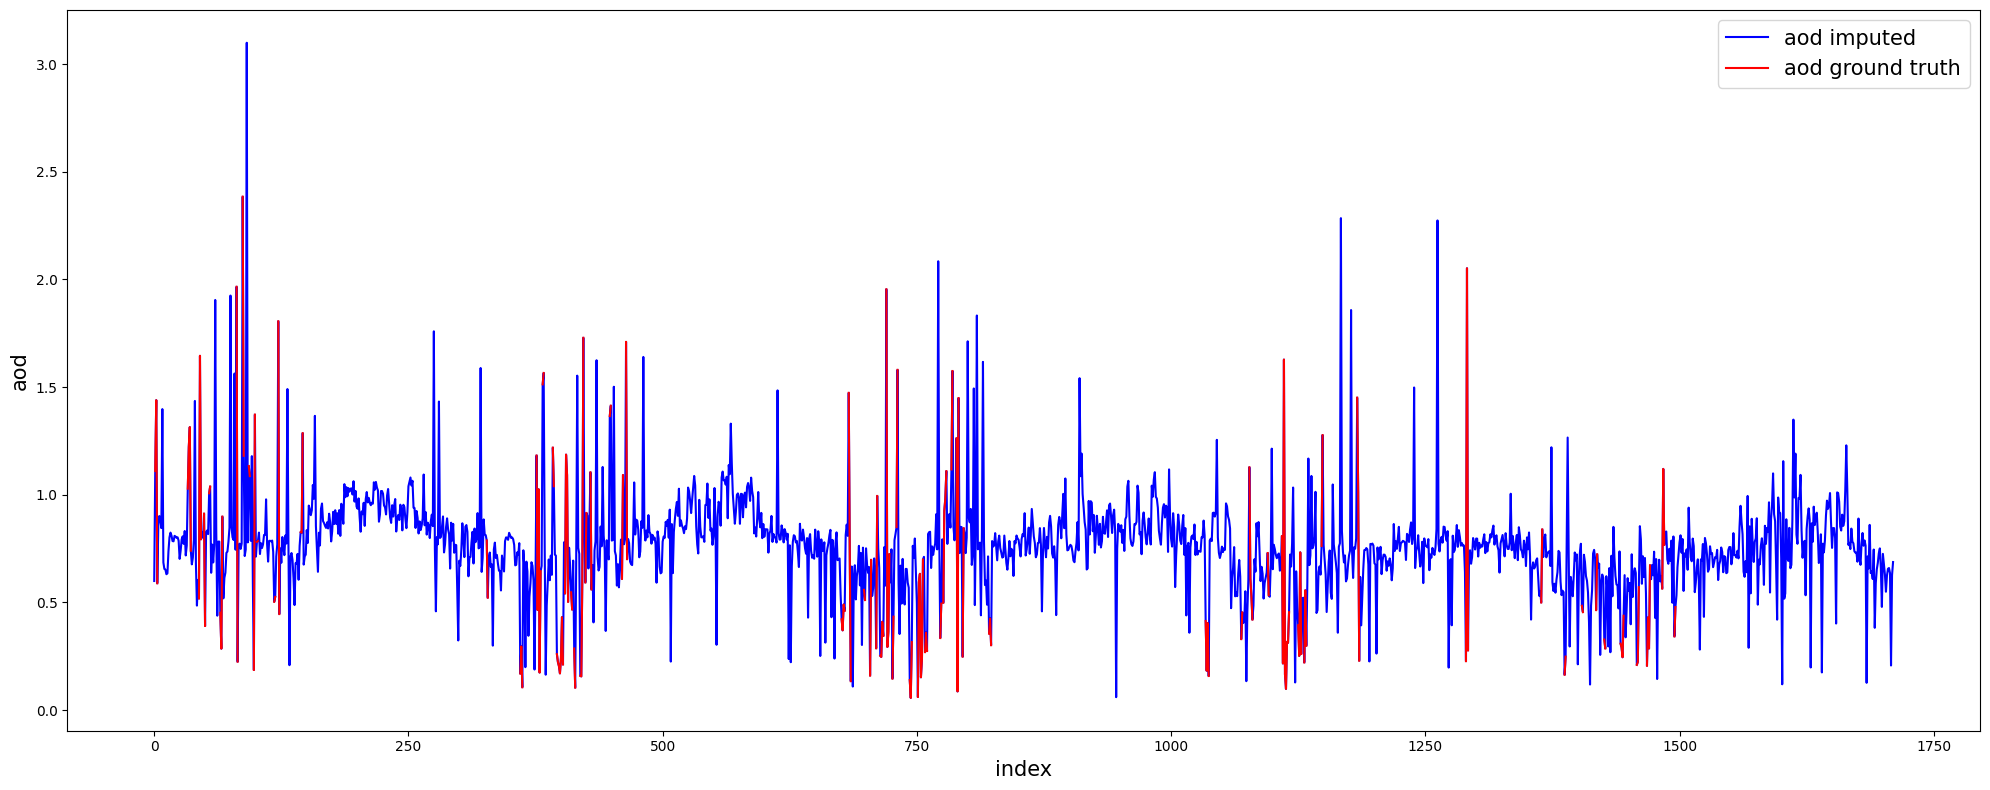


Handling for station 202



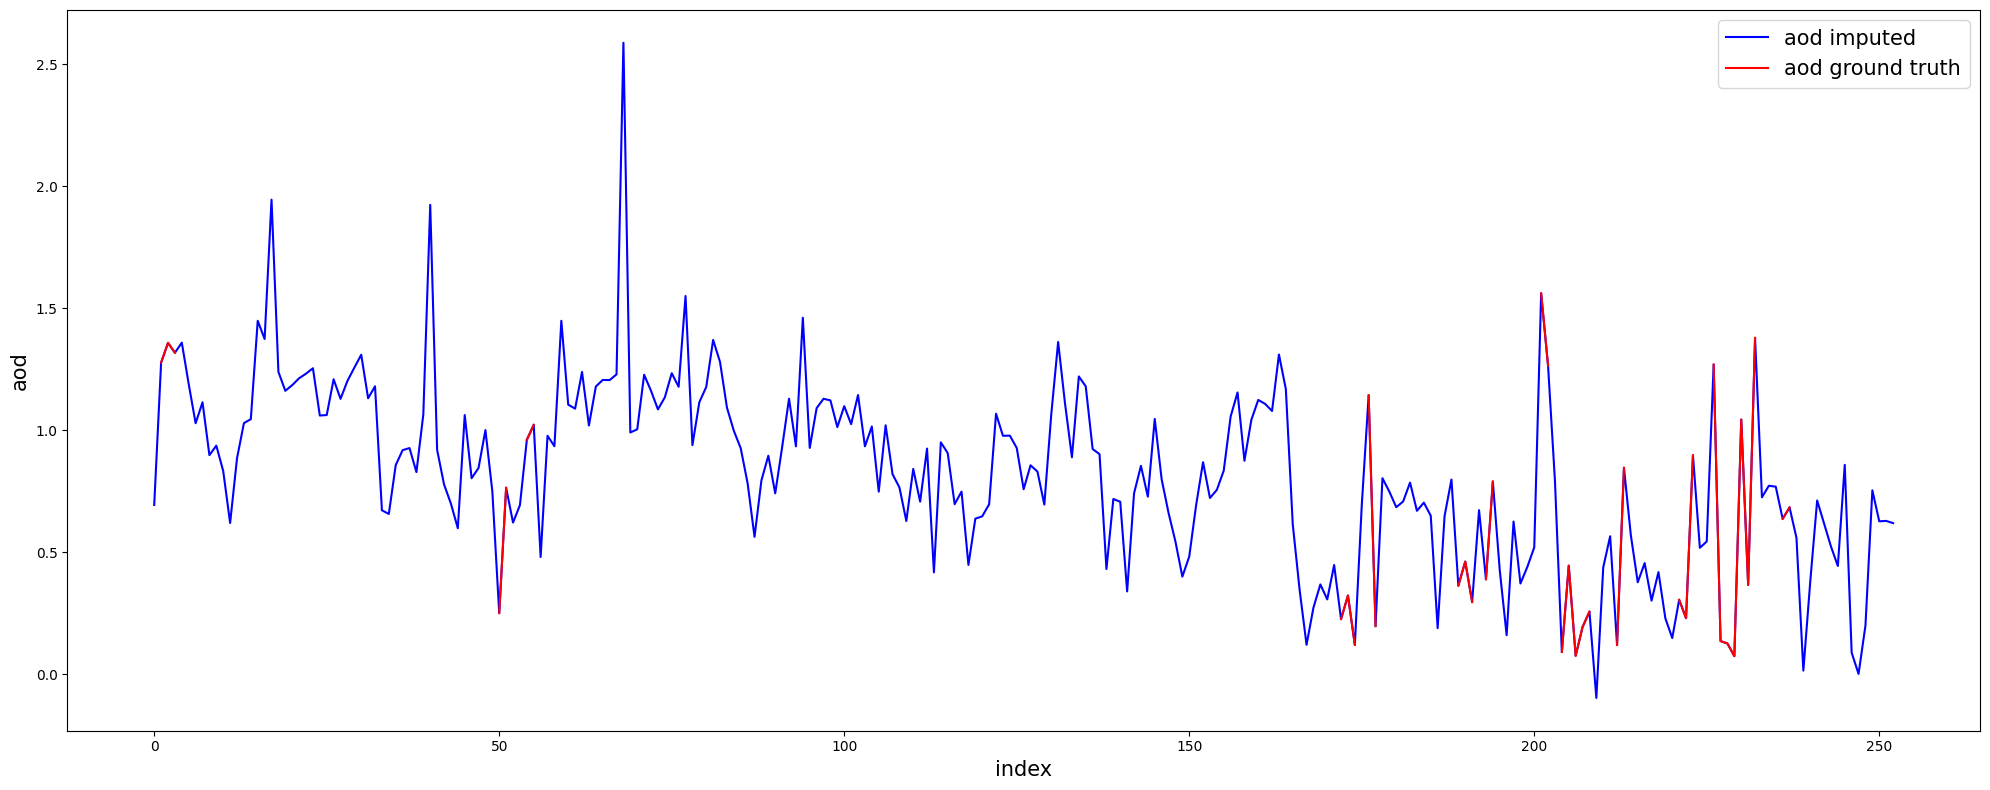


Handling for station 211



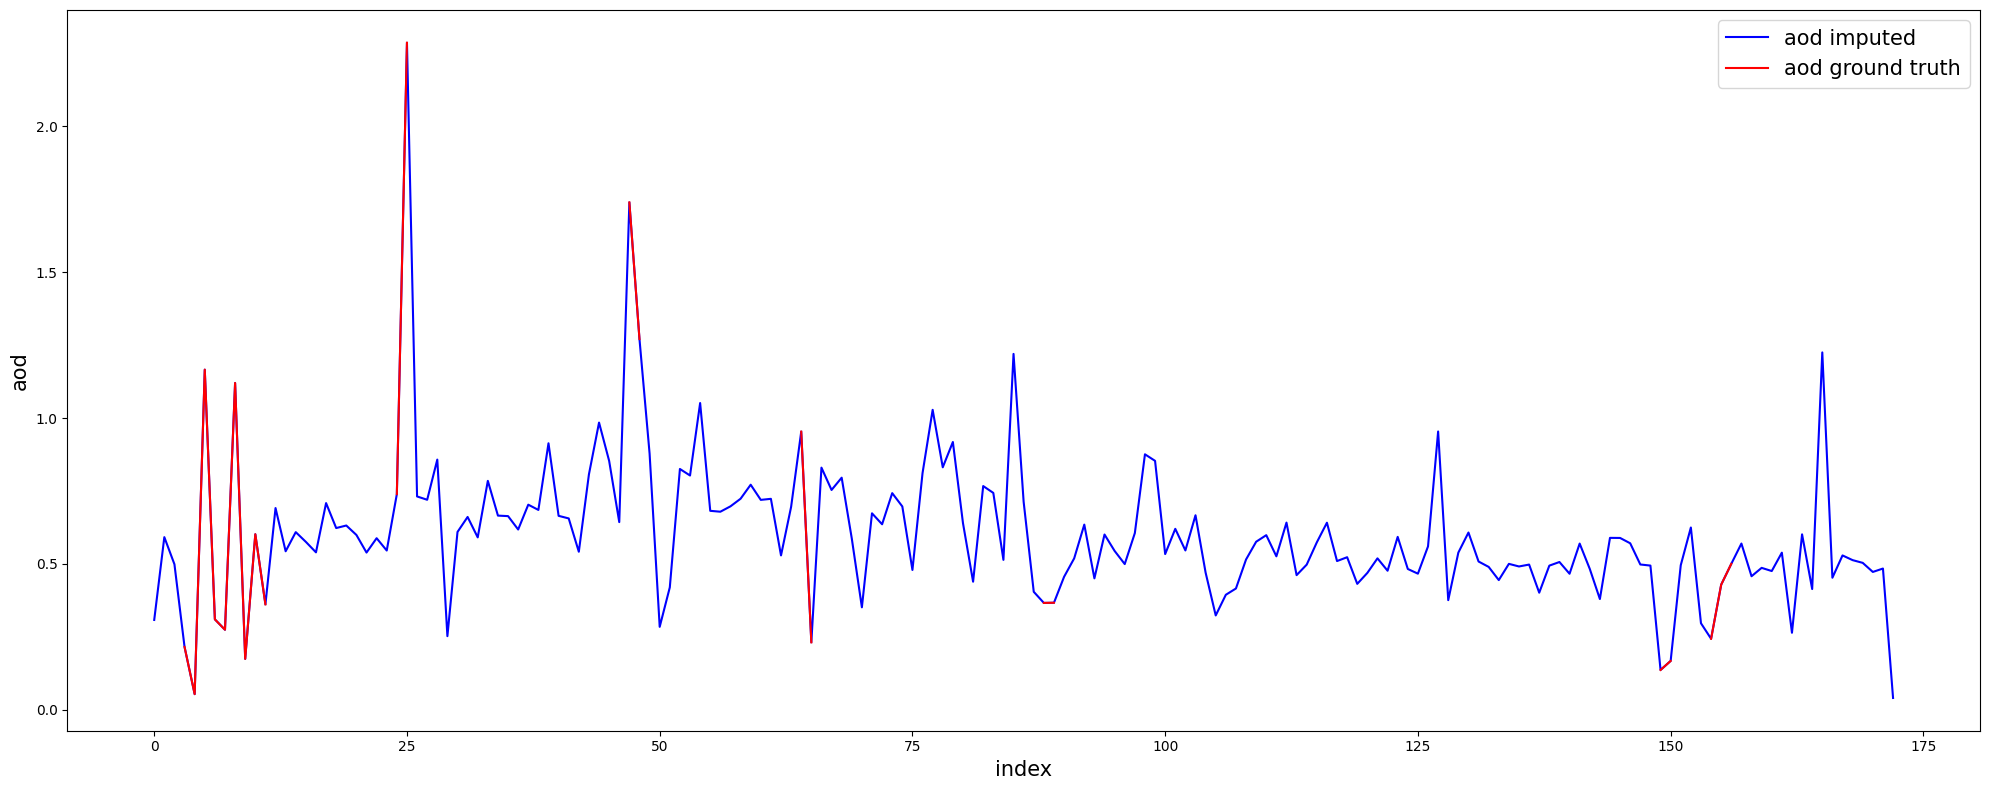


Handling for station 212



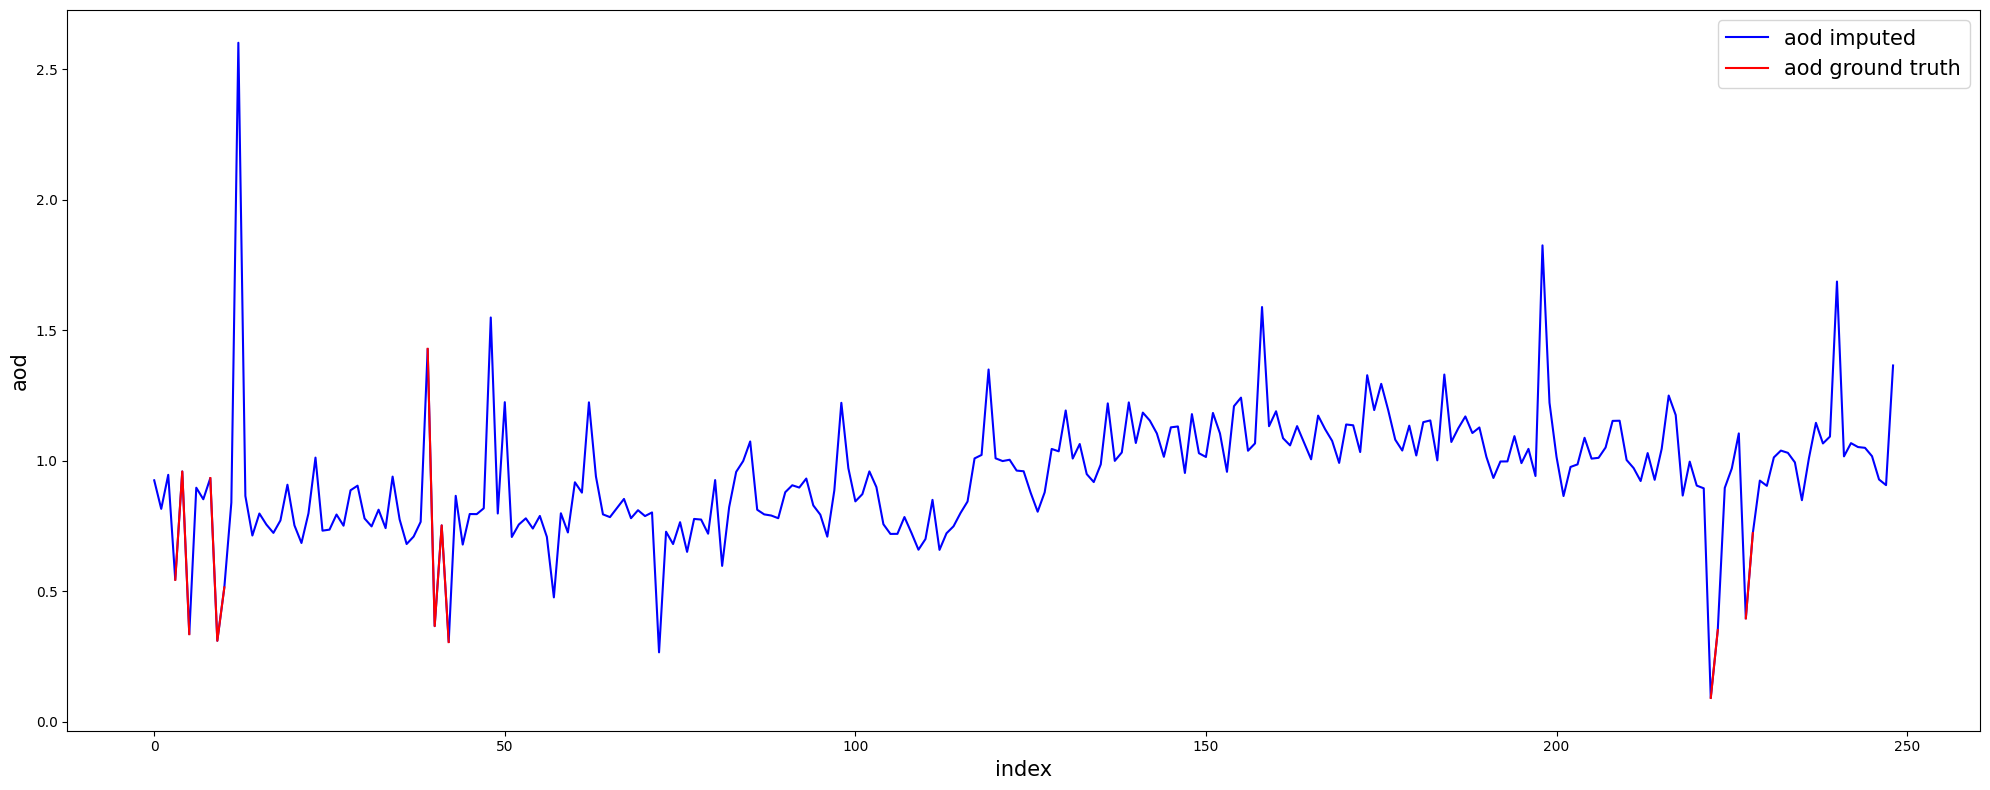


Handling for station 213



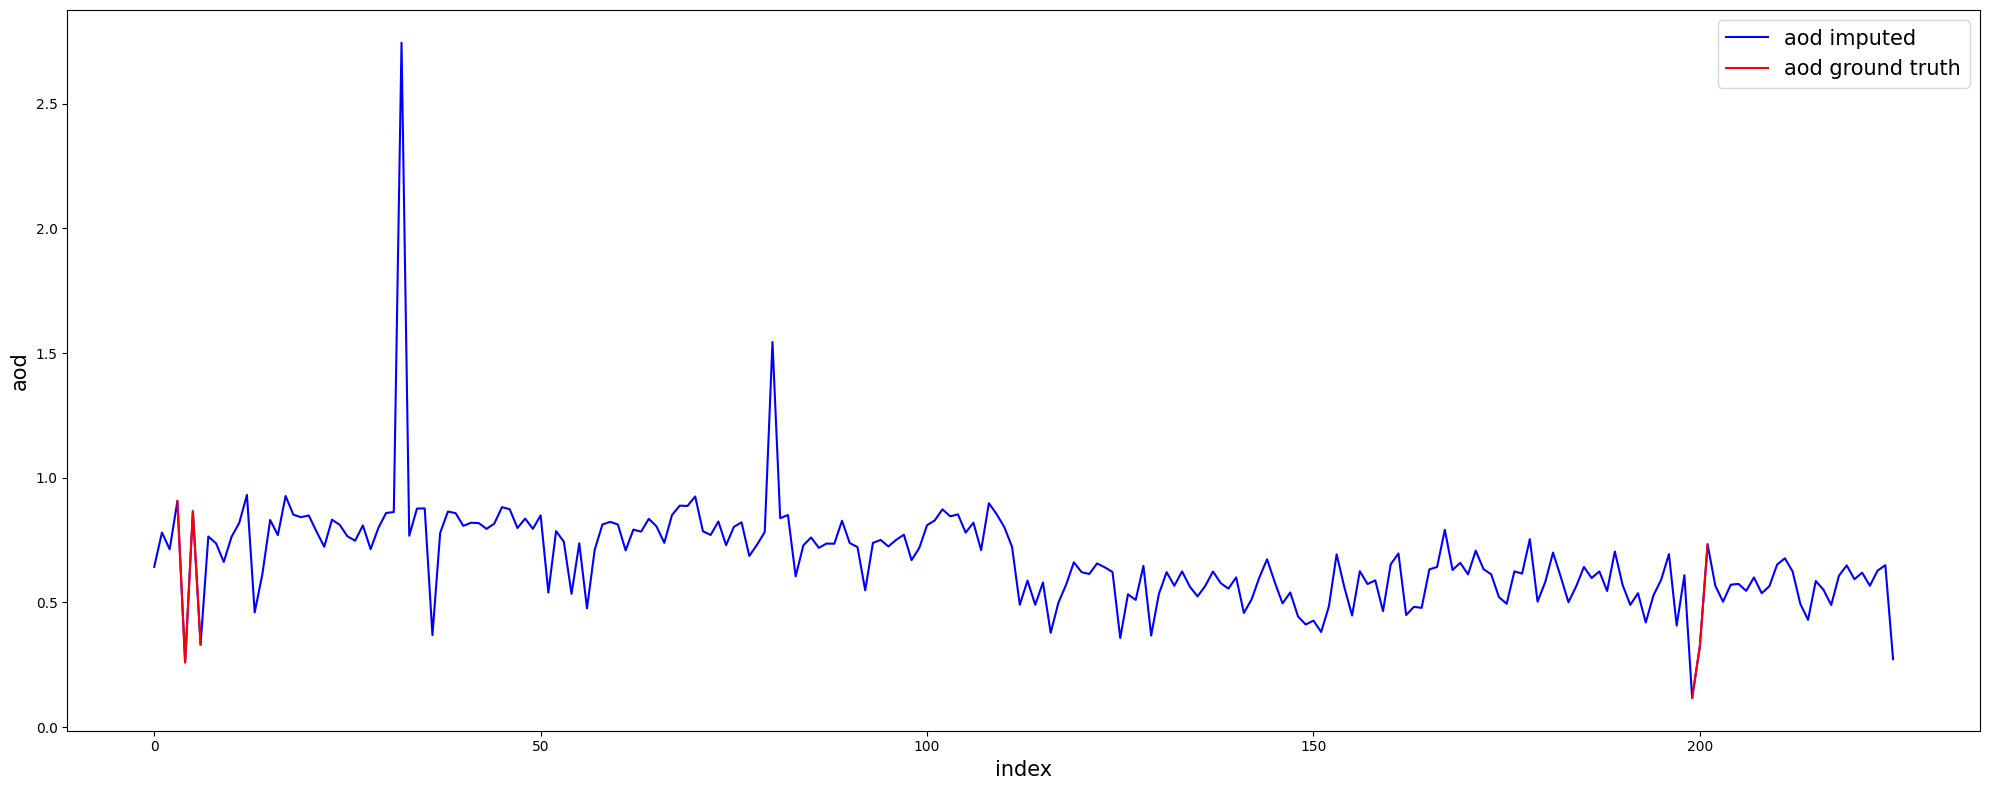


Handling for station 214



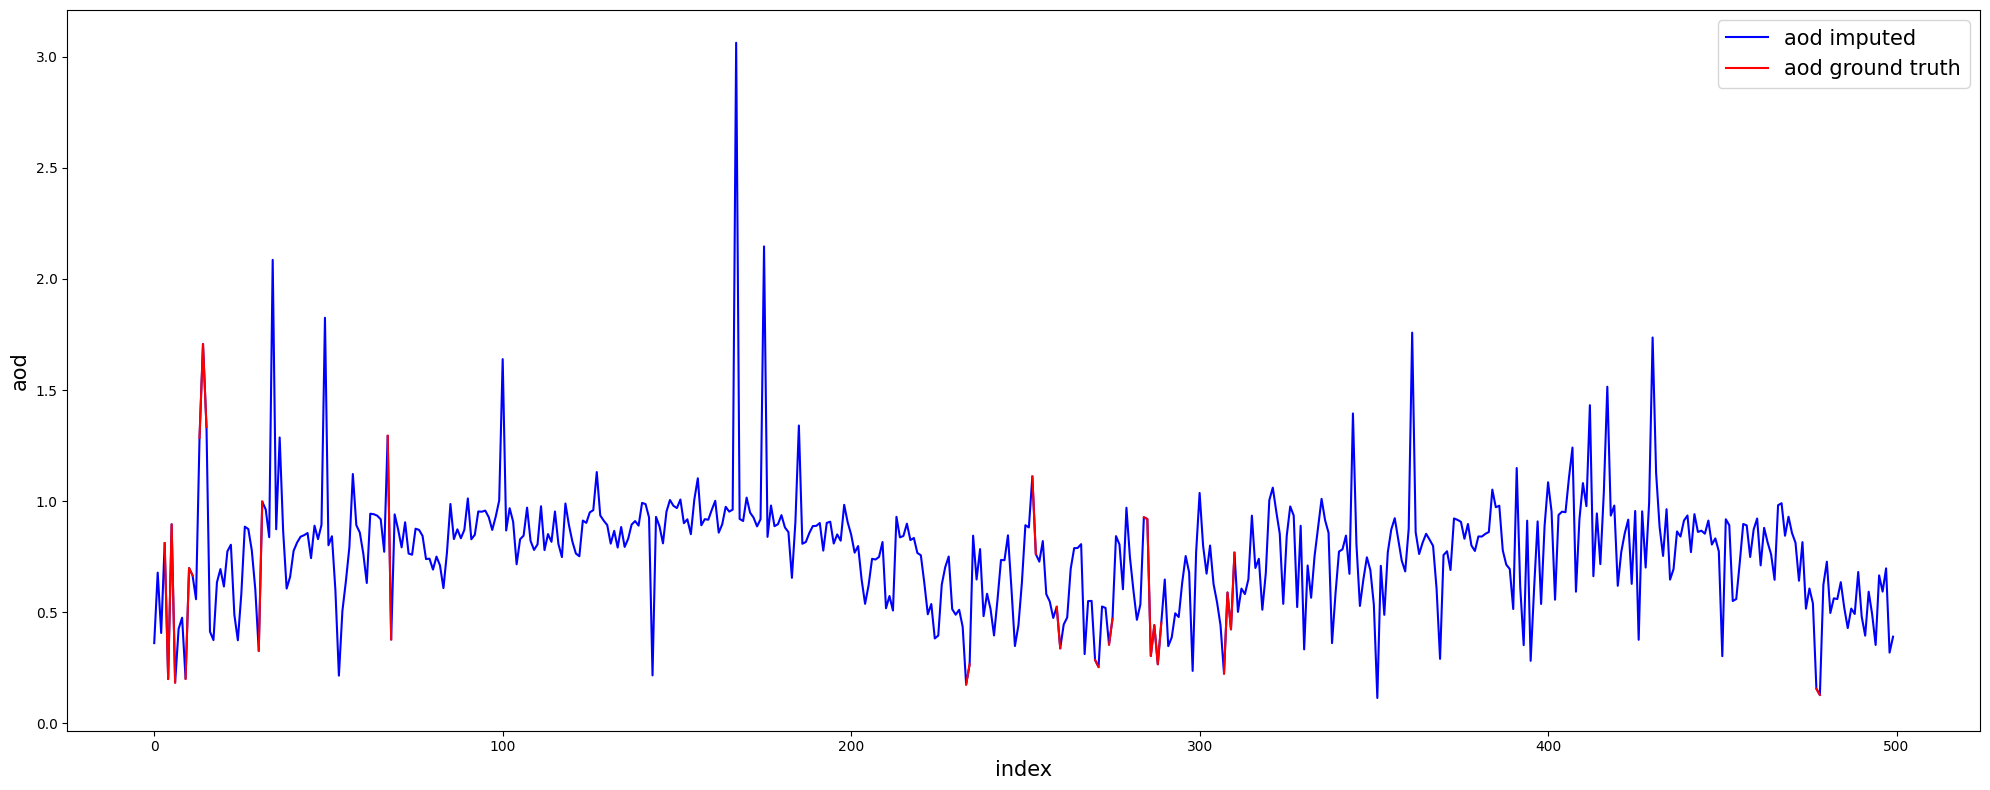


Handling for station 215



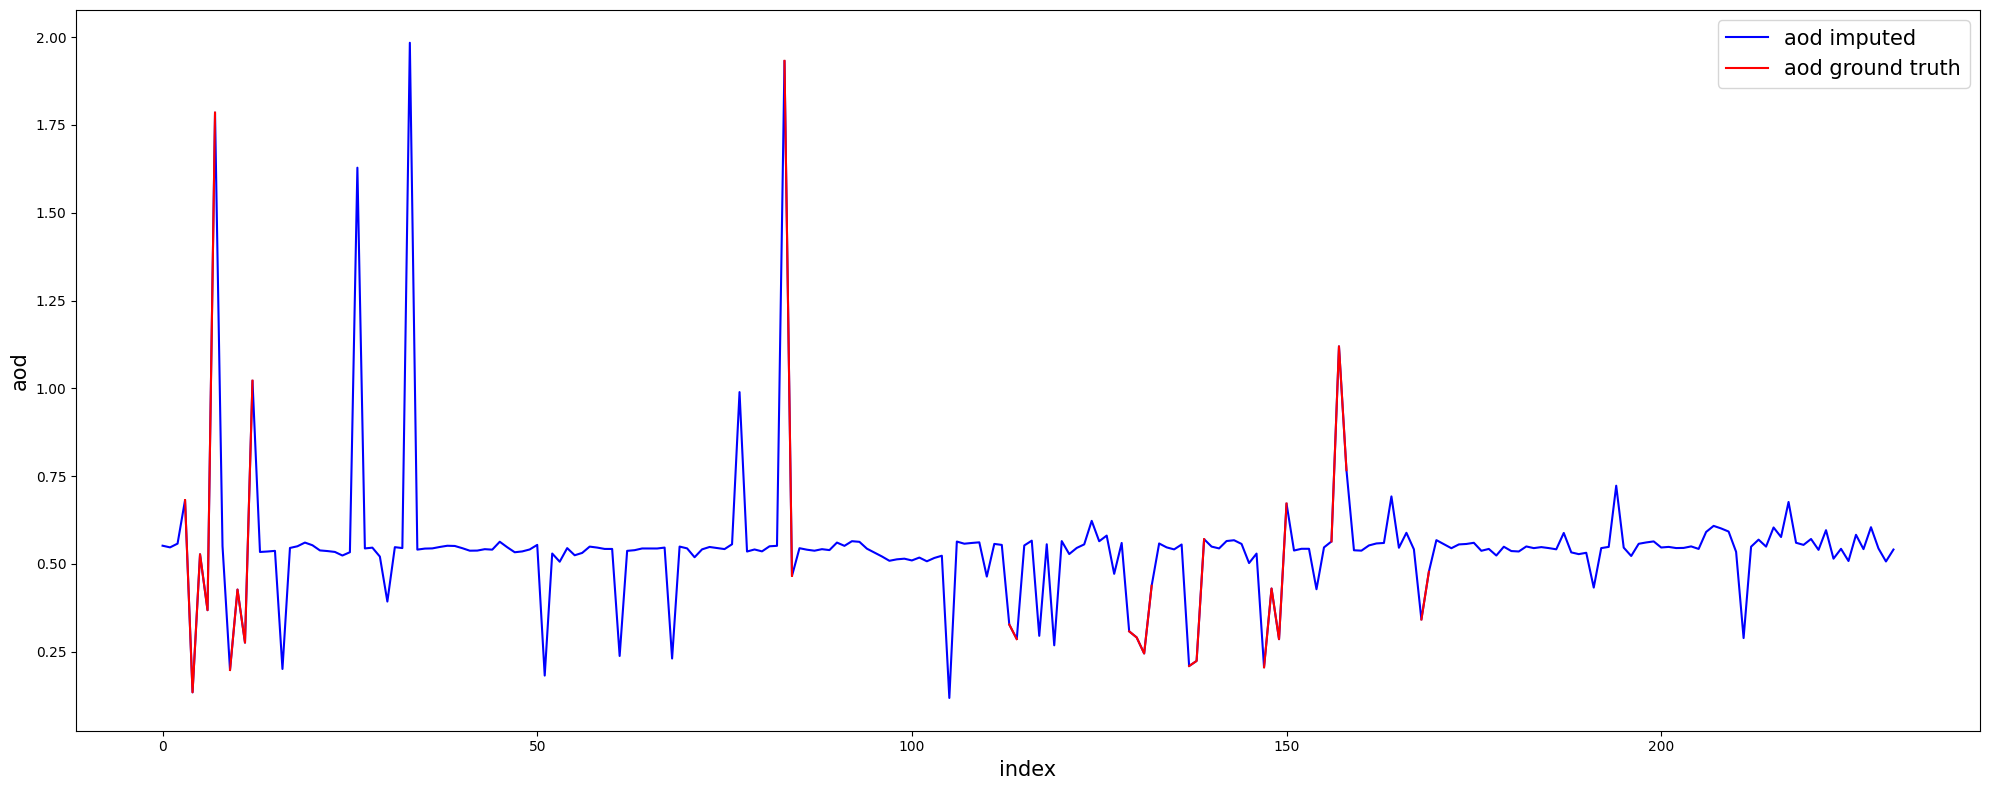


Handling for station 216



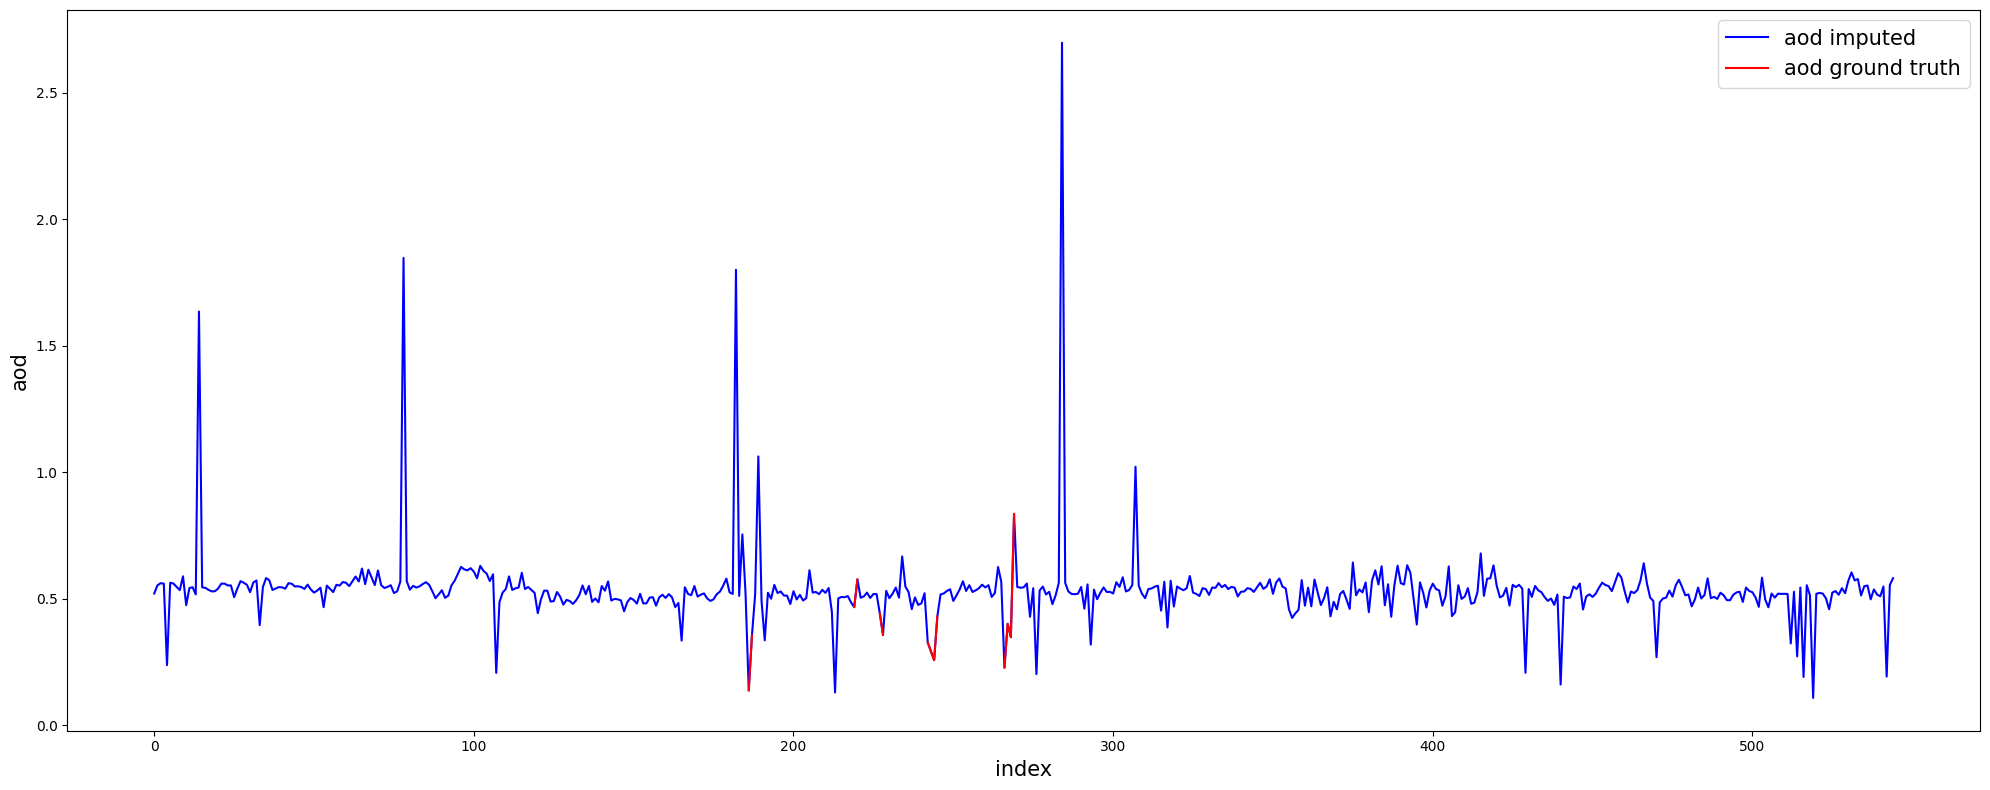

station       pm25        lat         lon   pm25_3km        tmp  \
time                                                                          
2018-01-01      201  31.391304  10.783057  106.700606  34.919998  25.204139   
2018-01-02      201  37.458333  10.783057  106.700606  51.830002  24.726431   
2018-01-03      201  68.083333  10.783057  106.700606  38.240002  26.095087   
2018-01-04      201  51.260870  10.783057  106.700606  40.259998  26.514926   
2018-01-05      201  18.909091  10.783057  106.700606  21.690001  25.483535   
...             ...        ...        ...         ...        ...        ...   
2022-12-27      216  39.659816  10.780482  106.659511  34.439411  24.136936   
2022-12-28      216  44.679352  10.780482  106.659511  29.838476  25.844296   
2022-12-29      216  30.724708  10.780482  106.659511  28.450829  25.841156   
2022-12-30      216  33.091428  10.780482  106.659511  19.854403  24.979719   
2022-12-31      216  28.854069  10.780482  106.659511  27.658358  25.364861   

                   rh        hpbl      wspd          pop  ...  \
time                                                      ...   
2018-01-01  70.056728  455.131335  2.352895  20680.62695  ...   
2018-01-02  73.425826  339.083720  1.903761  20680.62695  ...   
2018-01-03  77.793432  367.190738  1.293329  20680.62695  ...   
2018-01-04  82.982475  462.504210  1.588872  20680.62695  ...   
2018-01-05  93.046504  324.735356  2.505876  20680.62695  ...   
...               ...         ...       ...          ...  ...   
2022-12-27  73.973083  457.798645  2.002987  57523.91406  ...   
2022-12-28  65.530487  644.974548  2.298220  57523.91406  ...   
2022-12-29  67.093735  825.517395  2.823764  57523.91406  ...   
2022-12-30  64.868401  680.533081  3.893373  57523.91406  ...   
2022-12-31  62.377899  799.122803  4.161542  57523.91406  ...   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2018-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi       aod  
time                                                                 
2018-01-01  1876.639945  232011.95950    0.0  2700.122924  0.599173  
2018-01-02  1876.639945  232011.95950    0.0  2700.122924  1.110117  
2018-01-03  1876.639945  232011.95950    0.0  2700.122924  1.439045  
2018-01-04  1876.639945  232011.95950    0.0  2700.122924  0.588595  
2018-01-05  1876.639945  232011.95950    0.0  2700.122924  0.852506  
...                 ...           ...    ...          ...       ...  
2022-12-27  8099.182920   95807.40771    0.0  1879.344348  0.508564  
2022-12-28  8099.182920   95807.40771    0.0  1879.344348  0.547594  
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  0.191691  
2022-12-30  8099.182920   95807.40771    0.0  1879.344348  0.554055  
2022-12-31  8099.182920   95807.40771    0.0  1879.344348  0.580505  

[3889 rows x 21 columns]

In [96]:
all_stations_df = []

for station in aod_all_stations:
    print(f"\nHandling for station {station}\n")
    # Get dataframe of current station
    df_aod_current_station = df_aod_raw[df_aod_raw["station"] == station]
    
    # Fill "aod" column
    #df_aod_current_station.loc[:, "aod"] = df_aod_current_station.loc[:, "aod"].fillna(df_aod_current_station.loc[:, "aod"].mean())
    df_aod_current_station_imputed = copy.deepcopy(df_aod_current_station)
    df_aod_current_station_imputed.loc[:, "aod"] = mice(df_aod_current_station_imputed.drop(columns=["station", "pm25"]))["aod"]
    plot_2_data(data1=df_aod_current_station_imputed["aod"],
               datalabel1="aod imputed",
               data2=df_aod_current_station["aod"],
               datalabel2="aod ground truth",
               ylabel="aod",
               xlabel="index")

    # Store file for debugging after filling missing values
    df_aod_current_station_imputed.to_csv(f"{conf['workspace']['data_by_station_dir']}/df_aod_{station}.csv", index=True)

    # Reappend the location to dataset
    all_stations_df.append(df_aod_current_station_imputed)

# Merge all stations
df_aod = pd.concat(all_stations_df)
df_aod

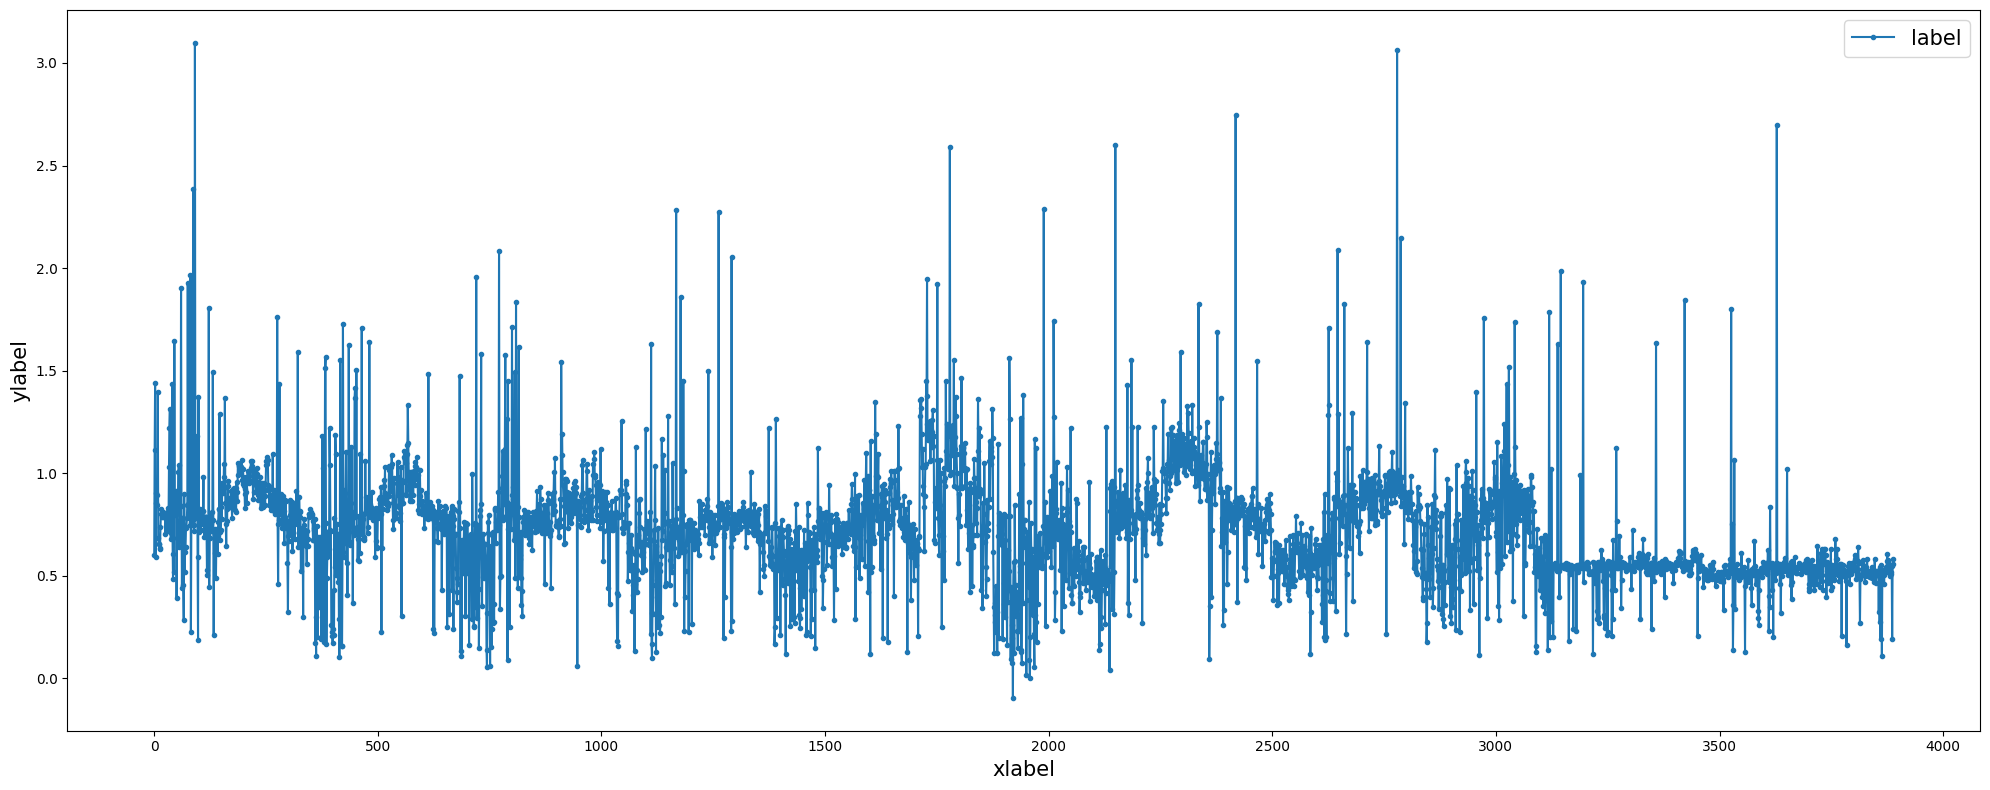

In [97]:
plot_1_data(df_aod["aod"])

In [98]:
df_aod.to_csv('df_aod.csv', index=True)

### Extract columns: time, stations, pm25_3km

In [99]:
# Get the time indices
aod_time_indices = df_aod.index
aod_time_indices

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='time', length=3889, freq=None)

In [100]:
# Get the station column
aod_station_column = df_aod.loc[:, "station"]
aod_station_column

time
2018-01-01    201
2018-01-02    201
2018-01-03    201
2018-01-04    201
2018-01-05    201
             ... 
2022-12-27    216
2022-12-28    216
2022-12-29    216
2022-12-30    216
2022-12-31    216
Name: station, Length: 3889, dtype: int64

In [101]:
# Get the pm25_3km column
aod_pm25_3km_column = df_aod.loc[:, "pm25_3km"]
aod_pm25_3km_column

time
2018-01-01    34.919998
2018-01-02    51.830002
2018-01-03    38.240002
2018-01-04    40.259998
2018-01-05    21.690001
                ...    
2022-12-27    34.439411
2022-12-28    29.838476
2022-12-29    28.450829
2022-12-30    19.854403
2022-12-31    27.658358
Name: pm25_3km, Length: 3889, dtype: float64

### Split into features and labels
* Label: pm25
* Features: other columns
    * Dynamic features
    * Static features

In [102]:
# Features with pm25_3km
aod_feats = aod_stat_feats + aod_dyn_feats

# Predict without "station" as a feature
# Remove "pm25_3km" also
aod_feats.remove("station")
aod_feats.remove("pm25_3km")
X_aod = df_aod.loc[:, aod_feats]

# Label
y_aod = df_aod.loc[:, aod_label]

In [103]:
X_aod

lat         lon          pop  road_den_1km  \
time                                                           
2018-01-01  10.783057  106.700606  20680.62695     27.462461   
2018-01-02  10.783057  106.700606  20680.62695     27.462461   
2018-01-03  10.783057  106.700606  20680.62695     27.462461   
2018-01-04  10.783057  106.700606  20680.62695     27.462461   
2018-01-05  10.783057  106.700606  20680.62695     27.462461   
...               ...         ...          ...           ...   
2022-12-27  10.780482  106.659511  57523.91406     33.629780   
2022-12-28  10.780482  106.659511  57523.91406     33.629780   
2022-12-29  10.780482  106.659511  57523.91406     33.629780   
2022-12-30  10.780482  106.659511  57523.91406     33.629780   
2022-12-31  10.780482  106.659511  57523.91406     33.629780   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2018-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi       aod  \
time                                                                  
2018-01-01  1876.639945  232011.95950    0.0  2700.122924  0.599173   
2018-01-02  1876.639945  232011.95950    0.0  2700.122924  1.110117   
2018-01-03  1876.639945  232011.95950    0.0  2700.122924  1.439045   
2018-01-04  1876.639945  232011.95950    0.0  2700.122924  0.588595   
2018-01-05  1876.639945  232011.95950    0.0  2700.122924  0.852506   
...                 ...           ...    ...          ...       ...   
2022-12-27  8099.182920   95807.40771    0.0  1879.344348  0.508564   
2022-12-28  8099.182920   95807.40771    0.0  1879.344348  0.547594   
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  0.191691   
2022-12-30  8099.182920   95807.40771    0.0  1879.344348  0.554055   
2022-12-31  8099.182920   95807.40771    0.0  1879.344348  0.580505   

                   rh        hpbl      wspd        tmp  
time                                                    
2018-01-01  70.056728  455.131335  2.352895  25.204139  
2018-01-02  73.425826  339.083720  1.903761  24.726431  
2018-01-03  77.793432  367.190738  1.293329  26.095087  
2018-01-04  82.982475  462.504210  1.588872  26.514926  
2018-01-05  93.046504  324.735356  2.505876  25.483535  
...               ...         ...       ...        ...  
2022-12-27  73.973083  457.798645  2.002987  24.136936  
2022-12-28  65.530487  644.974548  2.298220  25.844296  
2022-12-29  67.093735  825.517395  2.823764  25.841156  
2022-12-30  64.868401  680.533081  3.893373  24.979719  
2022-12-31  62.377899  799.122803  4.161542  25.364861  

[3889 rows x 18 columns]

In [104]:
y_aod

pm25
time                 
2018-01-01  31.391304
2018-01-02  37.458333
2018-01-03  68.083333
2018-01-04  51.260870
2018-01-05  18.909091
...               ...
2022-12-27  39.659816
2022-12-28  44.679352
2022-12-29  30.724708
2022-12-30  33.091428
2022-12-31  28.854069

[3889 rows x 1 columns]

### Data normalization

In [105]:
# Scaled features
aod_features_scaler = MinMaxScaler()
X_aod_scaled = aod_features_scaler.fit_transform(X_aod)
X_aod_scaled = pd.DataFrame(X_aod_scaled, columns=X_aod.columns)
X_aod_scaled

lat       lon       pop  road_den_1km  prim_road_len_1km  \
0     0.326794  0.466551  0.116512      0.471552           0.949821   
1     0.326794  0.466551  0.116512      0.471552           0.949821   
2     0.326794  0.466551  0.116512      0.471552           0.949821   
3     0.326794  0.466551  0.116512      0.471552           0.949821   
4     0.326794  0.466551  0.116512      0.471552           0.949821   
...        ...       ...       ...           ...                ...   
3884  0.306899  0.237227  0.857395      0.785926           0.323578   
3885  0.306899  0.237227  0.857395      0.785926           0.323578   
3886  0.306899  0.237227  0.857395      0.785926           0.323578   
3887  0.306899  0.237227  0.857395      0.785926           0.323578   
3888  0.306899  0.237227  0.857395      0.785926           0.323578   

      near_dist  bareland   builtup  cropland  grassland  treecover  water  \
0      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
1      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
2      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
3      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
4      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
...         ...       ...       ...       ...        ...        ...    ...   
3884   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   
3885   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   
3886   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   
3887   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   
3888   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   

          ndvi       aod        rh      hpbl      wspd       tmp  
0     0.526821  0.217912  0.468797  0.300502  0.170694  0.342735  
1     0.526821  0.377783  0.543165  0.211553  0.110646  0.303640  
2     0.526821  0.480703  0.639575  0.233097  0.029033  0.415649  
3     0.526821  0.214603  0.754117  0.306153  0.068546  0.450008  
4     0.526821  0.297179  0.976269  0.200556  0.191147  0.365600  
...        ...       ...       ...       ...       ...       ...  
3884  0.085003  0.189562  0.555246  0.302546  0.123912  0.255396  
3885  0.085003  0.201774  0.368885  0.446013  0.163384  0.395124  
3886  0.085003  0.090414  0.403392  0.584396  0.233647  0.394867  
3887  0.085003  0.203795  0.354270  0.473268  0.376650  0.324368  
3888  0.085003  0.212071  0.299295  0.564165  0.412504  0.355888  

[3889 rows x 18 columns]

In [106]:
# Scaled label
aod_label_scaler = MinMaxScaler(feature_range=(0, 1))
y_aod_scaled = aod_label_scaler.fit_transform(y_aod)
y_aod_scaled = pd.DataFrame(y_aod_scaled, columns=y_aod.columns)
y_aod_scaled

pm25
0     0.325673
1     0.398696
2     0.767302
3     0.564825
4     0.175435
...        ...
3884  0.425193
3885  0.485609
3886  0.317649
3887  0.346136
3888  0.295134

[3889 rows x 1 columns]

## Dimensionality Reduction Comparation

To compare the effect of each method, we will do the following things:
* Use the pm25 as the label
* Use other columns as the input features
* Reduce the dimension of input data using above methods
* Pass the processed input data to a model (e.g. LSTM, ...)

### Evaluation board

In [107]:
evaluation_board = {'dim_reduction_method': [], 'dim_after_reduction': [], 'prediction': []} | {m: [] for m in LSTMPrediction.get_supported_metrics()}
evaluation_board

{'dim_reduction_method': [],
 'dim_after_reduction': [],
 'prediction': [],
 'mae': [],
 'mse': [],
 'rmse': [],
 'r2': [],
 'mape': []}

### Range of dimension

In [108]:
RANGE_OF_DIMENSION = range(conf["reduction"]["min_number_of_features"], X_aod_scaled.shape[1])
#RANGE_OF_DIMENSION = range(2, 5)
for n in RANGE_OF_DIMENSION:
  print(n, end=' ')

13 14 15 16 17 

### Prediction without reduction

Model: "aod_LSTMPrediction_no_dim_reduction"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_98      │ (None, 24, 19)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_136 (LSTM)     │ [(None, 64),      │     21,504 │ input_layer_98[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_78    │ (None, 1, 64)     │          0 │ lstm_136[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_137 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_78… │
│                     │                   │            │ lstm_136[0][1],   │
│                     │                   │            │ lstm_136[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 1, 64)     │          0 │ lstm_137[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_38[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,641 (221.25 KB)

 Trainable params: 56,641 (221.25 KB)

 Non-trainable params: 0 (0.00 B)

None


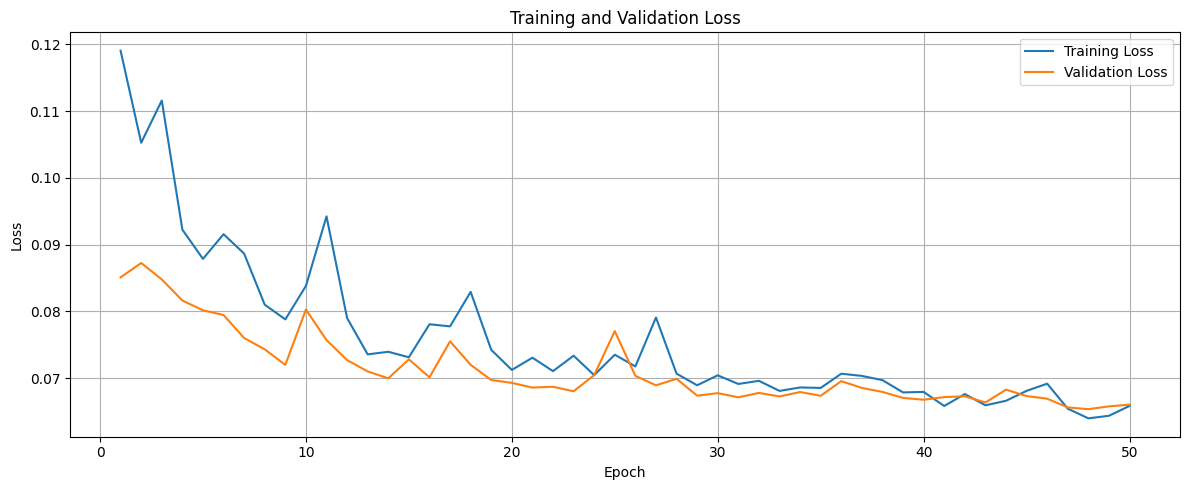

inv_y_pred.shape = (773, 1)
inv_y_test.shape = (773, 1)


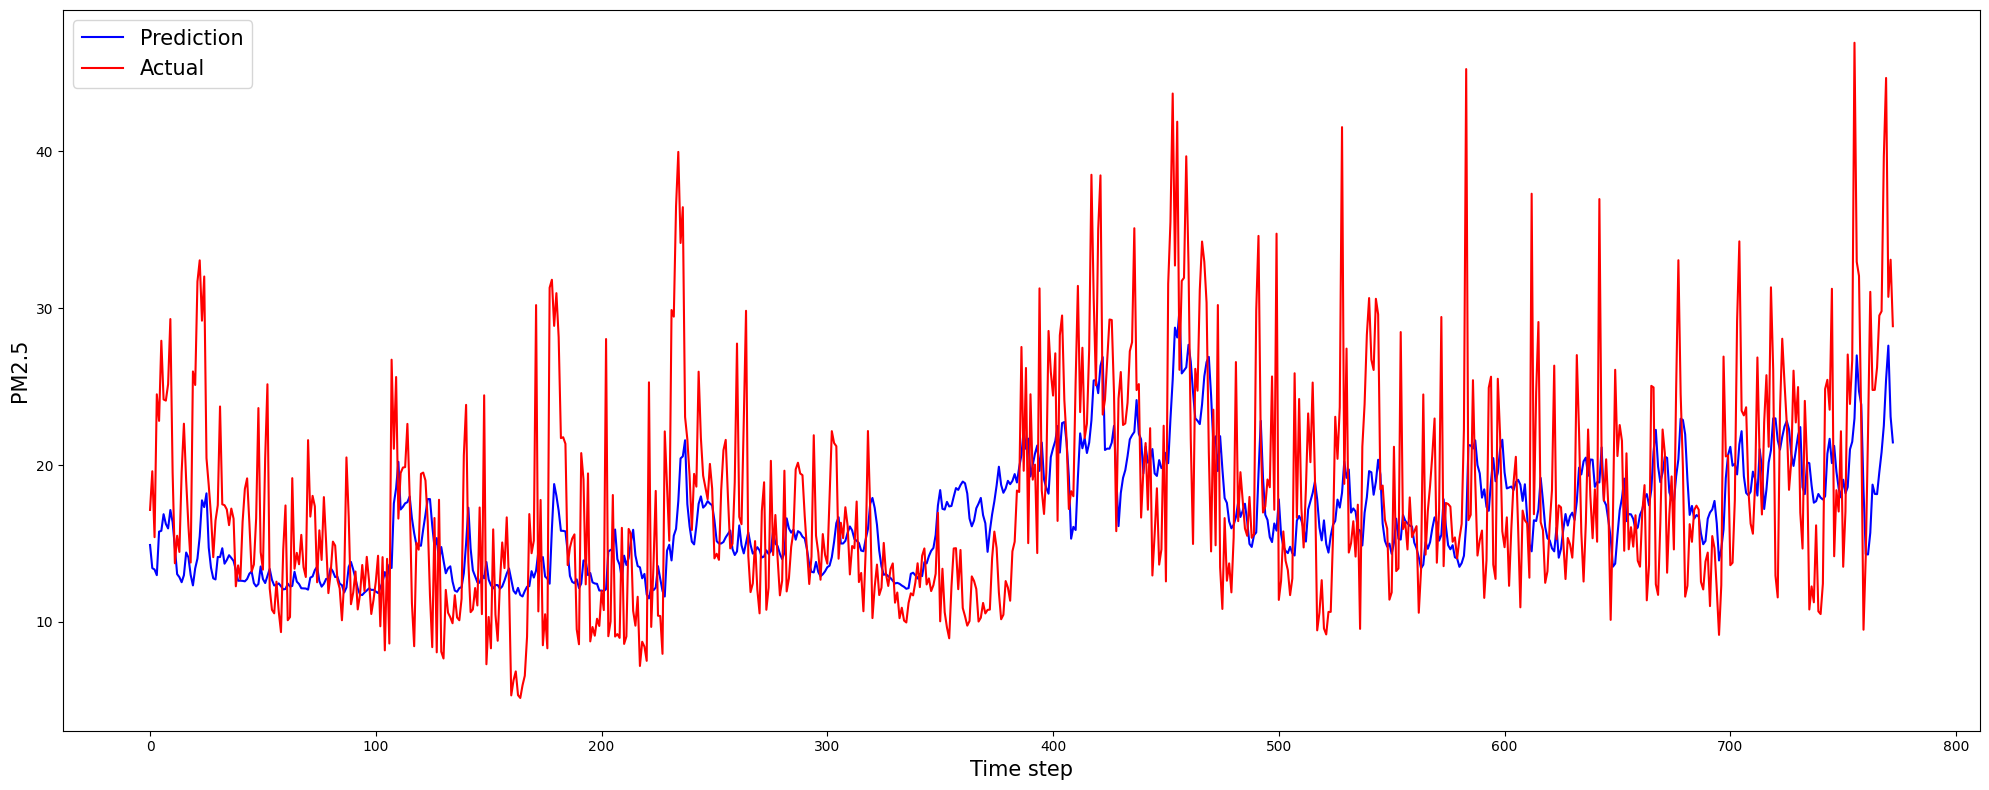

dim_reduction_method dim_after_reduction prediction       mae        mse  \
0                 None                 N/A       LSTM  4.526494  37.178583   

       rmse        r2      mape  
0  6.097424 -2.126817  0.272811

In [109]:
# Prediction
lstmpred = LSTMPrediction(X_aod_scaled, y_aod_scaled,
                            aod_label_scaler,
                            val_percentage=0.2, test_percentage=0.2,
                            n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                            epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                            model_name=f"aod_{LSTMPrediction.class_name}_no_dim_reduction",
                            verbose=0)
lstmpred.get_model_info()
all_days_inv_y_pred, all_days_inv_y_test, metrics = lstmpred.execute()

# Visualize the prediction
plot_prediction(all_days_inv_y_pred, all_days_inv_y_test, conf["prediction"]["n_future"])

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["None"]
evaluation_board['dim_after_reduction'] += ["N/A"]
evaluation_board['prediction'] += ["LSTM"]
for m in LSTMPrediction.get_supported_metrics():
    evaluation_board[m] += [metrics[m][1]]
pd.DataFrame(evaluation_board)

### Prediction + LSTM-Seq2Seq

#### Doing the loop

Model: "aod_LSTMSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_99      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_138 (LSTM)     │ (None, 7, 100)    │     47,600 │ input_layer_99[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_139 (LSTM)     │ [(None, 50),      │     30,200 │ lstm_138[0][0]    │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_142 (Dense)   │ (None, 13)        │        663 │ lstm_139[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_79    │ (None, 7, 13)     │          0 │ dense_142[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_140 (LSTM)     │ (None, 7, 50)     │     12,800 │ repeat_vector_79… │
│                     │                   │            │ lstm_139[0][1],   │
│                     │                   │            │ lstm_139[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_141 (LSTM)     │ (None, 7, 100)    │     60,400 │ lstm_140[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │      1,818 │ lstm_141[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 460,445 (1.76 MB)

 Trainable params: 153,481 (599.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 306,964 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_13_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_100 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_138 (LSTM)                 │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_139 (LSTM)                 │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,463 (306.50 KB)

 Trainable params: 78,463 (306.50 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_101     │ (None, 24, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_142 (LSTM)     │ [(None, 64),      │     20,224 │ input_layer_101[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_80    │ (None, 1, 64)     │          0 │ lstm_142[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_143 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_80… │
│                     │                   │            │ lstm_142[0][1],   │
│                     │                   │            │ lstm_142[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 1, 64)     │          0 │ lstm_143[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_39[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,361 (216.25 KB)

 Trainable params: 55,361 (216.25 KB)

 Non-trainable params: 0 (0.00 B)

None


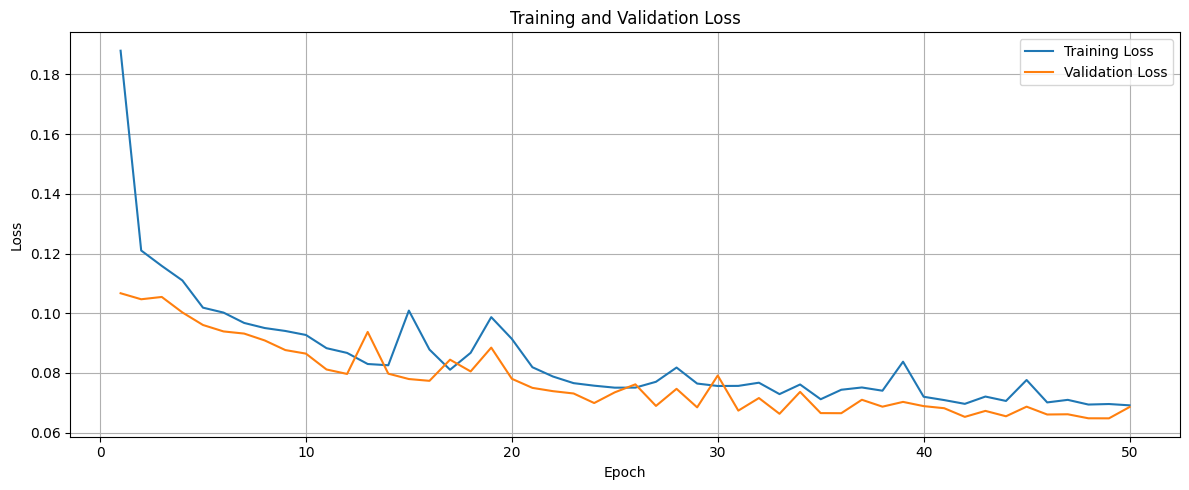

Model: "aod_LSTMSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_102     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_144 (LSTM)     │ (None, 7, 100)    │     47,600 │ input_layer_102[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_145 (LSTM)     │ [(None, 50),      │     30,200 │ lstm_144[0][0]    │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_146 (Dense)   │ (None, 14)        │        714 │ lstm_145[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_81    │ (None, 7, 14)     │          0 │ dense_146[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_146 (LSTM)     │ (None, 7, 50)     │     13,000 │ repeat_vector_81… │
│                     │                   │            │ lstm_145[0][1],   │
│                     │                   │            │ lstm_145[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_147 (LSTM)     │ (None, 7, 100)    │     60,400 │ lstm_146[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │      1,818 │ lstm_147[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,198 (1.76 MB)

 Trainable params: 153,732 (600.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 307,466 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_14_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_103 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_144 (LSTM)                 │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_145 (LSTM)                 │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,514 (306.70 KB)

 Trainable params: 78,514 (306.70 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_104     │ (None, 24, 15)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_148 (LSTM)     │ [(None, 64),      │     20,480 │ input_layer_104[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_82    │ (None, 1, 64)     │          0 │ lstm_148[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_149 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_82… │
│                     │                   │            │ lstm_148[0][1],   │
│                     │                   │            │ lstm_148[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 1, 64)     │          0 │ lstm_149[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_40[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,617 (217.25 KB)

 Trainable params: 55,617 (217.25 KB)

 Non-trainable params: 0 (0.00 B)

None


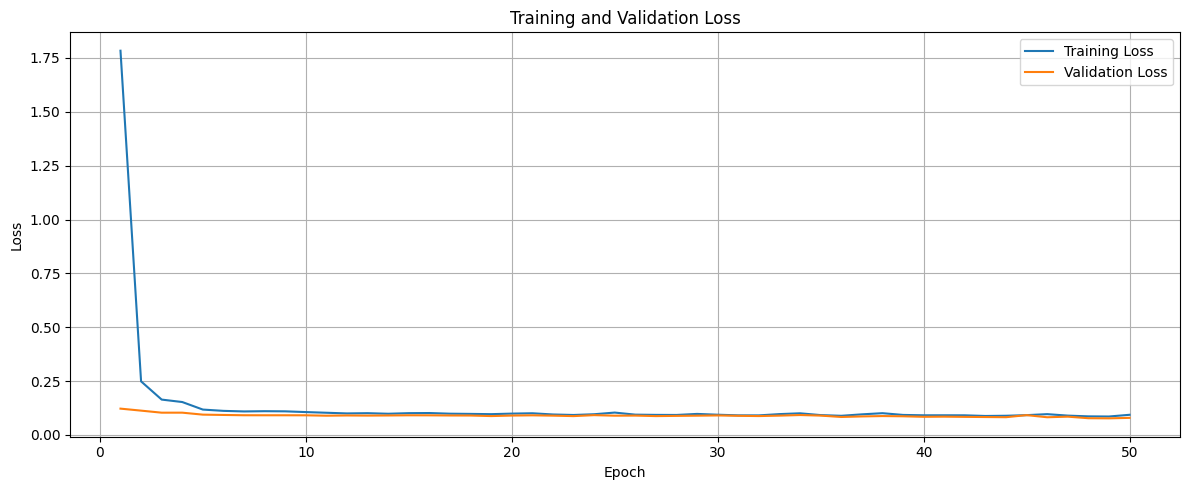

Model: "aod_LSTMSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_105     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_150 (LSTM)     │ (None, 7, 100)    │     47,600 │ input_layer_105[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_151 (LSTM)     │ [(None, 50),      │     30,200 │ lstm_150[0][0]    │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_150 (Dense)   │ (None, 15)        │        765 │ lstm_151[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_83    │ (None, 7, 15)     │          0 │ dense_150[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_152 (LSTM)     │ (None, 7, 50)     │     13,200 │ repeat_vector_83… │
│                     │                   │            │ lstm_151[0][1],   │
│                     │                   │            │ lstm_151[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_153 (LSTM)     │ (None, 7, 100)    │     60,400 │ lstm_152[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │      1,818 │ lstm_153[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,951 (1.76 MB)

 Trainable params: 153,983 (601.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 307,968 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_106 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_150 (LSTM)                 │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_151 (LSTM)                 │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,565 (306.89 KB)

 Trainable params: 78,565 (306.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_107     │ (None, 24, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_154 (LSTM)     │ [(None, 64),      │     20,736 │ input_layer_107[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_84    │ (None, 1, 64)     │          0 │ lstm_154[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_155 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_84… │
│                     │                   │            │ lstm_154[0][1],   │
│                     │                   │            │ lstm_154[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 1, 64)     │          0 │ lstm_155[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_41[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,873 (218.25 KB)

 Trainable params: 55,873 (218.25 KB)

 Non-trainable params: 0 (0.00 B)

None


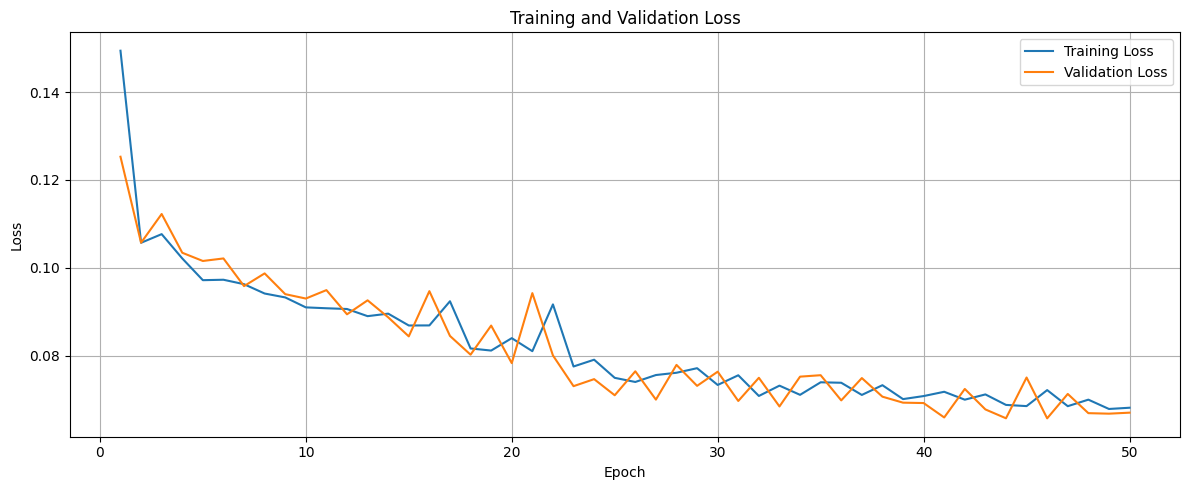

Model: "aod_LSTMSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_108     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_156 (LSTM)     │ (None, 7, 100)    │     47,600 │ input_layer_108[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_157 (LSTM)     │ [(None, 50),      │     30,200 │ lstm_156[0][0]    │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_154 (Dense)   │ (None, 16)        │        816 │ lstm_157[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_85    │ (None, 7, 16)     │          0 │ dense_154[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_158 (LSTM)     │ (None, 7, 50)     │     13,400 │ repeat_vector_85… │
│                     │                   │            │ lstm_157[0][1],   │
│                     │                   │            │ lstm_157[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_159 (LSTM)     │ (None, 7, 100)    │     60,400 │ lstm_158[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │      1,818 │ lstm_159[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 462,704 (1.77 MB)

 Trainable params: 154,234 (602.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,470 (1.18 MB)

None


Model: "aod_LSTMSeq2SeqReduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_109 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_156 (LSTM)                 │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_157 (LSTM)                 │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,616 (307.09 KB)

 Trainable params: 78,616 (307.09 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_110     │ (None, 24, 17)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_160 (LSTM)     │ [(None, 64),      │     20,992 │ input_layer_110[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_86    │ (None, 1, 64)     │          0 │ lstm_160[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_161 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_86… │
│                     │                   │            │ lstm_160[0][1],   │
│                     │                   │            │ lstm_160[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 1, 64)     │          0 │ lstm_161[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_42[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,129 (219.25 KB)

 Trainable params: 56,129 (219.25 KB)

 Non-trainable params: 0 (0.00 B)

None


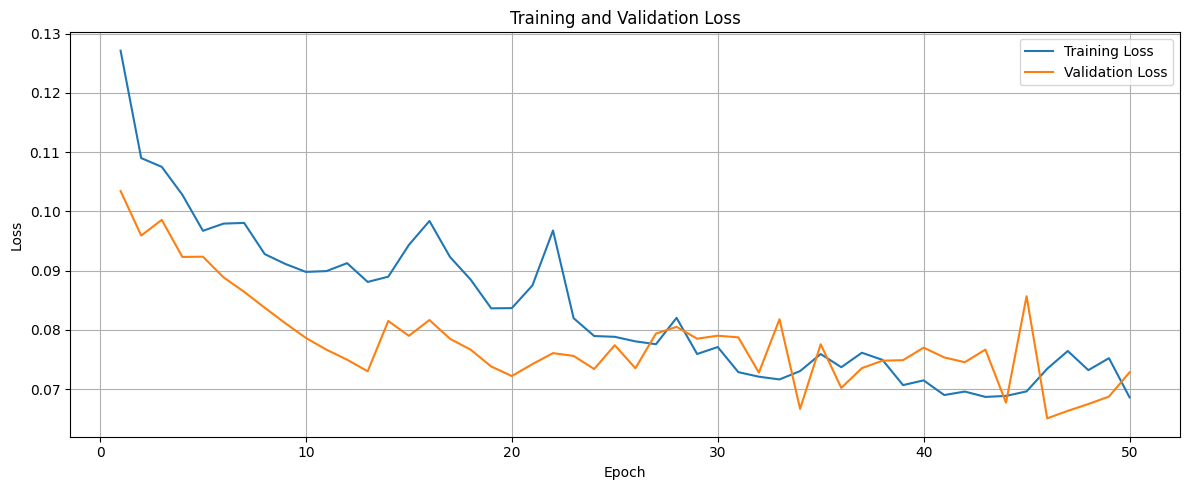

Model: "aod_LSTMSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_111     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_162 (LSTM)     │ (None, 7, 100)    │     47,600 │ input_layer_111[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_163 (LSTM)     │ [(None, 50),      │     30,200 │ lstm_162[0][0]    │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_158 (Dense)   │ (None, 17)        │        867 │ lstm_163[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_87    │ (None, 7, 17)     │          0 │ dense_158[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_164 (LSTM)     │ (None, 7, 50)     │     13,600 │ repeat_vector_87… │
│                     │                   │            │ lstm_163[0][1],   │
│                     │                   │            │ lstm_163[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_165 (LSTM)     │ (None, 7, 100)    │     60,400 │ lstm_164[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │      1,818 │ lstm_165[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 463,457 (1.77 MB)

 Trainable params: 154,485 (603.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,972 (1.18 MB)

None


Model: "aod_LSTMSeq2SeqReduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_112 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_162 (LSTM)                 │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_163 (LSTM)                 │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,667 (307.29 KB)

 Trainable params: 78,667 (307.29 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_113     │ (None, 24, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_166 (LSTM)     │ [(None, 64),      │     21,248 │ input_layer_113[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_88    │ (None, 1, 64)     │          0 │ lstm_166[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_167 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_88… │
│                     │                   │            │ lstm_166[0][1],   │
│                     │                   │            │ lstm_166[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 1, 64)     │          0 │ lstm_167[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_43[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,385 (220.25 KB)

 Trainable params: 56,385 (220.25 KB)

 Non-trainable params: 0 (0.00 B)

None


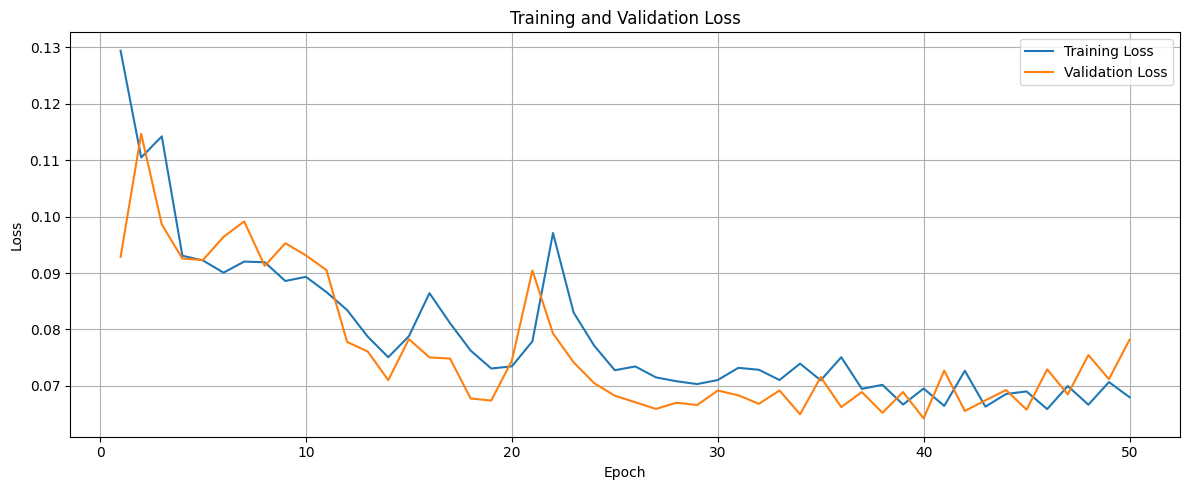

Choosing the best result

dict_keys([13, 14, 15, 16, 17])
N = 13
mae = 5.004044770503596
mse = 36.324690892485556
rmse = 6.026996838599267
r2 = -1.4301731565594133
mape = 0.25349614684091826
N = 14
mae = 5.201640134697549
mse = 51.0819199113985
rmse = 7.147161668200776
r2 = -15.729196148200135
mape = 0.3292228751306369
N = 15
mae = 4.290929100805297
mse = 36.79003190568848
rmse = 6.065478703753603
r2 = -2.658193104158049
mape = 0.2692780992797883
N = 16
mae = 5.435697725003425
mse = 41.39152263931653
rmse = 6.433624378164809
r2 = -3.9530869750349424
mape = 0.2681866487445891
N = 17
mae = 6.0281079534622934
mse = 50.430684185647195
rmse = 7.10145648340164
r2 = -2.2591239575544364
mape = 0.27886462585393584


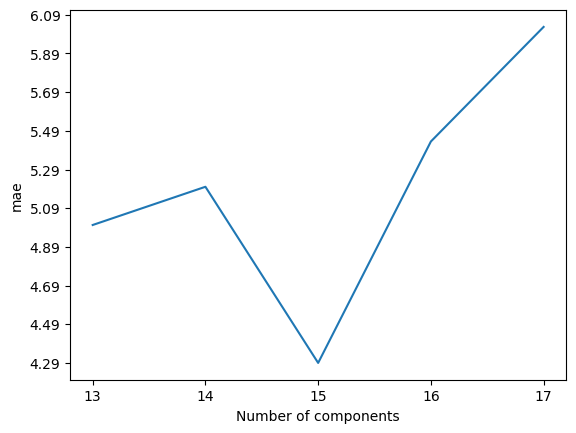

inv_y_pred.shape = (773, 1)
inv_y_test.shape = (773, 1)


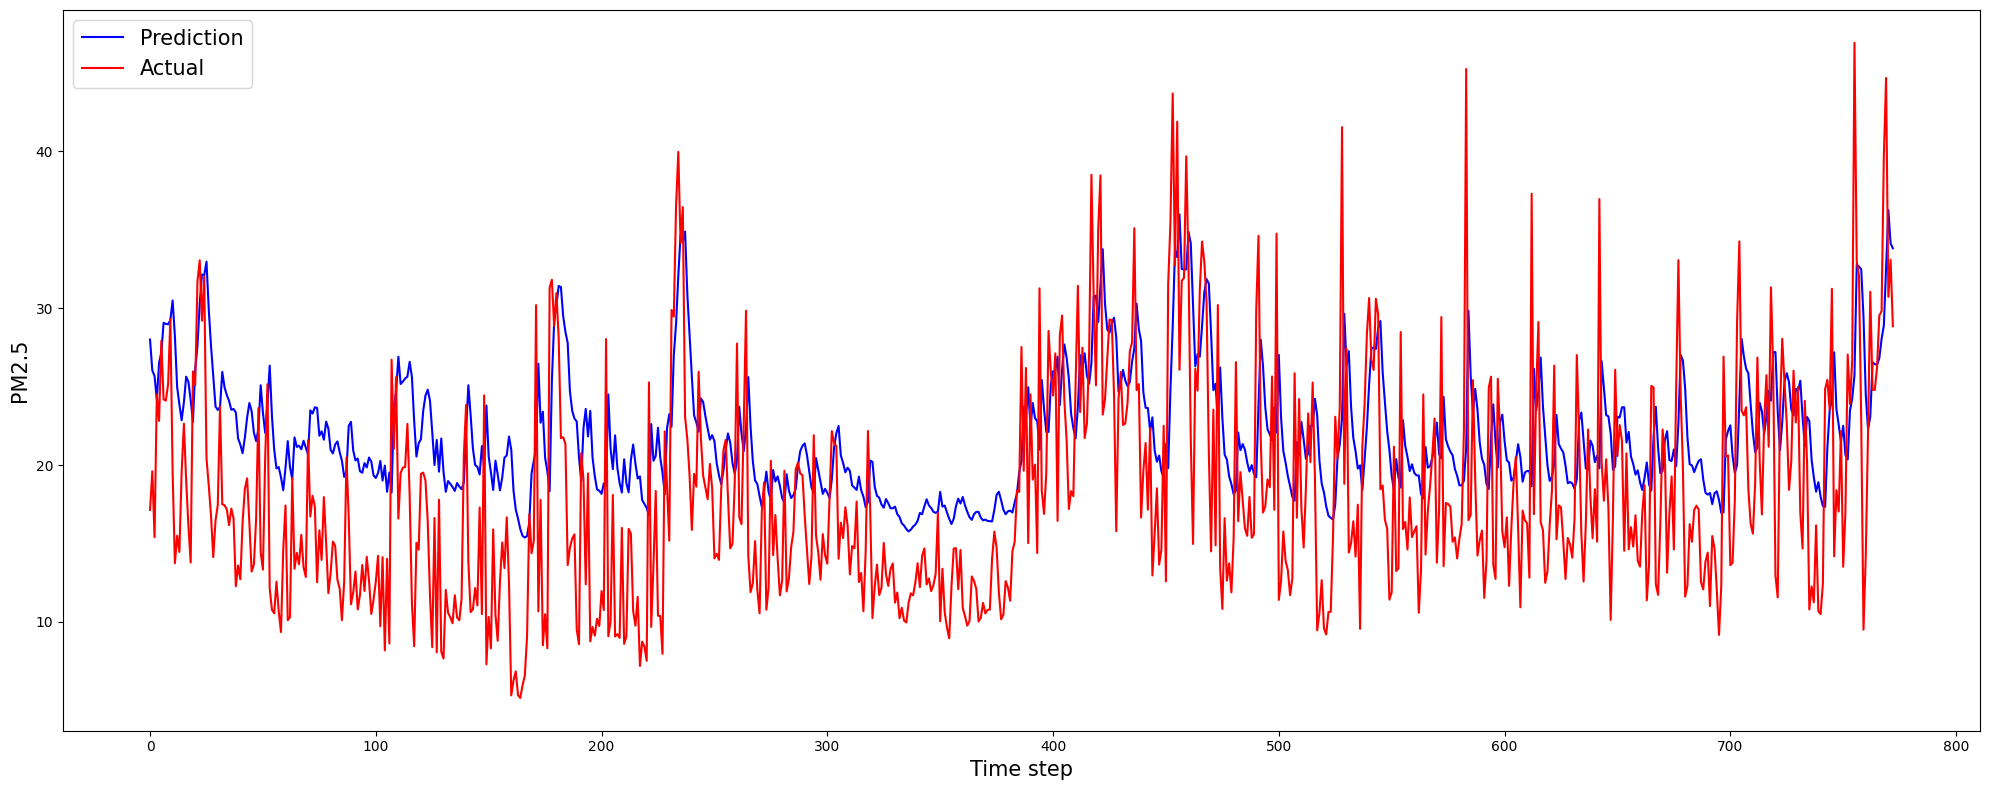

dim_reduction_method dim_after_reduction prediction       mae        mse  \
0                 None                 N/A       LSTM  4.526494  37.178583   
1         LSTM-Seq2Seq                  17       LSTM  6.028108  50.430684   

       rmse        r2      mape  
0  6.097424 -2.126817  0.272811  
1  7.101456 -2.259124  0.278865

In [110]:
loopresults = generate_loopresults(RANGE_OF_DIMENSION, LSTMSeq2SeqReduction, LSTMPrediction, X_aod_scaled, y_aod_scaled, aod_label_scaler)
best_metrics, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = choose_the_best(loopresults, metric_to_choose="mae")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
for metric, value in best_metrics.items():
    evaluation_board[metric] += [value]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [111]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_lstms2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_lstms2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_lstms2s_reduced_2021_2022.csv"))
df_lstms2s_reduced

aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2018-01-01       0.451671      -0.921644       0.571693       0.225302   
2018-01-02       0.451671      -0.921644       0.571693       0.225302   
2018-01-03       0.451081      -0.923555       0.572954       0.226499   
2018-01-04       0.450484      -0.930410       0.575512       0.230303   
2018-01-05       0.448871      -0.935987       0.577365       0.234627   
...                   ...            ...            ...            ...   
2022-12-27       0.472207      -0.552065       0.327258      -0.018190   
2022-12-28       0.468484      -0.553599       0.327100      -0.018830   
2022-12-29       0.463855      -0.549338       0.320207      -0.021126   
2022-12-30       0.462275      -0.549429       0.319719      -0.022944   
2022-12-31       0.465095      -0.549543       0.322924      -0.022754   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2018-01-01       0.870395       0.415683      -0.043594      -1.205209   
2018-01-02       0.870395       0.415683      -0.043594      -1.205209   
2018-01-03       0.871511       0.414902      -0.041977      -1.206554   
2018-01-04       0.875395       0.415358      -0.040262      -1.214453   
2018-01-05       0.881585       0.416848      -0.039791      -1.225088   
...                   ...            ...            ...            ...   
2022-12-27       0.057381      -0.057638       0.066302      -0.661147   
2022-12-28       0.061153      -0.055851       0.066667      -0.659715   
2022-12-29       0.060700      -0.056150       0.066298      -0.651669   
2022-12-30       0.063108      -0.054950       0.064094      -0.650206   
2022-12-31       0.061605      -0.056361       0.063609      -0.652601   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2018-01-01       1.097032        1.286488        0.408407        0.658620   
2018-01-02       1.097032        1.286488        0.408407        0.658620   
2018-01-03       1.098246        1.287116        0.410396        0.657953   
2018-01-04       1.103399        1.295168        0.413911        0.659302   
2018-01-05       1.108993        1.305034        0.416188        0.663256   
...                   ...             ...             ...             ...   
2022-12-27       0.713013        0.995496        0.588301        0.216589   
2022-12-28       0.710214        0.989804        0.586560        0.213989   
2022-12-29       0.704284        0.978738        0.582318        0.209016   
2022-12-30       0.699536        0.974856        0.578320        0.210421   
2022-12-31       0.701459        0.979196        0.579500        0.214291   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2018-01-01        1.241571       -1.325252       -0.143476       -0.315202   
2018-01-02        1.241571       -1.325252       -0.143476       -0.315202   
2018-01-03        1.243050       -1.325420       -0.144139       -0.315908   
2018-01-04        1.249518       -1.330727       -0.144805       -0.317972   
2018-01-05        1.259659       -1.339218       -0.146473       -0.321465   
...                    ...             ...             ...             ...   
2022-12-27        0.432990       -0.845854       -0.020212       -0.239699   
2022-12-28        0.432770       -0.843671       -0.019540       -0.240371   
2022-12-29        0.425518       -0.832892       -0.017736       -0.237915   
2022-12-30        0.427166       -0.830671       -0.018046       -0.236747   
2022-12-31        0.430403       -0.833686       -0.019024       -0.236803   

            aod_feature_17  station  
time                           

In [112]:
# Prepare the reduced data with additional pm25_3km and predicted pm25 values
df_lstms2s_reduced_augmented = augmentReducedData(df_lstms2s_reduced, y_aod_scaled, aod_pm25_3km_column, aod_label_scaler)
df_lstms2s_reduced_augmented.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_lstms2s_reduced_2021_2022_with_raw_pm25_3km_and_prediced_pm25.csv"))
df_lstms2s_reduced_augmented

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2018-01-01       0.451671      -0.921644       0.571693       0.225302   
2018-01-02       0.451671      -0.921644       0.571693       0.225302   
2018-01-03       0.451081      -0.923555       0.572954       0.226499   
2018-01-04       0.450484      -0.930410       0.575512       0.230303   
2018-01-05       0.448871      -0.935987       0.577365       0.234627   
...                   ...            ...            ...            ...   
2022-12-27       0.472207      -0.552065       0.327258      -0.018190   
2022-12-28       0.468484      -0.553599       0.327100      -0.018830   
2022-12-29       0.463855      -0.549338       0.320207      -0.021126   
2022-12-30       0.462275      -0.549429       0.319719      -0.022944   
2022-12-31       0.465095      -0.549543       0.322924      -0.022754   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2018-01-01       0.870395       0.415683      -0.043594      -1.205209   
2018-01-02       0.870395       0.415683      -0.043594      -1.205209   
2018-01-03       0.871511       0.414902      -0.041977      -1.206554   
2018-01-04       0.875395       0.415358      -0.040262      -1.214453   
2018-01-05       0.881585       0.416848      -0.039791      -1.225088   
...                   ...            ...            ...            ...   
2022-12-27       0.057381      -0.057638       0.066302      -0.661147   
2022-12-28       0.061153      -0.055851       0.066667      -0.659715   
2022-12-29       0.060700      -0.056150       0.066298      -0.651669   
2022-12-30       0.063108      -0.054950       0.064094      -0.650206   
2022-12-31       0.061605      -0.056361       0.063609      -0.652601   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2018-01-01       1.097032        1.286488        0.408407        0.658620   
2018-01-02       1.097032        1.286488        0.408407        0.658620   
2018-01-03       1.098246        1.287116        0.410396        0.657953   
2018-01-04       1.103399        1.295168        0.413911        0.659302   
2018-01-05       1.108993        1.305034        0.416188        0.663256   
...                   ...             ...             ...             ...   
2022-12-27       0.713013        0.995496        0.588301        0.216589   
2022-12-28       0.710214        0.989804        0.586560        0.213989   
2022-12-29       0.704284        0.978738        0.582318        0.209016   
2022-12-30       0.699536        0.974856        0.578320        0.210421   
2022-12-31       0.701459        0.979196        0.579500        0.214291   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2018-01-01        1.241571       -1.325252       -0.143476       -0.315202   
2018-01-02        1.241571       -1.325252       -0.143476       -0.315202   
2018-01-03        1.243050       -1.325420       -0.144139       -0.315908   
2018-01-04        1.249518       -1.330727       -0.144805       -0.317972   
2018-01-05        1.259659       -1.339218       -0.146473       -0.321465   
...                    ...             ...             ...             ...   
2022-12-27        0.432990       -0.845854       -0.020212       -0.239699   
2022-12-28        0.432770       -0.843671       -0.019540       -0.240371   
2022-12-29        0.425518       -0.832892       -0.017736       -0.237915   
2022-12-30        0.427166       -0.830671       -0.018046       -0.236747   
2022-12-31        0.430403       -0.833686       -0.019024       -0.236803   

            aod_feature_17  station   pm25_3km  hiep_predicted_pm25  

#### Compare MAE with pm25_3km

On test data:
MAE between actual and pm25_3km: 6.800208042080604
MAE between actual and predicted pm25: 6.0281079534622934
MSE between actual and pm25_3km: 87.55791124485947
MSE between actual and predicted pm25: 50.430684185647195


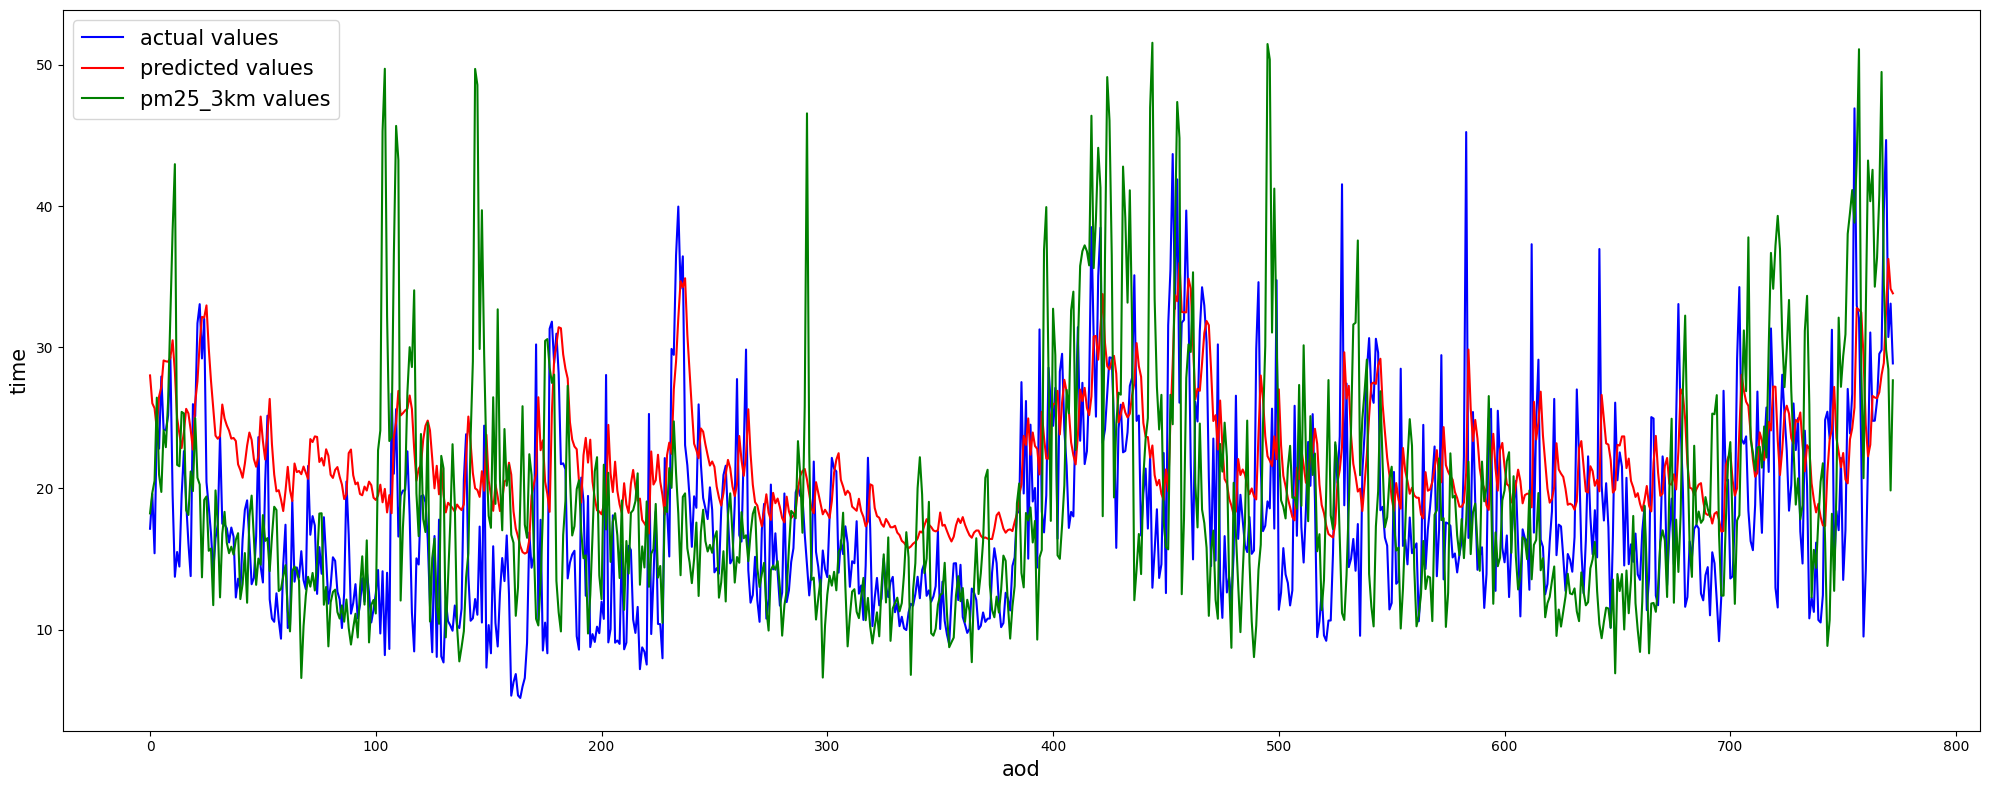

On entire data:
MAE between actual and pm25_3km: 7.875957292759844
MAE between actual and predicted pm25: 5.36738920211792


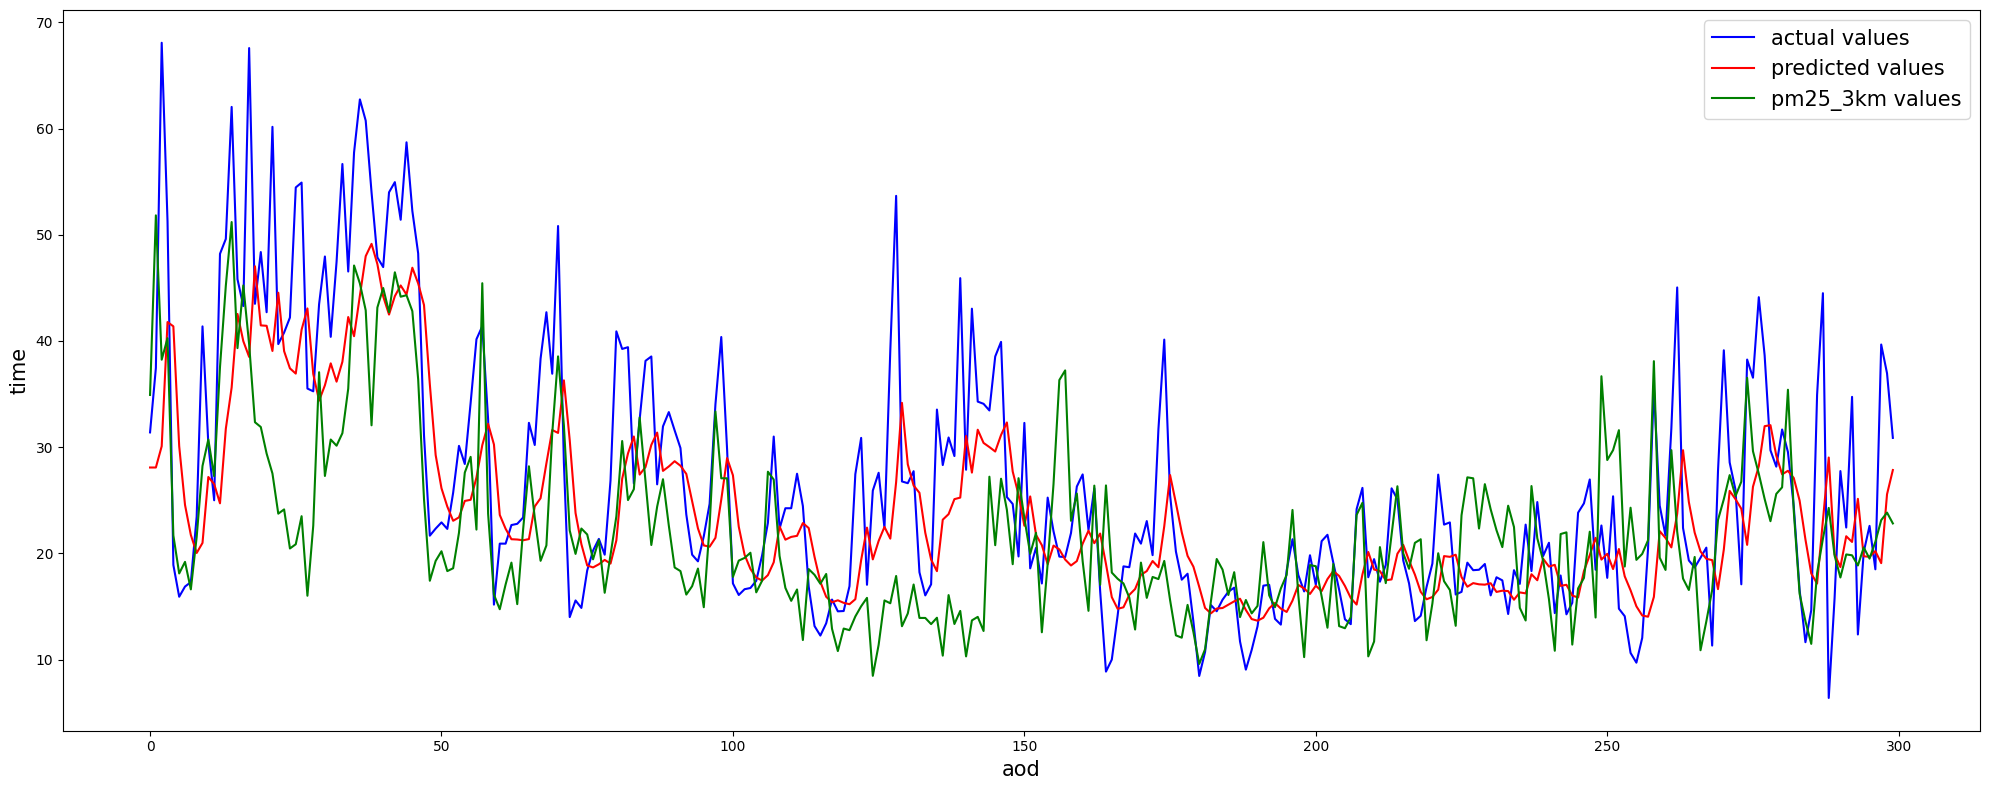

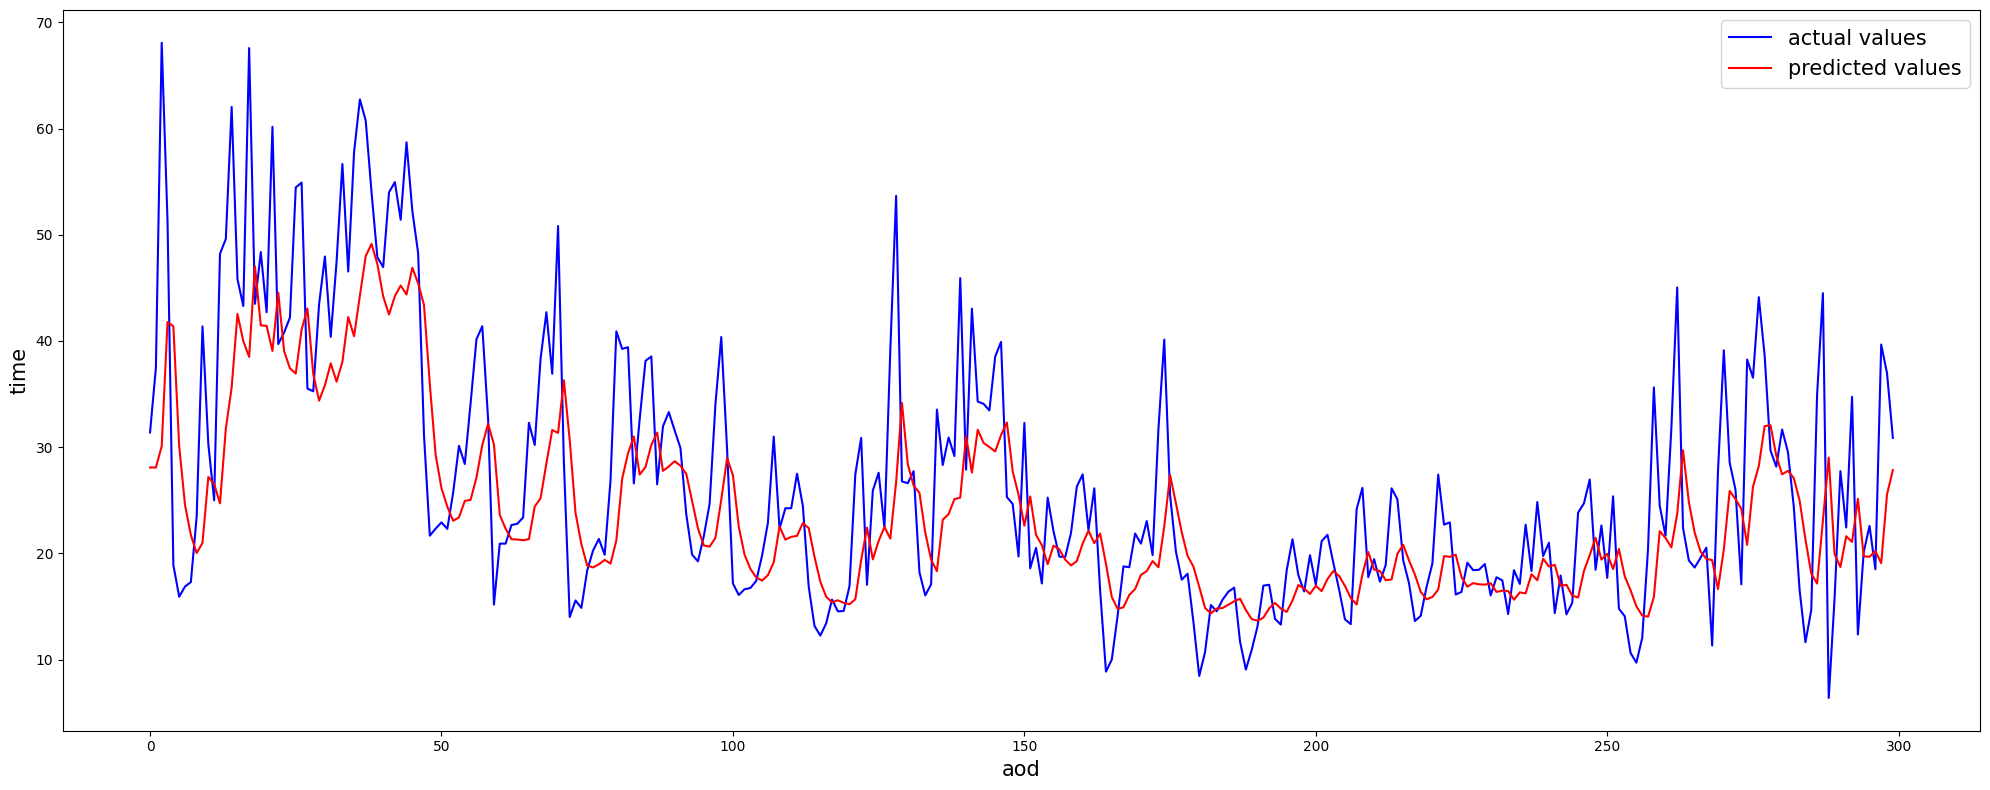

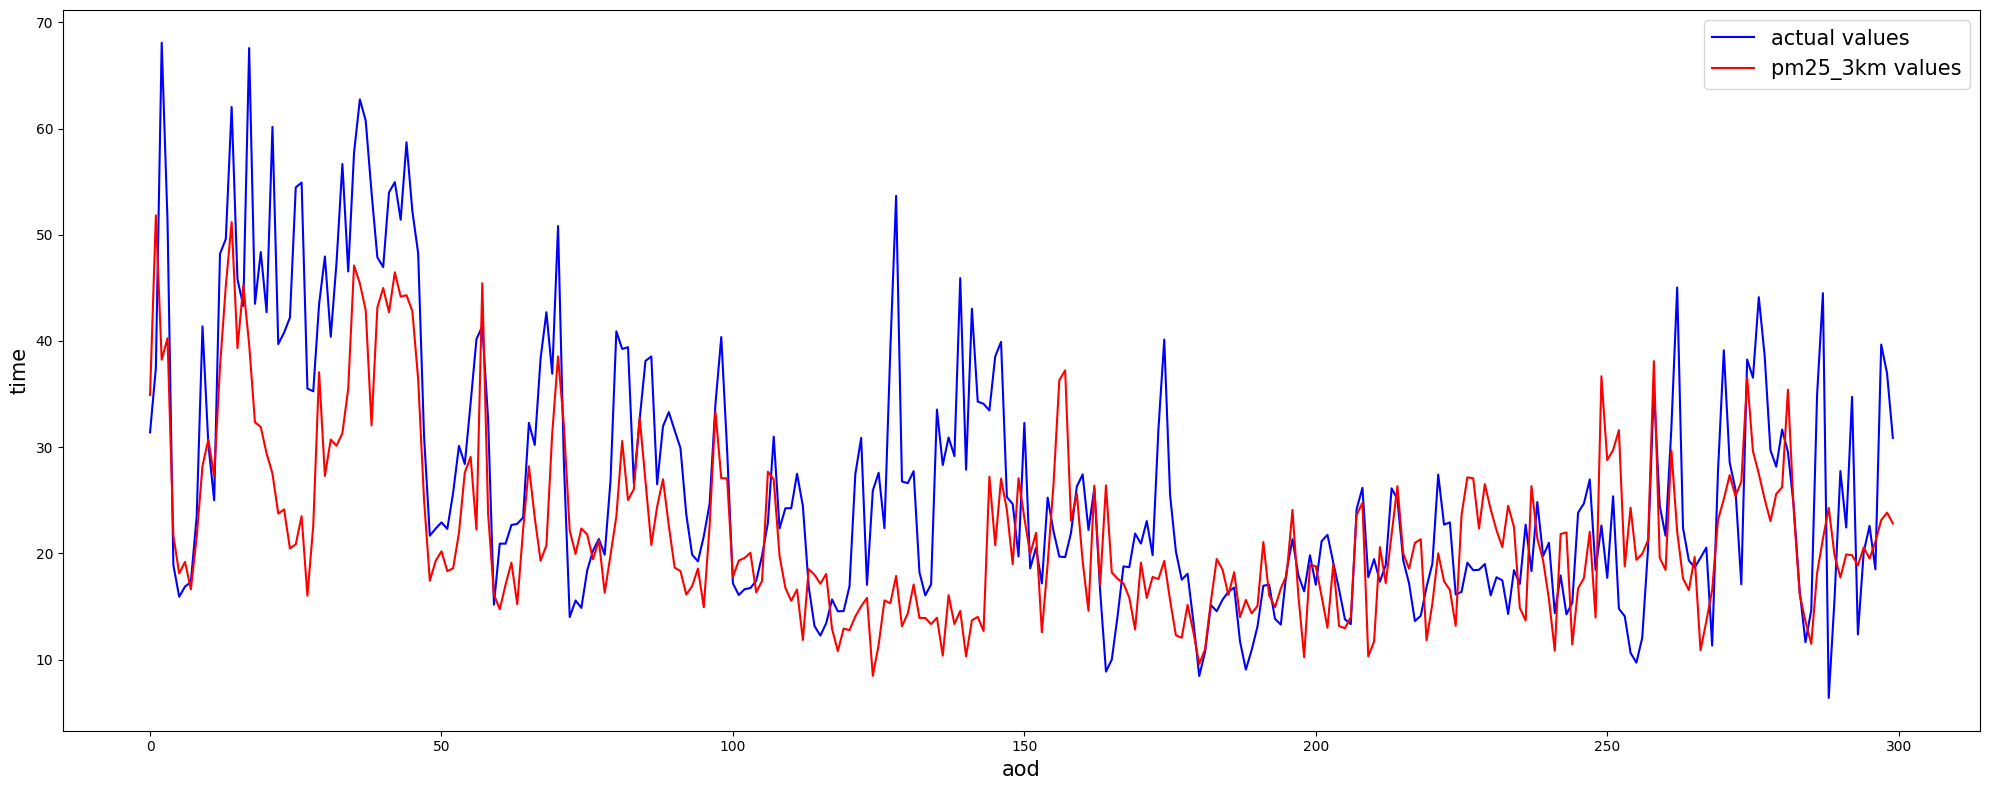

In [113]:
# Compare test set only
all_days_inv_y_pred, all_days_inv_y_test = best_evaluation_data
y_pred = all_days_inv_y_pred.reshape(-1, 1)
y_test = all_days_inv_y_test.reshape(-1, 1)
test_len = y_test.shape[0]
aod_pm25_3km_column_test = aod_pm25_3km_column.tail(test_len)
print("On test data:")
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_test, aod_pm25_3km_column_test)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE between actual and pm25_3km: {mean_squared_error(y_test, aod_pm25_3km_column_test)}")
print(f"MSE between actual and predicted pm25: {mean_squared_error(y_test, y_pred)}")
plot_3_data(data1=y_test,
           datalabel1="actual values",
           data2=y_pred,
           datalabel2="predicted values",
           data3=aod_pm25_3km_column_test,
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")

# Compare entire dataset
print("On entire data:")
y_pred_all = df_lstms2s_reduced_augmented["hiep_predicted_pm25"]
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_aod, aod_pm25_3km_column)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_aod, y_pred_all)}")
plot_3_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=y_pred_all.head(300),
           datalabel2="predicted values",
           data3=aod_pm25_3km_column.head(300),
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=y_pred_all.head(300),
           datalabel2="predicted values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=aod_pm25_3km_column.head(300),
           datalabel2="pm25_3km values",
           ylabel="time",
           xlabel="aod")

### Prediction + GRU-Seq2Seq

#### Doing the loop

Model: "aod_GRUSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_115     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_40 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_115[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_41 (GRU)        │ [(None, 50),      │     22,800 │ gru_40[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_163 (Dense)   │ (None, 13)        │        663 │ gru_41[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_90    │ (None, 7, 13)     │          0 │ dense_163[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_42 (GRU)        │ (None, 7, 50)     │      9,750 │ repeat_vector_90… │
│                     │                   │            │ gru_41[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_43 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_42[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │      1,818 │ gru_43[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 349,895 (1.33 MB)

 Trainable params: 116,631 (455.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 233,264 (911.19 KB)

None


Model: "aod_GRUSeq2SeqReduction_13_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_116 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_40 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_41 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,463 (232.28 KB)

 Trainable params: 59,463 (232.28 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_117     │ (None, 24, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_170 (LSTM)     │ [(None, 64),      │     20,224 │ input_layer_117[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_91    │ (None, 1, 64)     │          0 │ lstm_170[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_171 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_91… │
│                     │                   │            │ lstm_170[0][1],   │
│                     │                   │            │ lstm_170[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 1, 64)     │          0 │ lstm_171[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_45[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,361 (216.25 KB)

 Trainable params: 55,361 (216.25 KB)

 Non-trainable params: 0 (0.00 B)

None


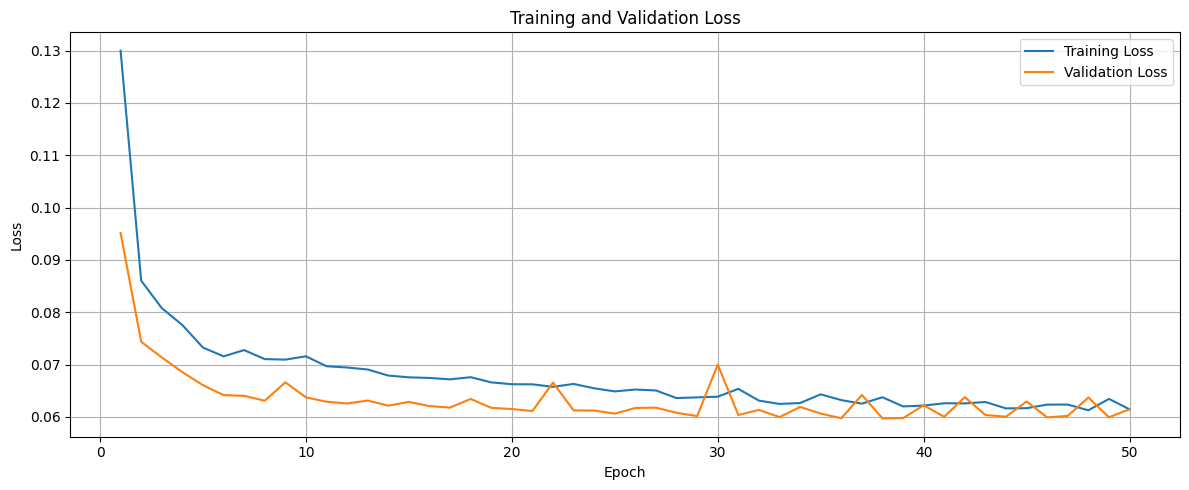

Model: "aod_GRUSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_118     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_44 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_118[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_45 (GRU)        │ [(None, 50),      │     22,800 │ gru_44[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_167 (Dense)   │ (None, 14)        │        714 │ gru_45[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_92    │ (None, 7, 14)     │          0 │ dense_167[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_46 (GRU)        │ (None, 7, 50)     │      9,900 │ repeat_vector_92… │
│                     │                   │            │ gru_45[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_47 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_46[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │      1,818 │ gru_47[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 350,498 (1.34 MB)

 Trainable params: 116,832 (456.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 233,666 (912.76 KB)

None


Model: "aod_GRUSeq2SeqReduction_14_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_119 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_44 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_45 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,514 (232.48 KB)

 Trainable params: 59,514 (232.48 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_120     │ (None, 24, 15)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_172 (LSTM)     │ [(None, 64),      │     20,480 │ input_layer_120[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_93    │ (None, 1, 64)     │          0 │ lstm_172[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_173 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_93… │
│                     │                   │            │ lstm_172[0][1],   │
│                     │                   │            │ lstm_172[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_46          │ (None, 1, 64)     │          0 │ lstm_173[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_46[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,617 (217.25 KB)

 Trainable params: 55,617 (217.25 KB)

 Non-trainable params: 0 (0.00 B)

None


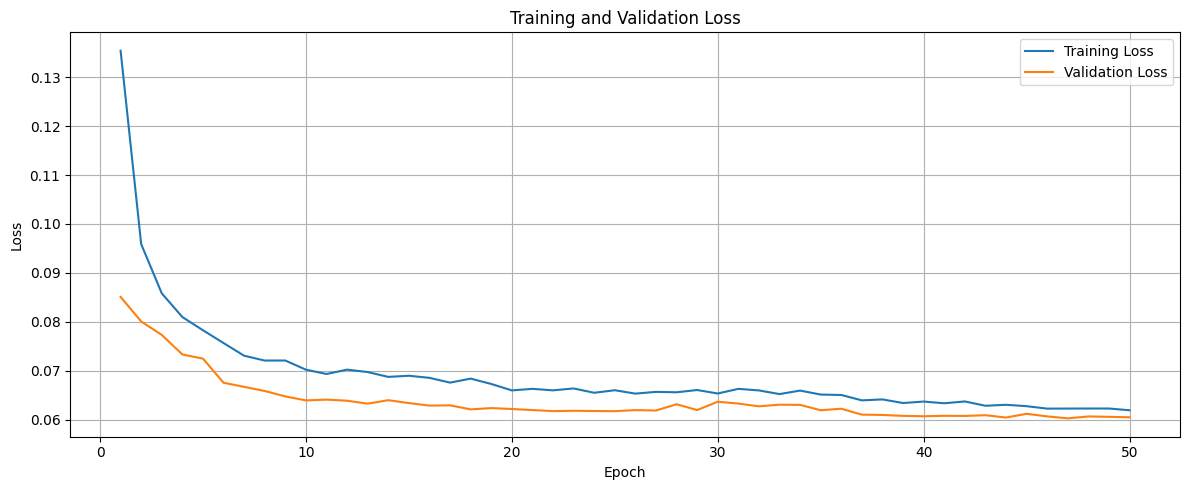

Model: "aod_GRUSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_121     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_48 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_121[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_49 (GRU)        │ [(None, 50),      │     22,800 │ gru_48[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_171 (Dense)   │ (None, 15)        │        765 │ gru_49[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_94    │ (None, 7, 15)     │          0 │ dense_171[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_50 (GRU)        │ (None, 7, 50)     │     10,050 │ repeat_vector_94… │
│                     │                   │            │ gru_49[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_51 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_50[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │      1,818 │ gru_51[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 351,101 (1.34 MB)

 Trainable params: 117,033 (457.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,068 (914.33 KB)

None


Model: "aod_GRUSeq2SeqReduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_122 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_48 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_49 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,565 (232.68 KB)

 Trainable params: 59,565 (232.68 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_123     │ (None, 24, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_174 (LSTM)     │ [(None, 64),      │     20,736 │ input_layer_123[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_95    │ (None, 1, 64)     │          0 │ lstm_174[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_175 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_95… │
│                     │                   │            │ lstm_174[0][1],   │
│                     │                   │            │ lstm_174[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 1, 64)     │          0 │ lstm_175[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_47[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,873 (218.25 KB)

 Trainable params: 55,873 (218.25 KB)

 Non-trainable params: 0 (0.00 B)

None


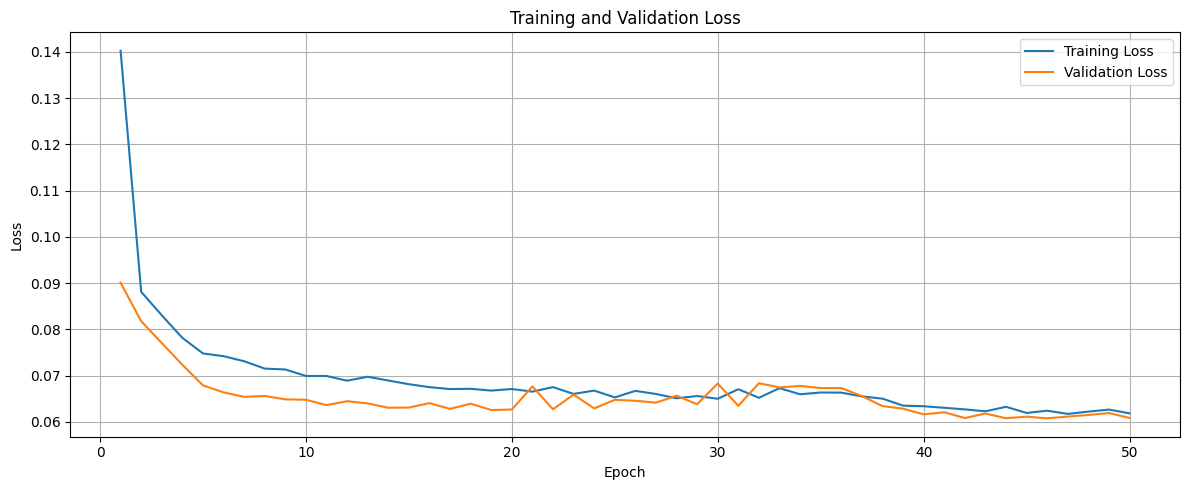

Model: "aod_GRUSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_124     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_52 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_124[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_53 (GRU)        │ [(None, 50),      │     22,800 │ gru_52[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_175 (Dense)   │ (None, 16)        │        816 │ gru_53[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_96    │ (None, 7, 16)     │          0 │ dense_175[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_54 (GRU)        │ (None, 7, 50)     │     10,200 │ repeat_vector_96… │
│                     │                   │            │ gru_53[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_55 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_54[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │      1,818 │ gru_55[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 351,704 (1.34 MB)

 Trainable params: 117,234 (457.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,470 (915.90 KB)

None


Model: "aod_GRUSeq2SeqReduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_125 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_52 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_53 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_175 (Dense)               │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,616 (232.88 KB)

 Trainable params: 59,616 (232.88 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_126     │ (None, 24, 17)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_176 (LSTM)     │ [(None, 64),      │     20,992 │ input_layer_126[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_97    │ (None, 1, 64)     │          0 │ lstm_176[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_177 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_97… │
│                     │                   │            │ lstm_176[0][1],   │
│                     │                   │            │ lstm_176[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 1, 64)     │          0 │ lstm_177[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_48[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,129 (219.25 KB)

 Trainable params: 56,129 (219.25 KB)

 Non-trainable params: 0 (0.00 B)

None


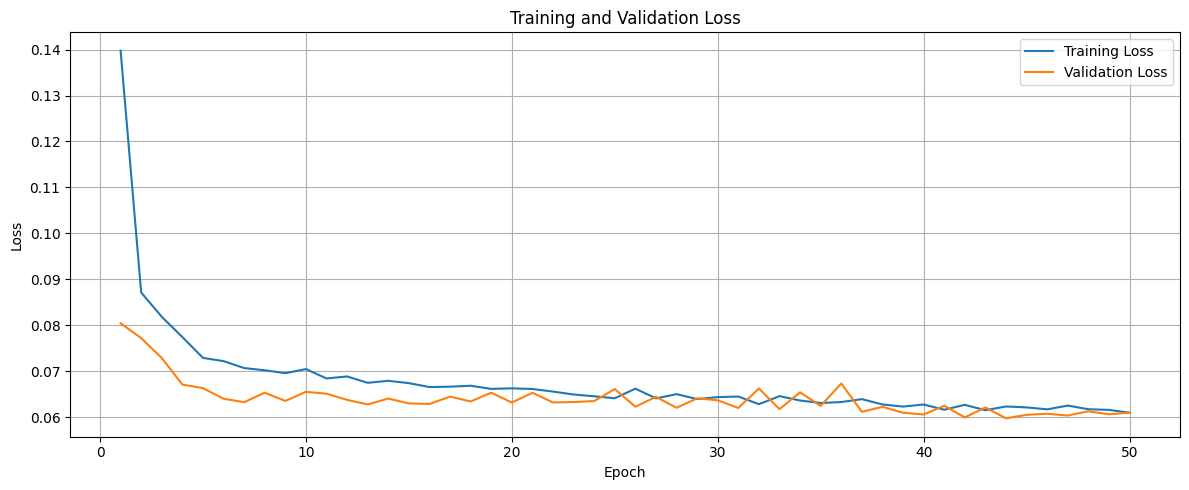

Model: "aod_GRUSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_127     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_56 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_127[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_57 (GRU)        │ [(None, 50),      │     22,800 │ gru_56[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_179 (Dense)   │ (None, 17)        │        867 │ gru_57[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_98    │ (None, 7, 17)     │          0 │ dense_179[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_58 (GRU)        │ (None, 7, 50)     │     10,350 │ repeat_vector_98… │
│                     │                   │            │ gru_57[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_59 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_58[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │      1,818 │ gru_59[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 352,307 (1.34 MB)

 Trainable params: 117,435 (458.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,872 (917.47 KB)

None


Model: "aod_GRUSeq2SeqReduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_128 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_56 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_57 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,667 (233.07 KB)

 Trainable params: 59,667 (233.07 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_129     │ (None, 24, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_178 (LSTM)     │ [(None, 64),      │     21,248 │ input_layer_129[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_99    │ (None, 1, 64)     │          0 │ lstm_178[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_179 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_99… │
│                     │                   │            │ lstm_178[0][1],   │
│                     │                   │            │ lstm_178[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_49          │ (None, 1, 64)     │          0 │ lstm_179[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_49[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,385 (220.25 KB)

 Trainable params: 56,385 (220.25 KB)

 Non-trainable params: 0 (0.00 B)

None


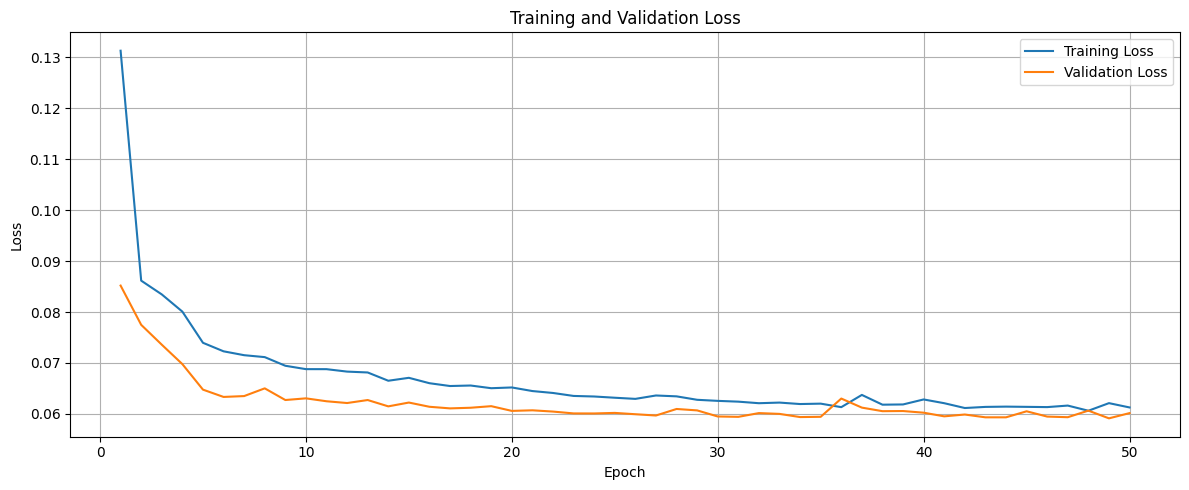

Choosing the best result

dict_keys([13, 14, 15, 16, 17])
N = 13
mae = 4.226102051650687
mse = 30.73939589882764
rmse = 5.544312031156584
r2 = -0.4639259390578454
mape = 0.22945759548654746
N = 14
mae = 4.011778640180603
mse = 30.887288061339994
rmse = 5.557633314760879
r2 = -0.49680930803693624
mape = 0.2374023539571518
N = 15
mae = 3.999724792617614
mse = 30.166082481177565
rmse = 5.492365836429467
r2 = -0.638459618688098
mape = 0.23469917549145491
N = 16
mae = 4.235556406558945
mse = 30.576779151797325
rmse = 5.529627397193894
r2 = -0.5034805721330213
mape = 0.2303108424098771
N = 17
mae = 3.986179340212826
mse = 30.871965819607894
rmse = 5.556254657555564
r2 = -0.8386476909972205
mape = 0.23865626656246128


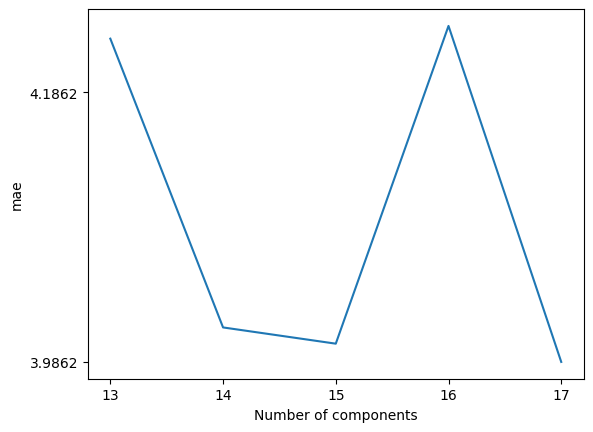

inv_y_pred.shape = (773, 1)
inv_y_test.shape = (773, 1)


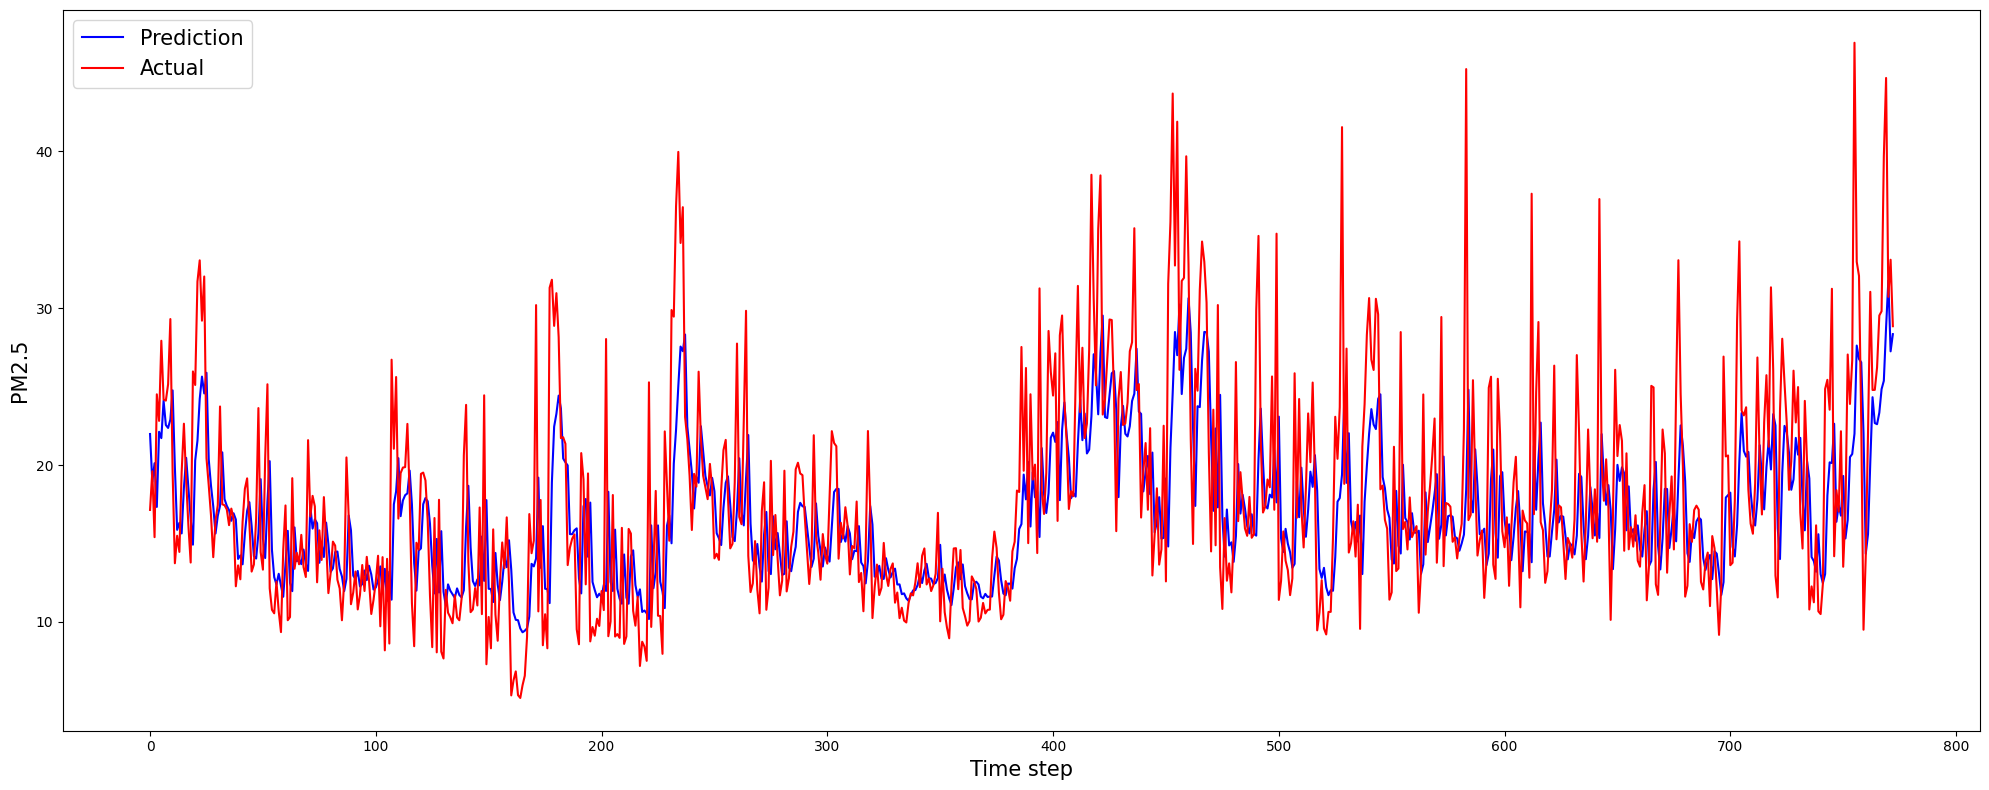

dim_reduction_method dim_after_reduction prediction       mae        mse  \
0                 None                 N/A       LSTM  4.526494  37.178583   
1         LSTM-Seq2Seq                  17       LSTM  6.028108  50.430684   
2          GRU-Seq2Seq                  17       LSTM  3.986179  30.871966   

       rmse        r2      mape  
0  6.097424 -2.126817  0.272811  
1  7.101456 -2.259124  0.278865  
2  5.556255 -0.838648  0.238656

In [114]:
loopresults = generate_loopresults(RANGE_OF_DIMENSION, GRUSeq2SeqReduction, LSTMPrediction, X_aod_scaled, y_aod_scaled, aod_label_scaler)
best_metrics, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = choose_the_best(loopresults, metric_to_choose="mae")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["GRU-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
for metric, value in best_metrics.items():
    evaluation_board[metric] += [value]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [115]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_grus2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_grus2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_grus2s_reduced_2021_2022.csv"))
df_grus2s_reduced

aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2018-01-01       0.023853       0.026642       0.049428       0.153560   
2018-01-02       0.023853       0.026642       0.049428       0.153560   
2018-01-03       0.023713       0.026604       0.049245       0.154127   
2018-01-04       0.023290       0.026363       0.048594       0.156375   
2018-01-05       0.022832       0.026008       0.048523       0.158190   
...                   ...            ...            ...            ...   
2022-12-27       0.027552       0.076028       0.030625       0.142259   
2022-12-28       0.027435       0.076126       0.030797       0.141974   
2022-12-29       0.027538       0.076500       0.030645       0.142195   
2022-12-30       0.027668       0.075706       0.030788       0.142369   
2022-12-31       0.027788       0.076061       0.030426       0.142375   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2018-01-01       0.097310       0.053756       0.017816       0.029089   
2018-01-02       0.097310       0.053756       0.017816       0.029089   
2018-01-03       0.097461       0.053541       0.017709       0.028994   
2018-01-04       0.097519       0.053167       0.017399       0.028520   
2018-01-05       0.096948       0.052899       0.017065       0.027906   
...                   ...            ...            ...            ...   
2022-12-27       0.058832       0.052945       0.035946       0.024732   
2022-12-28       0.058340       0.052785       0.035962       0.024675   
2022-12-29       0.058280       0.052800       0.036012       0.024708   
2022-12-30       0.058597       0.053326       0.036168       0.024598   
2022-12-31       0.058661       0.053157       0.036304       0.024719   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2018-01-01       0.038060        0.012138        0.037729        0.046966   
2018-01-02       0.038060        0.012138        0.037729        0.046966   
2018-01-03       0.037924        0.012044        0.037661        0.046990   
2018-01-04       0.037644        0.011797        0.037247        0.046684   
2018-01-05       0.037249        0.011551        0.036815        0.045986   
...                   ...             ...             ...             ...   
2022-12-27       0.043250        0.026855        0.030125        0.101653   
2022-12-28       0.043435        0.026910        0.030172        0.101433   
2022-12-29       0.043608        0.027048        0.030103        0.101753   
2022-12-30       0.043808        0.027078        0.030252        0.100478   
2022-12-31       0.043846        0.027037        0.030038        0.101320   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2018-01-01        0.156034        0.049295        0.059583        0.111748   
2018-01-02        0.156034        0.049295        0.059583        0.111748   
2018-01-03        0.156353        0.049155        0.059360        0.112181   
2018-01-04        0.157351        0.048795        0.058843        0.113717   
2018-01-05        0.159618        0.048560        0.058592        0.114945   
...                    ...             ...             ...             ...   
2022-12-27        0.087377        0.091810        0.060047        0.058305   
2022-12-28        0.087644        0.091751        0.060251        0.058407   
2022-12-29        0.086740        0.091787        0.060118        0.058234   
2022-12-30        0.086901        0.091613        0.060302        0.058663   
2022-12-31        0.086288        0.092028        0.059752        0.058465   

            aod_feature_17  station  
time                           

In [116]:
# Prepare the reduced data with additional pm25_3km and predicted pm25 values
df_grus2s_reduced_augmented = augmentReducedData(df_grus2s_reduced, y_aod_scaled, aod_pm25_3km_column, aod_label_scaler)
df_grus2s_reduced_augmented.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_grus2s_reduced_2021_2022_with_raw_pm25_3km_and_prediced_pm25.csv"))
df_grus2s_reduced_augmented

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2018-01-01       0.023853       0.026642       0.049428       0.153560   
2018-01-02       0.023853       0.026642       0.049428       0.153560   
2018-01-03       0.023713       0.026604       0.049245       0.154127   
2018-01-04       0.023290       0.026363       0.048594       0.156375   
2018-01-05       0.022832       0.026008       0.048523       0.158190   
...                   ...            ...            ...            ...   
2022-12-27       0.027552       0.076028       0.030625       0.142259   
2022-12-28       0.027435       0.076126       0.030797       0.141974   
2022-12-29       0.027538       0.076500       0.030645       0.142195   
2022-12-30       0.027668       0.075706       0.030788       0.142369   
2022-12-31       0.027788       0.076061       0.030426       0.142375   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2018-01-01       0.097310       0.053756       0.017816       0.029089   
2018-01-02       0.097310       0.053756       0.017816       0.029089   
2018-01-03       0.097461       0.053541       0.017709       0.028994   
2018-01-04       0.097519       0.053167       0.017399       0.028520   
2018-01-05       0.096948       0.052899       0.017065       0.027906   
...                   ...            ...            ...            ...   
2022-12-27       0.058832       0.052945       0.035946       0.024732   
2022-12-28       0.058340       0.052785       0.035962       0.024675   
2022-12-29       0.058280       0.052800       0.036012       0.024708   
2022-12-30       0.058597       0.053326       0.036168       0.024598   
2022-12-31       0.058661       0.053157       0.036304       0.024719   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2018-01-01       0.038060        0.012138        0.037729        0.046966   
2018-01-02       0.038060        0.012138        0.037729        0.046966   
2018-01-03       0.037924        0.012044        0.037661        0.046990   
2018-01-04       0.037644        0.011797        0.037247        0.046684   
2018-01-05       0.037249        0.011551        0.036815        0.045986   
...                   ...             ...             ...             ...   
2022-12-27       0.043250        0.026855        0.030125        0.101653   
2022-12-28       0.043435        0.026910        0.030172        0.101433   
2022-12-29       0.043608        0.027048        0.030103        0.101753   
2022-12-30       0.043808        0.027078        0.030252        0.100478   
2022-12-31       0.043846        0.027037        0.030038        0.101320   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2018-01-01        0.156034        0.049295        0.059583        0.111748   
2018-01-02        0.156034        0.049295        0.059583        0.111748   
2018-01-03        0.156353        0.049155        0.059360        0.112181   
2018-01-04        0.157351        0.048795        0.058843        0.113717   
2018-01-05        0.159618        0.048560        0.058592        0.114945   
...                    ...             ...             ...             ...   
2022-12-27        0.087377        0.091810        0.060047        0.058305   
2022-12-28        0.087644        0.091751        0.060251        0.058407   
2022-12-29        0.086740        0.091787        0.060118        0.058234   
2022-12-30        0.086901        0.091613        0.060302        0.058663   
2022-12-31        0.086288        0.092028        0.059752        0.058465   

            aod_feature_17  station   pm25_3km  hiep_predicted_pm25  

#### Compare MAE with pm25_3km

On test data:
MAE between actual and pm25_3km: 6.800208042080604
MAE between actual and predicted pm25: 3.986179340212826
MSE between actual and pm25_3km: 87.55791124485947
MSE between actual and predicted pm25: 30.871965819607894


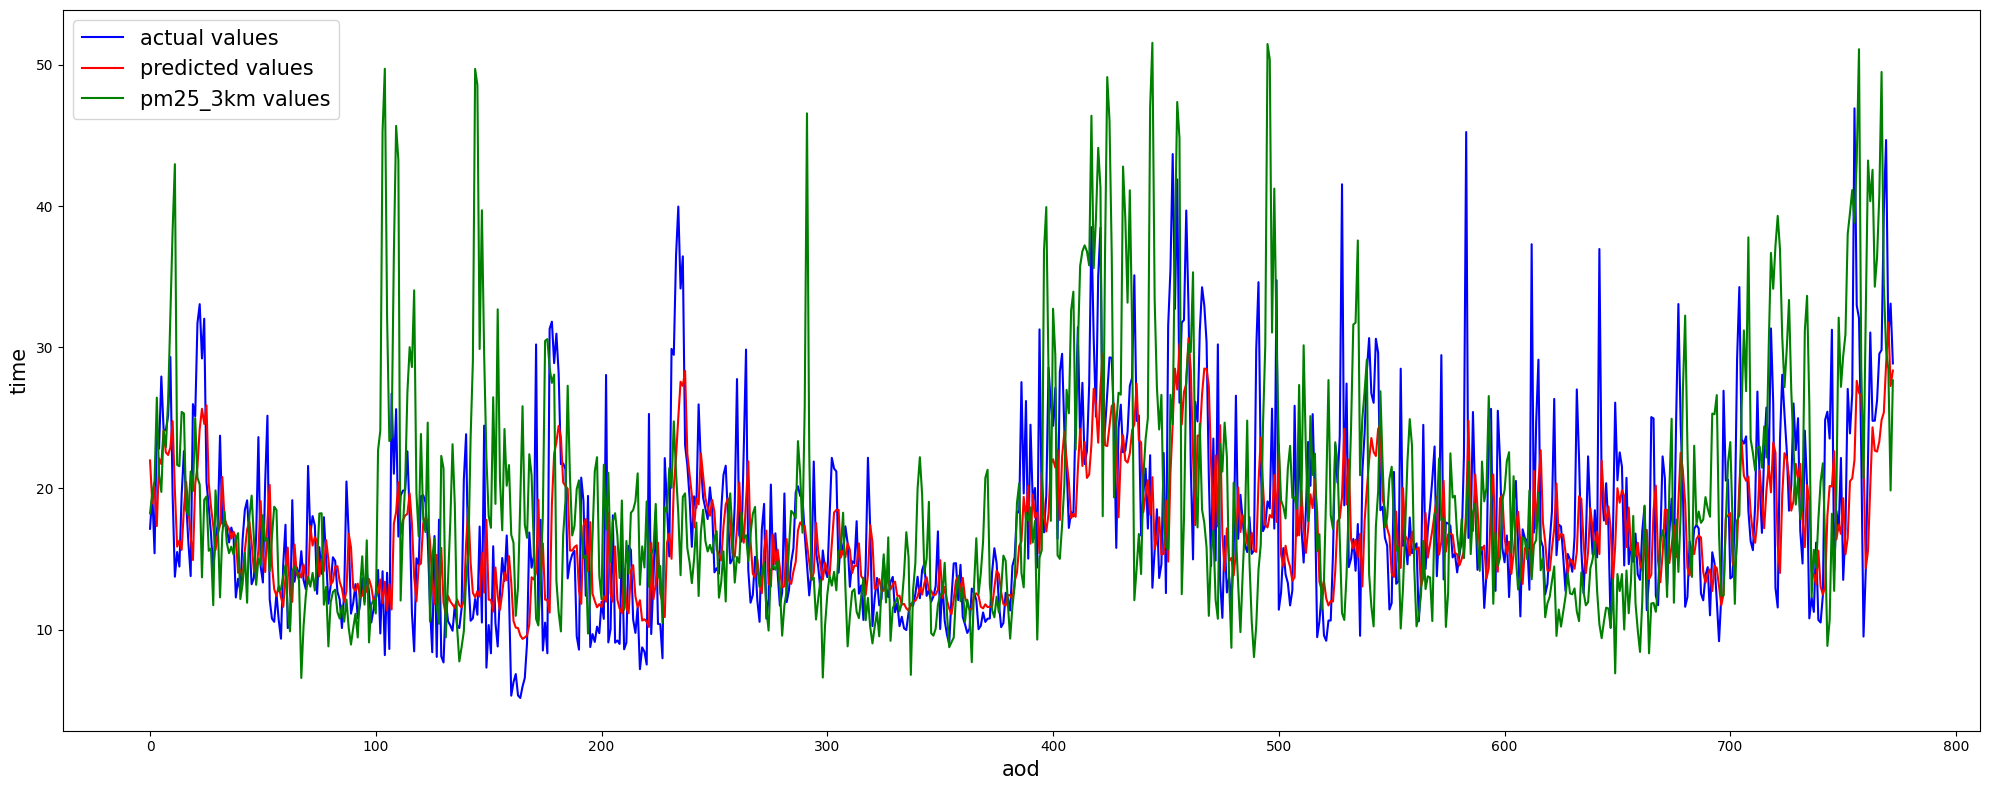

On entire data:
MAE between actual and pm25_3km: 7.875957292759844
MAE between actual and predicted pm25: 5.221305847167969


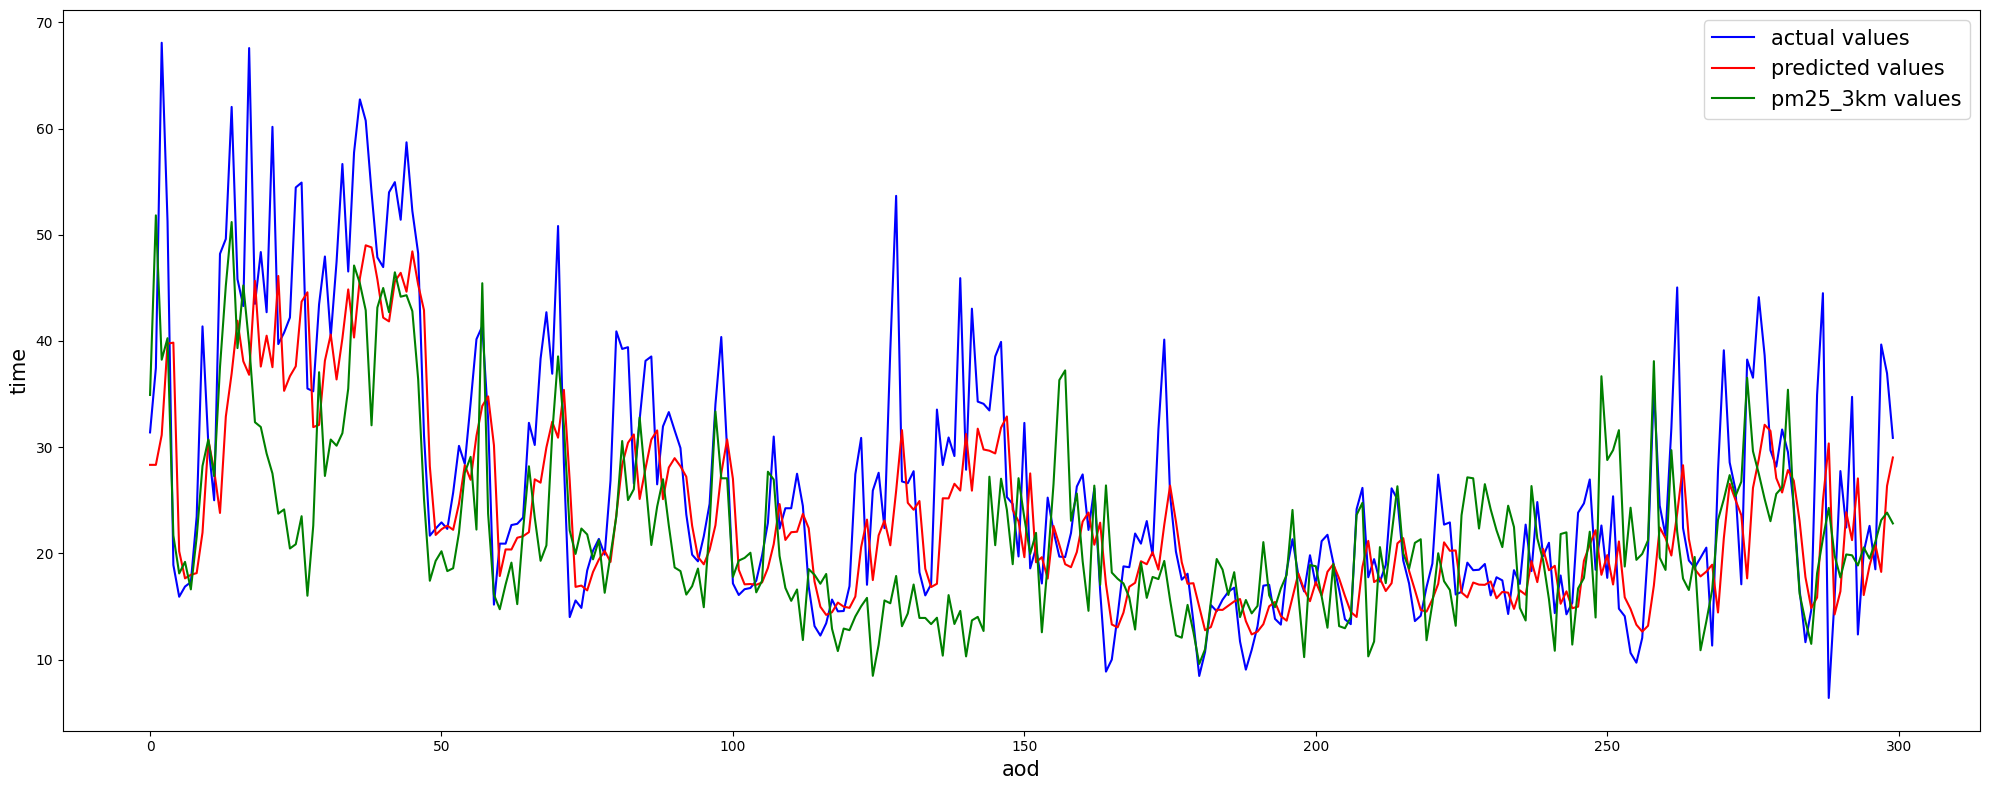

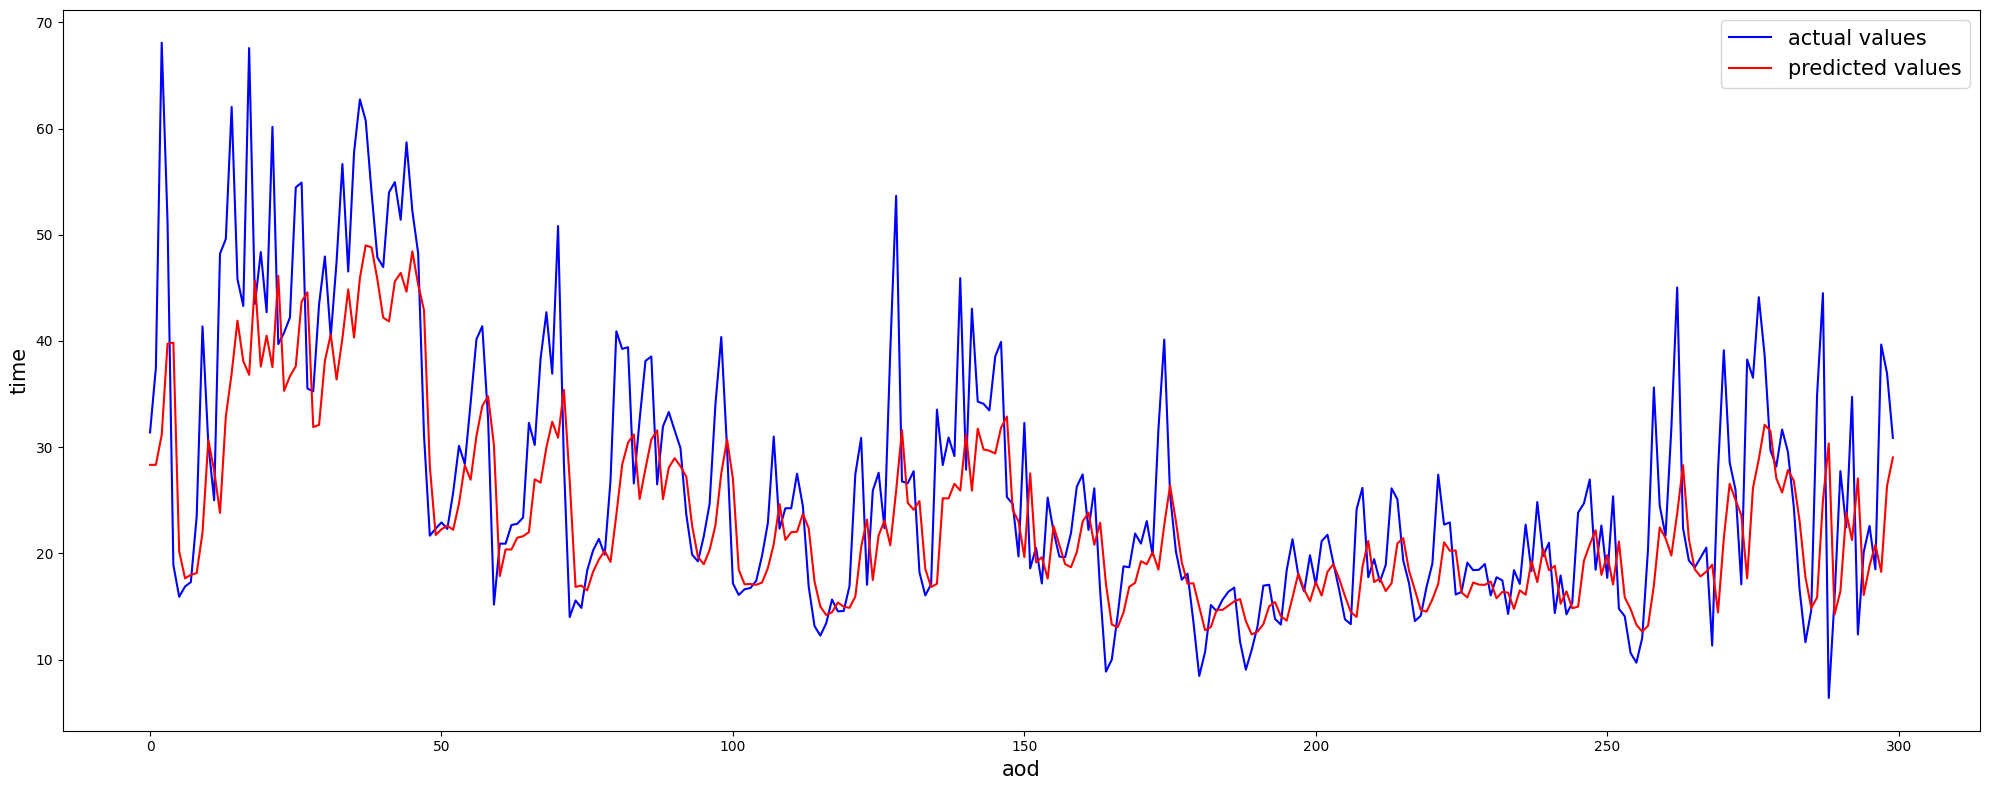

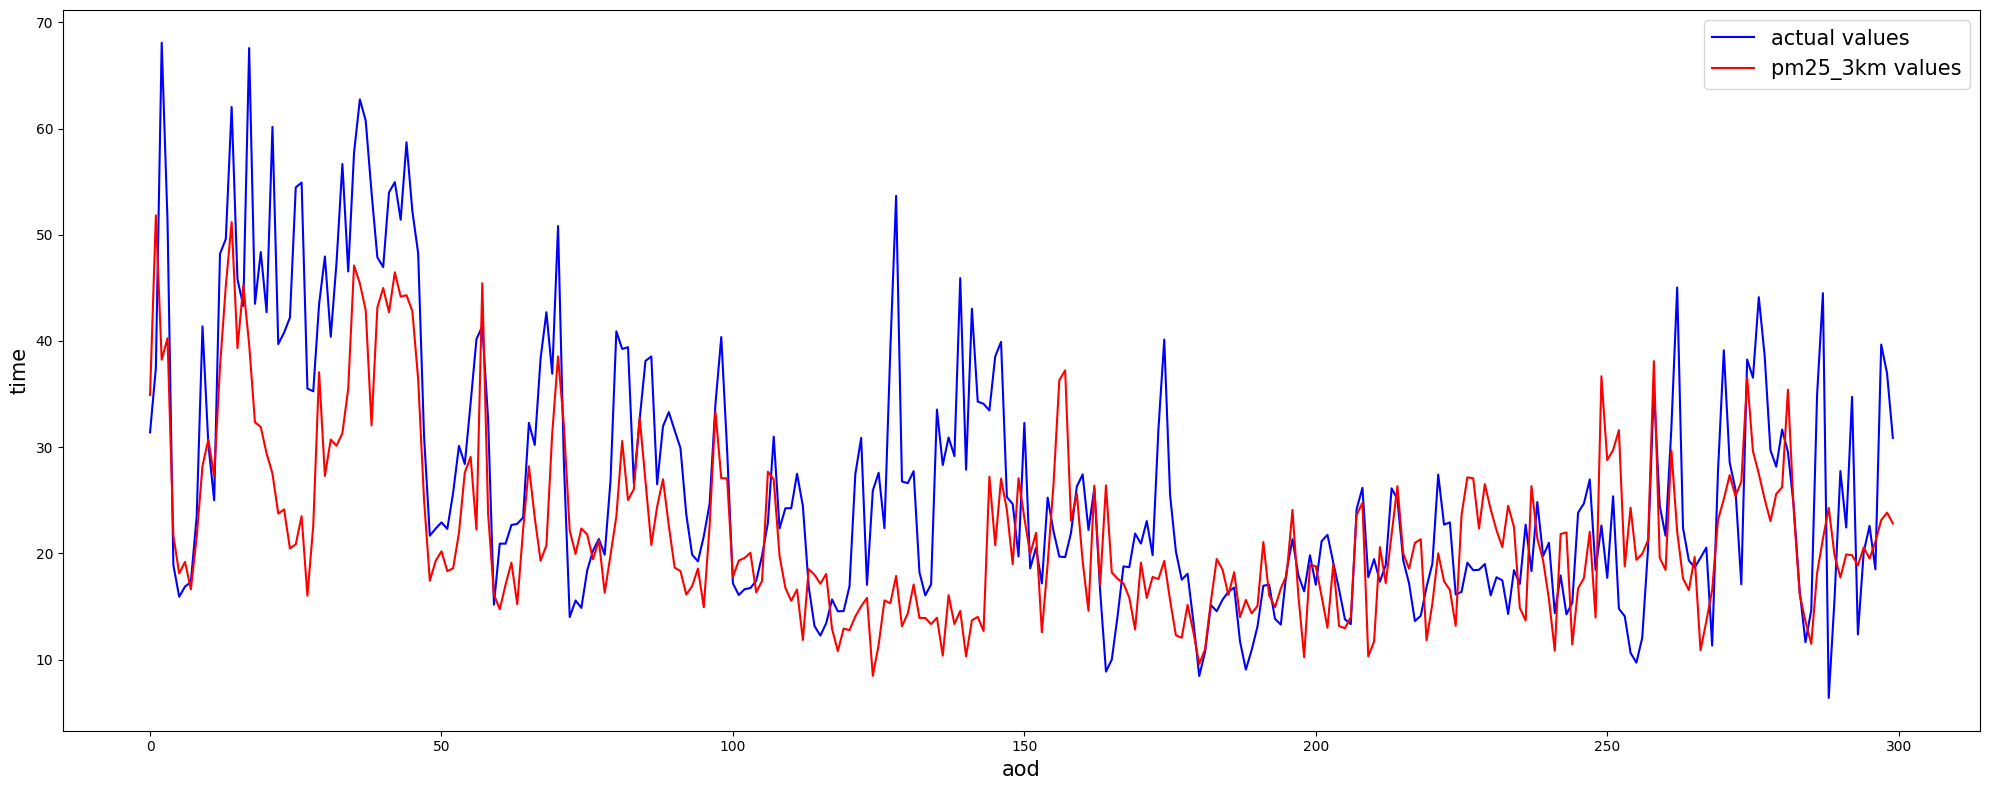

In [117]:
# Compare test set only
all_days_inv_y_pred, all_days_inv_y_test = best_evaluation_data
y_pred = all_days_inv_y_pred.reshape(-1, 1)
y_test = all_days_inv_y_test.reshape(-1, 1)
test_len = y_test.shape[0]
aod_pm25_3km_column_test = aod_pm25_3km_column.tail(test_len)
print("On test data:")
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_test, aod_pm25_3km_column_test)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE between actual and pm25_3km: {mean_squared_error(y_test, aod_pm25_3km_column_test)}")
print(f"MSE between actual and predicted pm25: {mean_squared_error(y_test, y_pred)}")
plot_3_data(data1=y_test,
           datalabel1="actual values",
           data2=y_pred,
           datalabel2="predicted values",
           data3=aod_pm25_3km_column_test,
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")

# Compare entire dataset
print("On entire data:")
y_pred_all = df_grus2s_reduced_augmented["hiep_predicted_pm25"]
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_aod, aod_pm25_3km_column)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_aod, y_pred_all)}")
plot_3_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=y_pred_all.head(300),
           datalabel2="predicted values",
           data3=aod_pm25_3km_column.head(300),
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=y_pred_all.head(300),
           datalabel2="predicted values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=aod_pm25_3km_column.head(300),
           datalabel2="pm25_3km values",
           ylabel="time",
           xlabel="aod")

### Prediction + CNN-LSTM Seq2seq

#### Doing the loop

Model: "aod_CNNLSTMSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_131     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 5, 24)     │      1,320 │ input_layer_131[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 1, 12)     │          0 │ conv1d_21[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 12)        │          0 │ max_pooling1d_10… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_101   │ (None, 7, 12)     │          0 │ flatten_10[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_182 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_10… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_184 (Dense)   │ (None, 13)        │        663 │ lstm_182[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_102   │ (None, 7, 13)     │          0 │ dense_184[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_183 (LSTM)     │ (None, 7, 50)     │     12,800 │ repeat_vector_10… │
│                     │                   │            │ lstm_182[0][1],   │
│                     │                   │            │ lstm_182[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_183[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,801 (350.79 KB)

 Trainable params: 29,933 (116.93 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 59,868 (233.86 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_13_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_132 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_101               │ (None, 7, 12)          │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_182 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,459 (60.39 KB)

 Trainable params: 15,459 (60.39 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_133     │ (None, 24, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_184 (LSTM)     │ [(None, 64),      │     20,224 │ input_layer_133[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_103   │ (None, 1, 64)     │          0 │ lstm_184[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_185 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_10… │
│                     │                   │            │ lstm_184[0][1],   │
│                     │                   │            │ lstm_184[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_51          │ (None, 1, 64)     │          0 │ lstm_185[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_51[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,361 (216.25 KB)

 Trainable params: 55,361 (216.25 KB)

 Non-trainable params: 0 (0.00 B)

None


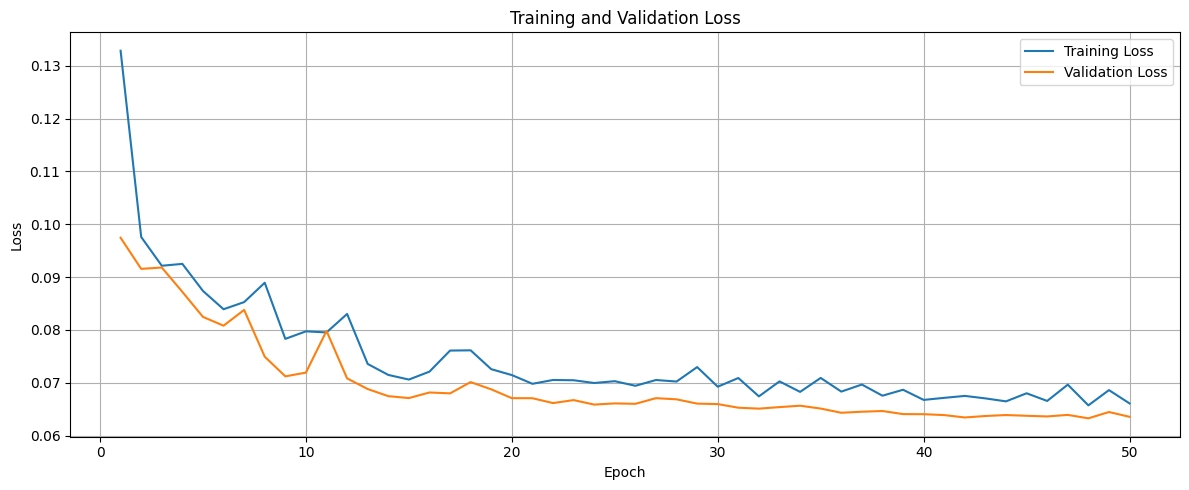

Model: "aod_CNNLSTMSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_134     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 5, 24)     │      1,320 │ input_layer_134[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 1, 12)     │          0 │ conv1d_23[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 12)        │          0 │ max_pooling1d_11… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_104   │ (None, 7, 12)     │          0 │ flatten_11[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_186 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_10… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_189 (Dense)   │ (None, 14)        │        714 │ lstm_186[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_105   │ (None, 7, 14)     │          0 │ dense_189[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_187 (LSTM)     │ (None, 7, 50)     │     13,000 │ repeat_vector_10… │
│                     │                   │            │ lstm_186[0][1],   │
│                     │                   │            │ lstm_186[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_187[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 90,554 (353.73 KB)

 Trainable params: 30,184 (117.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 60,370 (235.82 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_14_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_135 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_104               │ (None, 7, 12)          │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_186 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_189 (Dense)               │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,510 (60.59 KB)

 Trainable params: 15,510 (60.59 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_136     │ (None, 24, 15)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_188 (LSTM)     │ [(None, 64),      │     20,480 │ input_layer_136[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_106   │ (None, 1, 64)     │          0 │ lstm_188[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_189 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_10… │
│                     │                   │            │ lstm_188[0][1],   │
│                     │                   │            │ lstm_188[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_52          │ (None, 1, 64)     │          0 │ lstm_189[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_52[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,617 (217.25 KB)

 Trainable params: 55,617 (217.25 KB)

 Non-trainable params: 0 (0.00 B)

None


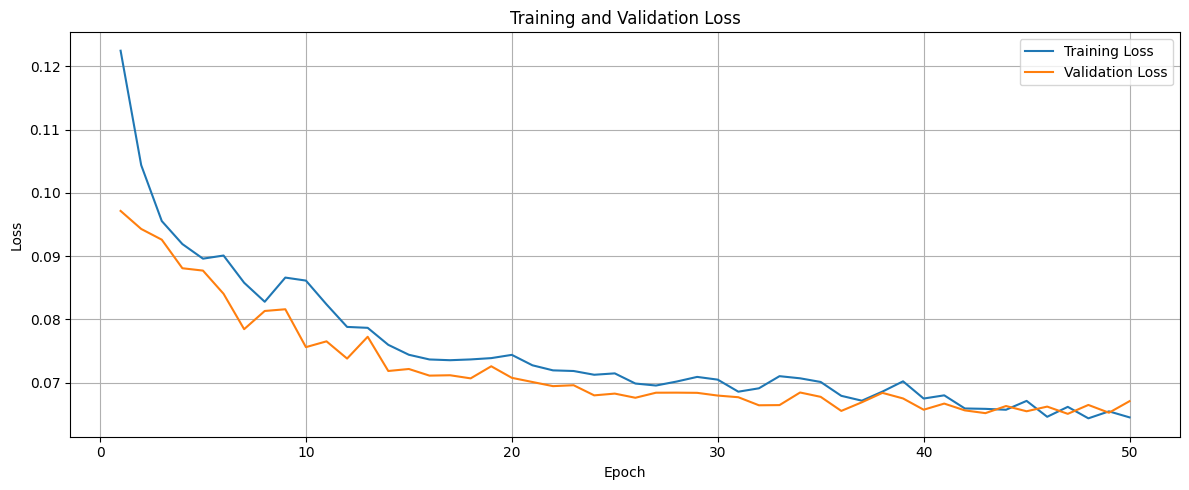

Model: "aod_CNNLSTMSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_137     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 5, 24)     │      1,320 │ input_layer_137[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 1, 12)     │          0 │ conv1d_25[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 12)        │          0 │ max_pooling1d_12… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_107   │ (None, 7, 12)     │          0 │ flatten_12[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_190 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_10… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_194 (Dense)   │ (None, 15)        │        765 │ lstm_190[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_108   │ (None, 7, 15)     │          0 │ dense_194[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_191 (LSTM)     │ (None, 7, 50)     │     13,200 │ repeat_vector_10… │
│                     │                   │            │ lstm_190[0][1],   │
│                     │                   │            │ lstm_190[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_191[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,307 (356.67 KB)

 Trainable params: 30,435 (118.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 60,872 (237.79 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_138 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_107               │ (None, 7, 12)          │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_190 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,561 (60.79 KB)

 Trainable params: 15,561 (60.79 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_139     │ (None, 24, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_192 (LSTM)     │ [(None, 64),      │     20,736 │ input_layer_139[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_109   │ (None, 1, 64)     │          0 │ lstm_192[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_193 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_10… │
│                     │                   │            │ lstm_192[0][1],   │
│                     │                   │            │ lstm_192[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_53          │ (None, 1, 64)     │          0 │ lstm_193[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_53[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,873 (218.25 KB)

 Trainable params: 55,873 (218.25 KB)

 Non-trainable params: 0 (0.00 B)

None


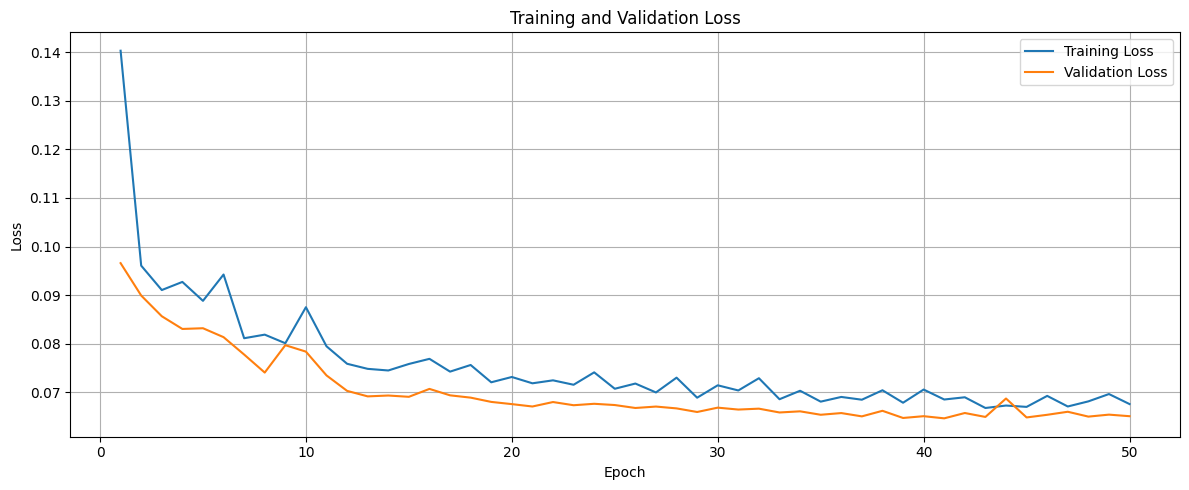

Model: "aod_CNNLSTMSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_140     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 5, 24)     │      1,320 │ input_layer_140[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_26[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 1, 12)     │          0 │ conv1d_27[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_13          │ (None, 12)        │          0 │ max_pooling1d_13… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_110   │ (None, 7, 12)     │          0 │ flatten_13[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_194 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_11… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_199 (Dense)   │ (None, 16)        │        816 │ lstm_194[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_111   │ (None, 7, 16)     │          0 │ dense_199[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_195 (LSTM)     │ (None, 7, 50)     │     13,400 │ repeat_vector_11… │
│                     │                   │            │ lstm_194[0][1],   │
│                     │                   │            │ lstm_194[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_195[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,060 (359.61 KB)

 Trainable params: 30,686 (119.87 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,374 (239.75 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_141 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_110               │ (None, 7, 12)          │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_194 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,612 (60.98 KB)

 Trainable params: 15,612 (60.98 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_142     │ (None, 24, 17)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_196 (LSTM)     │ [(None, 64),      │     20,992 │ input_layer_142[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_112   │ (None, 1, 64)     │          0 │ lstm_196[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_197 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_11… │
│                     │                   │            │ lstm_196[0][1],   │
│                     │                   │            │ lstm_196[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_54          │ (None, 1, 64)     │          0 │ lstm_197[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_54[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,129 (219.25 KB)

 Trainable params: 56,129 (219.25 KB)

 Non-trainable params: 0 (0.00 B)

None


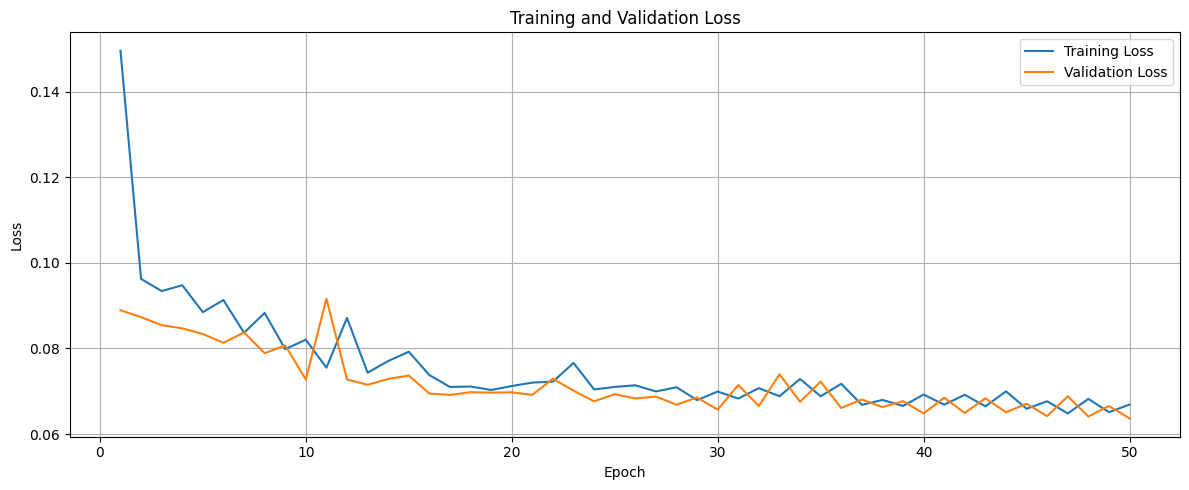

Model: "aod_CNNLSTMSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_143     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 5, 24)     │      1,320 │ input_layer_143[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_28[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_14    │ (None, 1, 12)     │          0 │ conv1d_29[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 12)        │          0 │ max_pooling1d_14… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_113   │ (None, 7, 12)     │          0 │ flatten_14[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_198 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_11… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_204 (Dense)   │ (None, 17)        │        867 │ lstm_198[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_114   │ (None, 7, 17)     │          0 │ dense_204[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_199 (LSTM)     │ (None, 7, 50)     │     13,600 │ repeat_vector_11… │
│                     │                   │            │ lstm_198[0][1],   │
│                     │                   │            │ lstm_198[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_199[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,813 (362.55 KB)

 Trainable params: 30,937 (120.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,876 (241.71 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_144 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_113               │ (None, 7, 12)          │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_198 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,663 (61.18 KB)

 Trainable params: 15,663 (61.18 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_145     │ (None, 24, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_200 (LSTM)     │ [(None, 64),      │     21,248 │ input_layer_145[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_115   │ (None, 1, 64)     │          0 │ lstm_200[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_201 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_11… │
│                     │                   │            │ lstm_200[0][1],   │
│                     │                   │            │ lstm_200[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_55          │ (None, 1, 64)     │          0 │ lstm_201[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_55[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,385 (220.25 KB)

 Trainable params: 56,385 (220.25 KB)

 Non-trainable params: 0 (0.00 B)

None


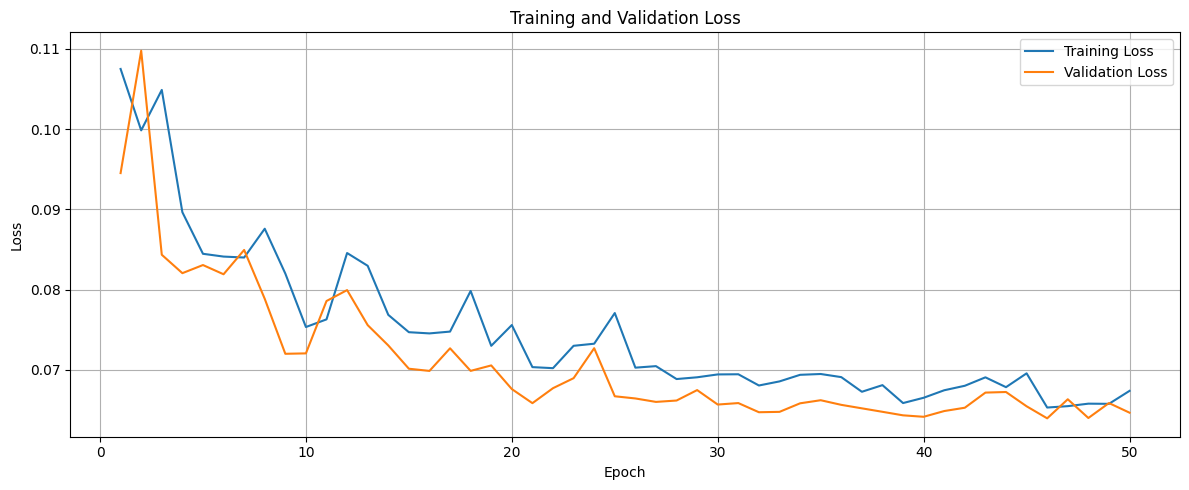

Choosing the best result

dict_keys([13, 14, 15, 16, 17])
N = 13
mae = 4.102007460827515
mse = 31.814935032904465
rmse = 5.640472944080528
r2 = -1.1456477620406642
mape = 0.24416008371926004
N = 14
mae = 4.727908300978121
mse = 34.210089425726714
rmse = 5.848939170971666
r2 = -1.4158382381038468
mape = 0.24578062564968137
N = 15
mae = 4.340691975088033
mse = 32.734322816765676
rmse = 5.721391685312733
r2 = -2.2581797418756135
mape = 0.24989628801904296
N = 16
mae = 4.186422063277458
mse = 30.371751963711812
rmse = 5.511057245548427
r2 = -0.843988973841258
mape = 0.23276764872181002
N = 17
mae = 4.459894731500022
mse = 31.809276189866605
rmse = 5.639971293354835
r2 = -1.6896408020057092
mape = 0.2421564879690268


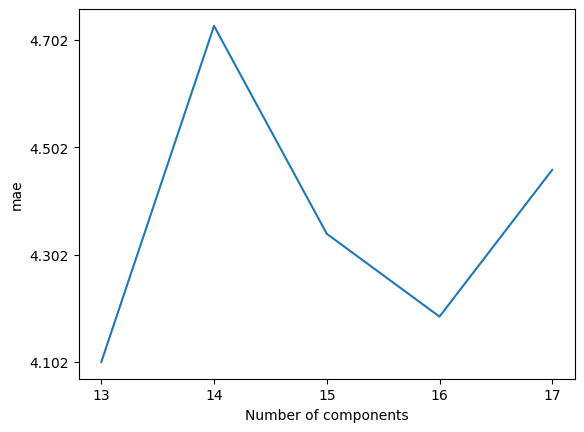

inv_y_pred.shape = (773, 1)
inv_y_test.shape = (773, 1)


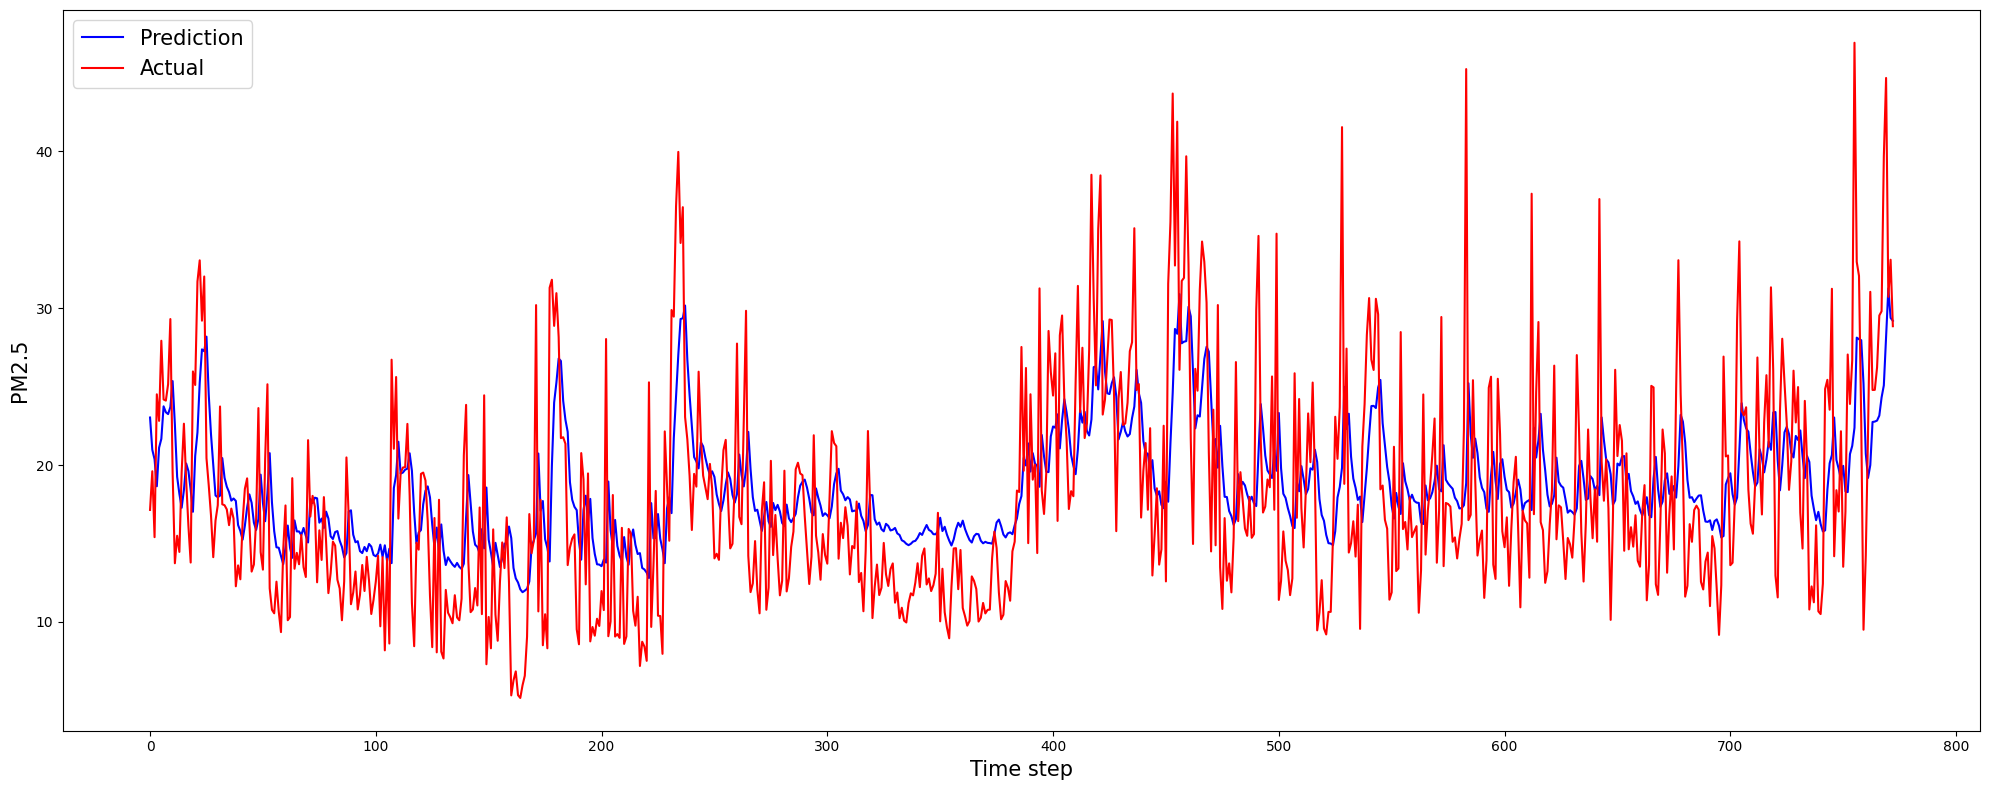

dim_reduction_method dim_after_reduction prediction       mae        mse  \
0                 None                 N/A       LSTM  4.526494  37.178583   
1         LSTM-Seq2Seq                  17       LSTM  6.028108  50.430684   
2          GRU-Seq2Seq                  17       LSTM  3.986179  30.871966   
3      CNNLSTM-Seq2Seq                  17       LSTM  4.459895  31.809276   

       rmse        r2      mape  
0  6.097424 -2.126817  0.272811  
1  7.101456 -2.259124  0.278865  
2  5.556255 -0.838648  0.238656  
3  5.639971 -1.689641  0.242156

In [118]:
loopresults = generate_loopresults(RANGE_OF_DIMENSION, CNNLSTMSeq2SeqReduction, LSTMPrediction, X_aod_scaled, y_aod_scaled, aod_label_scaler)
best_metrics, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = choose_the_best(loopresults, metric_to_choose="mae")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["CNNLSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
for metric, value in best_metrics.items():
    evaluation_board[metric] += [value]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [119]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_cnnlstms2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_cnnlstms2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_cnnlstms2s_reduced_2021_2022.csv"))
df_cnnlstms2s_reduced

aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2018-01-01       0.532398      -0.253467      -0.196832      -0.071098   
2018-01-02       0.532398      -0.253467      -0.196832      -0.071098   
2018-01-03       0.532398      -0.253467      -0.196832      -0.071098   
2018-01-04       0.535167      -0.255147      -0.198889      -0.070515   
2018-01-05       0.546982      -0.261065      -0.203726      -0.070755   
...                   ...            ...            ...            ...   
2022-12-27       0.566154      -0.067840      -0.288656      -0.099359   
2022-12-28       0.560505      -0.057172      -0.301723      -0.098073   
2022-12-29       0.592720      -0.068002      -0.325789      -0.100830   
2022-12-30       0.615294      -0.069459      -0.337558      -0.095646   
2022-12-31       0.606391      -0.068711      -0.346396      -0.095666   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2018-01-01      -0.179847       0.211967      -0.526592      -0.454228   
2018-01-02      -0.179847       0.211967      -0.526592      -0.454228   
2018-01-03      -0.179847       0.211967      -0.526592      -0.454228   
2018-01-04      -0.179344       0.212567      -0.529931      -0.455778   
2018-01-05      -0.177514       0.213727      -0.537436      -0.455784   
...                   ...            ...            ...            ...   
2022-12-27       0.096550       0.315767      -0.316590       0.087958   
2022-12-28       0.102785       0.319145      -0.305039       0.106014   
2022-12-29       0.102881       0.328470      -0.315608       0.107578   
2022-12-30       0.101758       0.324988      -0.316175       0.102678   
2022-12-31       0.104497       0.326685      -0.323503       0.098058   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2018-01-01       0.671385        0.211339       -0.024031        0.539731   
2018-01-02       0.671385        0.211339       -0.024031        0.539731   
2018-01-03       0.671385        0.211339       -0.024031        0.539731   
2018-01-04       0.672551        0.211936       -0.023582        0.542125   
2018-01-05       0.682250        0.217139       -0.015644        0.552542   
...                   ...             ...             ...             ...   
2022-12-27       0.173404        0.001969        0.059941        0.340529   
2022-12-28       0.156261       -0.007167        0.056669        0.320810   
2022-12-29       0.162752       -0.012290        0.066782        0.339883   
2022-12-30       0.169820       -0.016630        0.073746        0.354318   
2022-12-31       0.157330       -0.017377        0.067539        0.349491   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2018-01-01        0.292979       -0.004721       -0.061105        0.648417   
2018-01-02        0.292979       -0.004721       -0.061105        0.648417   
2018-01-03        0.292979       -0.004721       -0.061105        0.648417   
2018-01-04        0.294638       -0.005185       -0.061220        0.651256   
2018-01-05        0.296951       -0.003083       -0.065935        0.654506   
...                    ...             ...             ...             ...   
2022-12-27        0.380985       -0.194430       -0.126955        0.483902   
2022-12-28        0.386412       -0.205451       -0.121129        0.475017   
2022-12-29        0.405481       -0.210849       -0.140025        0.474288   
2022-12-30        0.406591       -0.214325       -0.154853        0.465224   
2022-12-31        0.409536       -0.215254       -0.142723        0.473410   

            aod_feature_17  station  
time                           

In [120]:
# Prepare the reduced data with additional pm25_3km and predicted pm25 values
df_cnnlstms2s_reduced_augmented = augmentReducedData(df_cnnlstms2s_reduced, y_aod_scaled, aod_pm25_3km_column, aod_label_scaler)
df_cnnlstms2s_reduced_augmented.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_cnnlstms2s_reduced_2021_2022_with_raw_pm25_3km_and_prediced_pm25.csv"))
df_cnnlstms2s_reduced_augmented

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2018-01-01       0.532398      -0.253467      -0.196832      -0.071098   
2018-01-02       0.532398      -0.253467      -0.196832      -0.071098   
2018-01-03       0.532398      -0.253467      -0.196832      -0.071098   
2018-01-04       0.535167      -0.255147      -0.198889      -0.070515   
2018-01-05       0.546982      -0.261065      -0.203726      -0.070755   
...                   ...            ...            ...            ...   
2022-12-27       0.566154      -0.067840      -0.288656      -0.099359   
2022-12-28       0.560505      -0.057172      -0.301723      -0.098073   
2022-12-29       0.592720      -0.068002      -0.325789      -0.100830   
2022-12-30       0.615294      -0.069459      -0.337558      -0.095646   
2022-12-31       0.606391      -0.068711      -0.346396      -0.095666   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2018-01-01      -0.179847       0.211967      -0.526592      -0.454228   
2018-01-02      -0.179847       0.211967      -0.526592      -0.454228   
2018-01-03      -0.179847       0.211967      -0.526592      -0.454228   
2018-01-04      -0.179344       0.212567      -0.529931      -0.455778   
2018-01-05      -0.177514       0.213727      -0.537436      -0.455784   
...                   ...            ...            ...            ...   
2022-12-27       0.096550       0.315767      -0.316590       0.087958   
2022-12-28       0.102785       0.319145      -0.305039       0.106014   
2022-12-29       0.102881       0.328470      -0.315608       0.107578   
2022-12-30       0.101758       0.324988      -0.316175       0.102678   
2022-12-31       0.104497       0.326685      -0.323503       0.098058   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2018-01-01       0.671385        0.211339       -0.024031        0.539731   
2018-01-02       0.671385        0.211339       -0.024031        0.539731   
2018-01-03       0.671385        0.211339       -0.024031        0.539731   
2018-01-04       0.672551        0.211936       -0.023582        0.542125   
2018-01-05       0.682250        0.217139       -0.015644        0.552542   
...                   ...             ...             ...             ...   
2022-12-27       0.173404        0.001969        0.059941        0.340529   
2022-12-28       0.156261       -0.007167        0.056669        0.320810   
2022-12-29       0.162752       -0.012290        0.066782        0.339883   
2022-12-30       0.169820       -0.016630        0.073746        0.354318   
2022-12-31       0.157330       -0.017377        0.067539        0.349491   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2018-01-01        0.292979       -0.004721       -0.061105        0.648417   
2018-01-02        0.292979       -0.004721       -0.061105        0.648417   
2018-01-03        0.292979       -0.004721       -0.061105        0.648417   
2018-01-04        0.294638       -0.005185       -0.061220        0.651256   
2018-01-05        0.296951       -0.003083       -0.065935        0.654506   
...                    ...             ...             ...             ...   
2022-12-27        0.380985       -0.194430       -0.126955        0.483902   
2022-12-28        0.386412       -0.205451       -0.121129        0.475017   
2022-12-29        0.405481       -0.210849       -0.140025        0.474288   
2022-12-30        0.406591       -0.214325       -0.154853        0.465224   
2022-12-31        0.409536       -0.215254       -0.142723        0.473410   

            aod_feature_17  station   pm25_3km  hiep_predicted_pm25  

#### Compare MAE with pm25_3km

On test data:
MAE between actual and pm25_3km: 6.800208042080604
MAE between actual and predicted pm25: 4.459894731500022
MSE between actual and pm25_3km: 87.55791124485947
MSE between actual and predicted pm25: 31.809276189866605


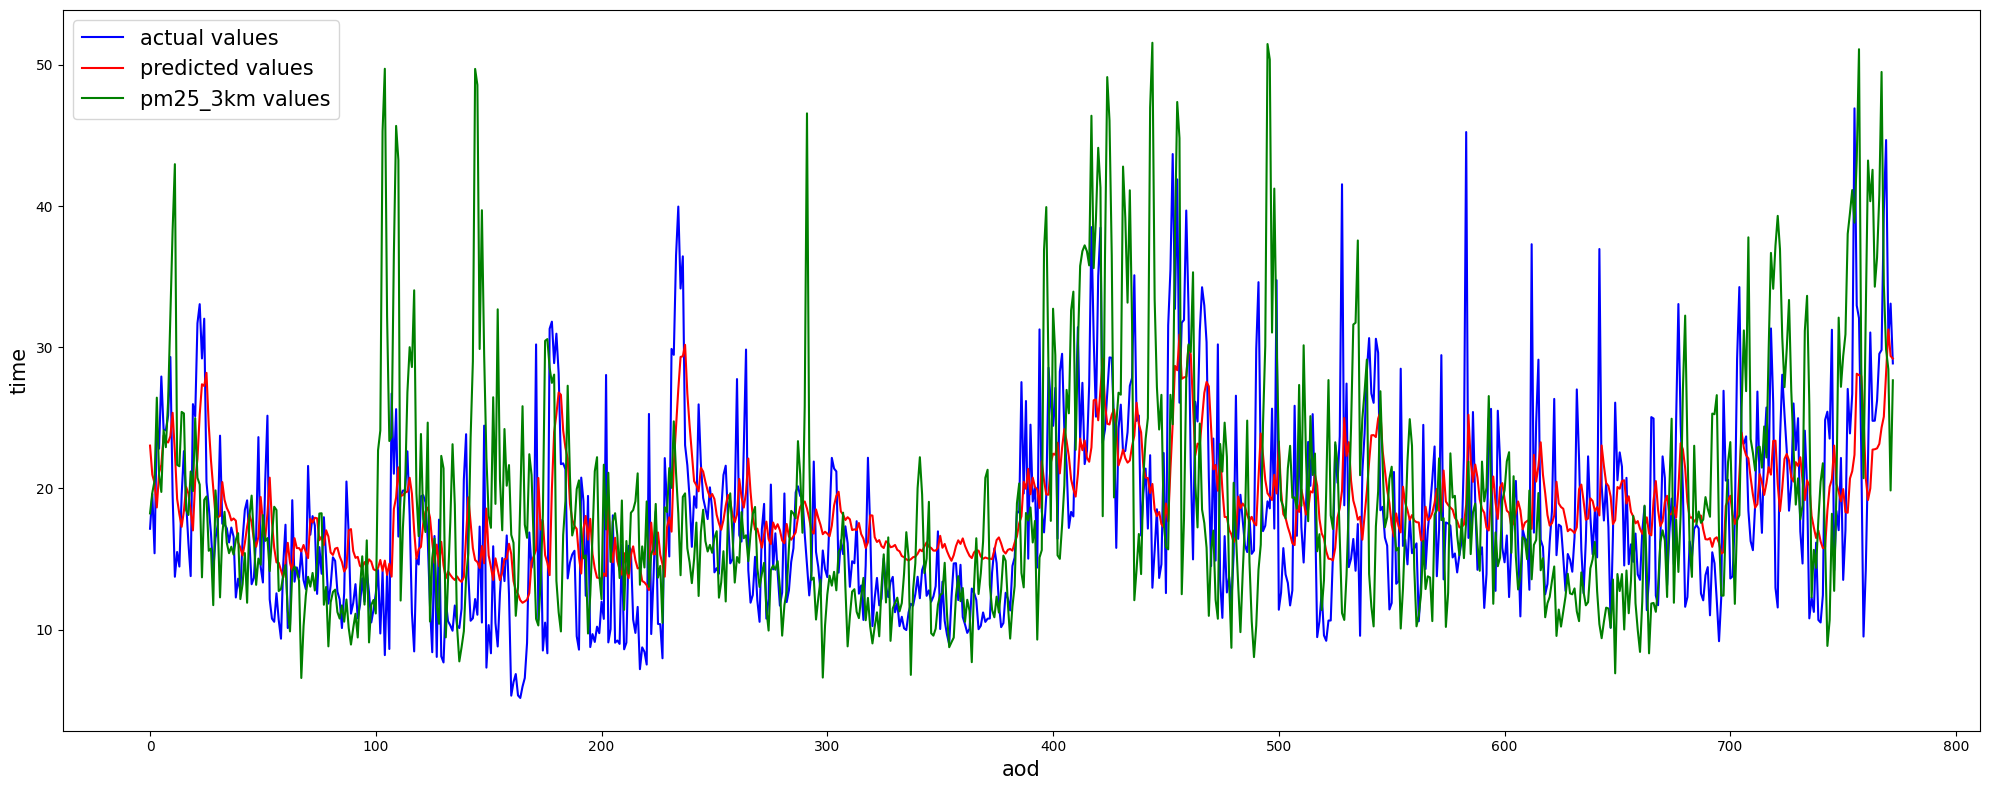

On entire data:
MAE between actual and pm25_3km: 7.875957292759844
MAE between actual and predicted pm25: 5.274947166442871


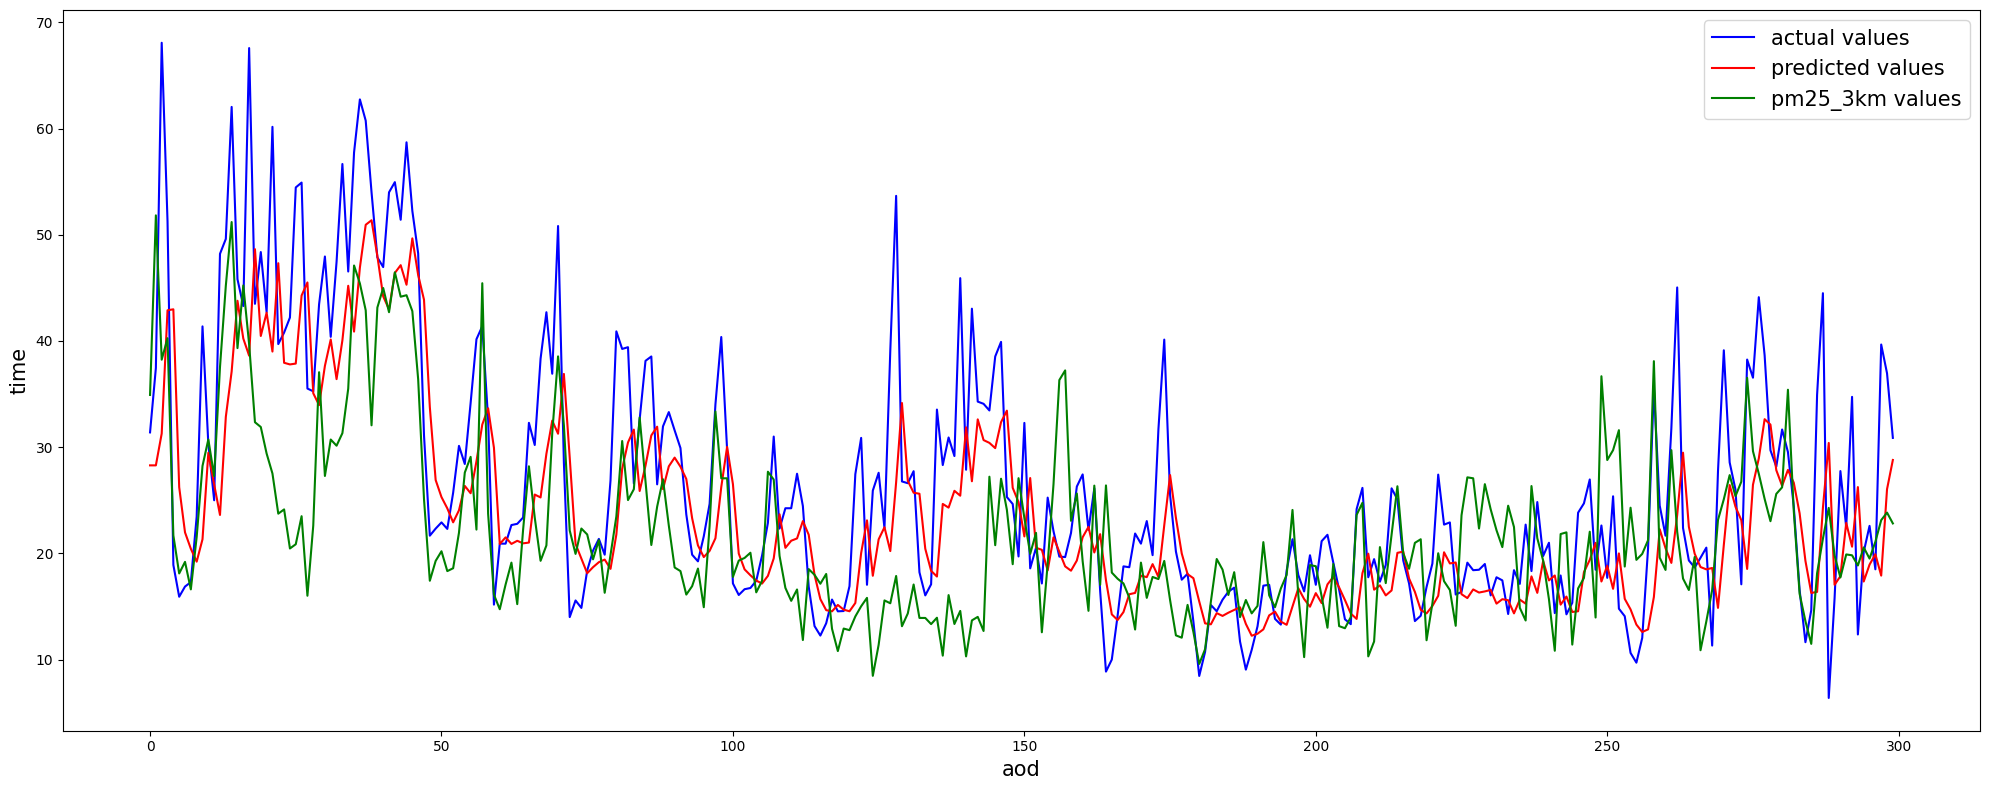

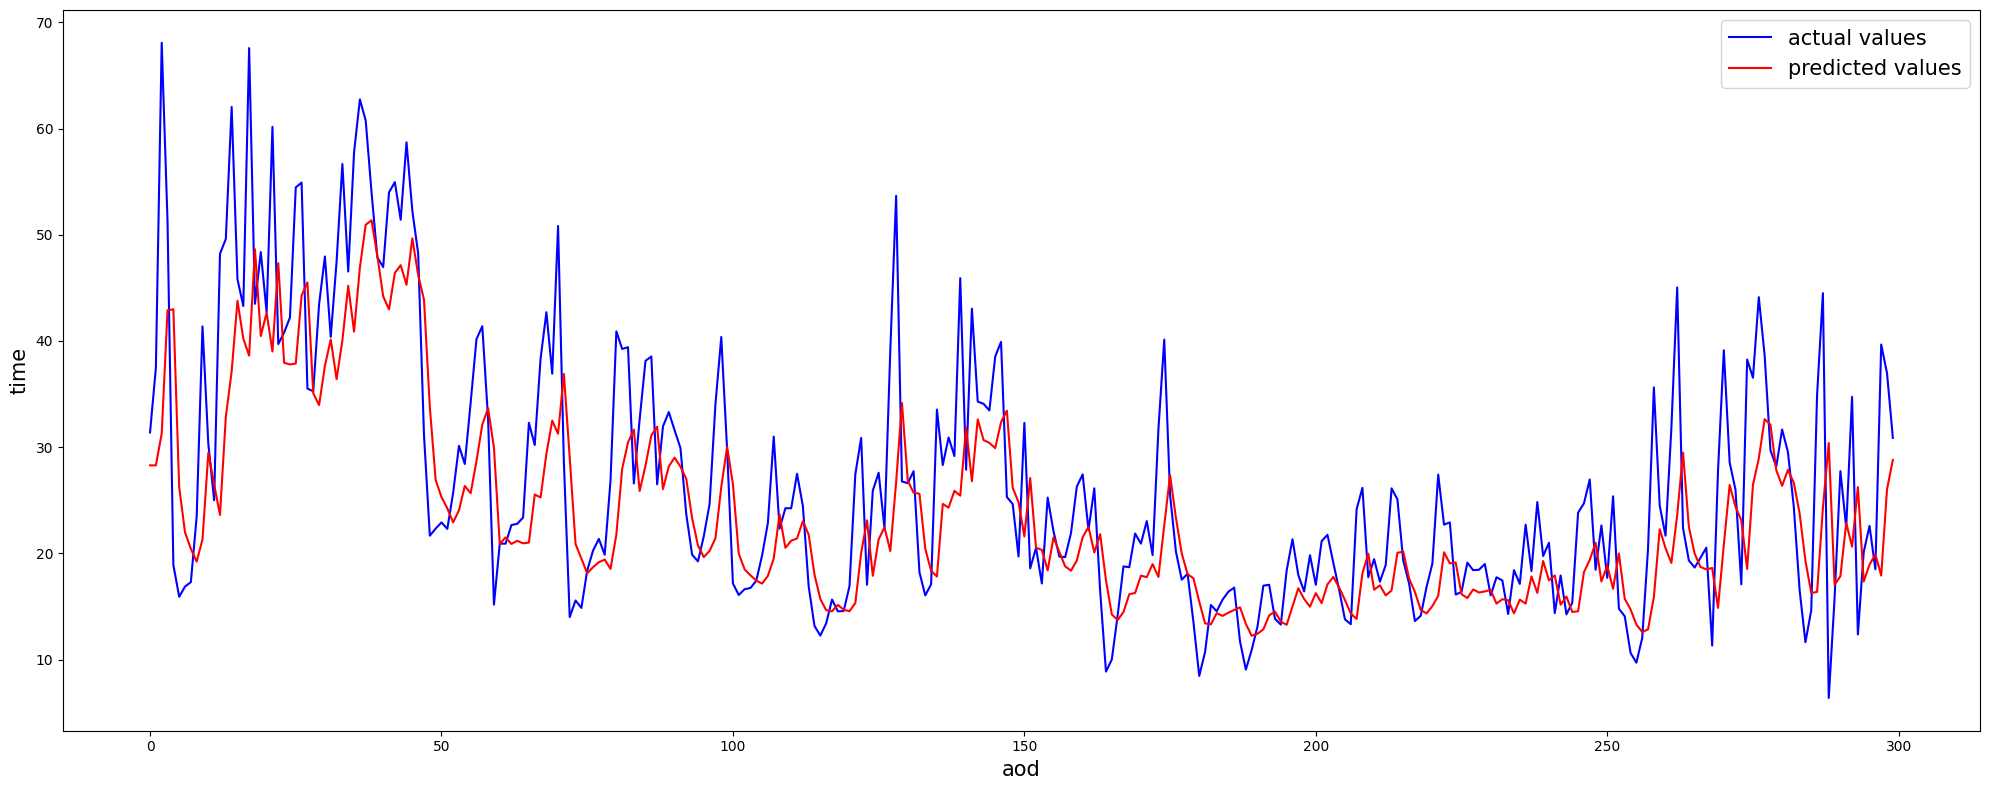

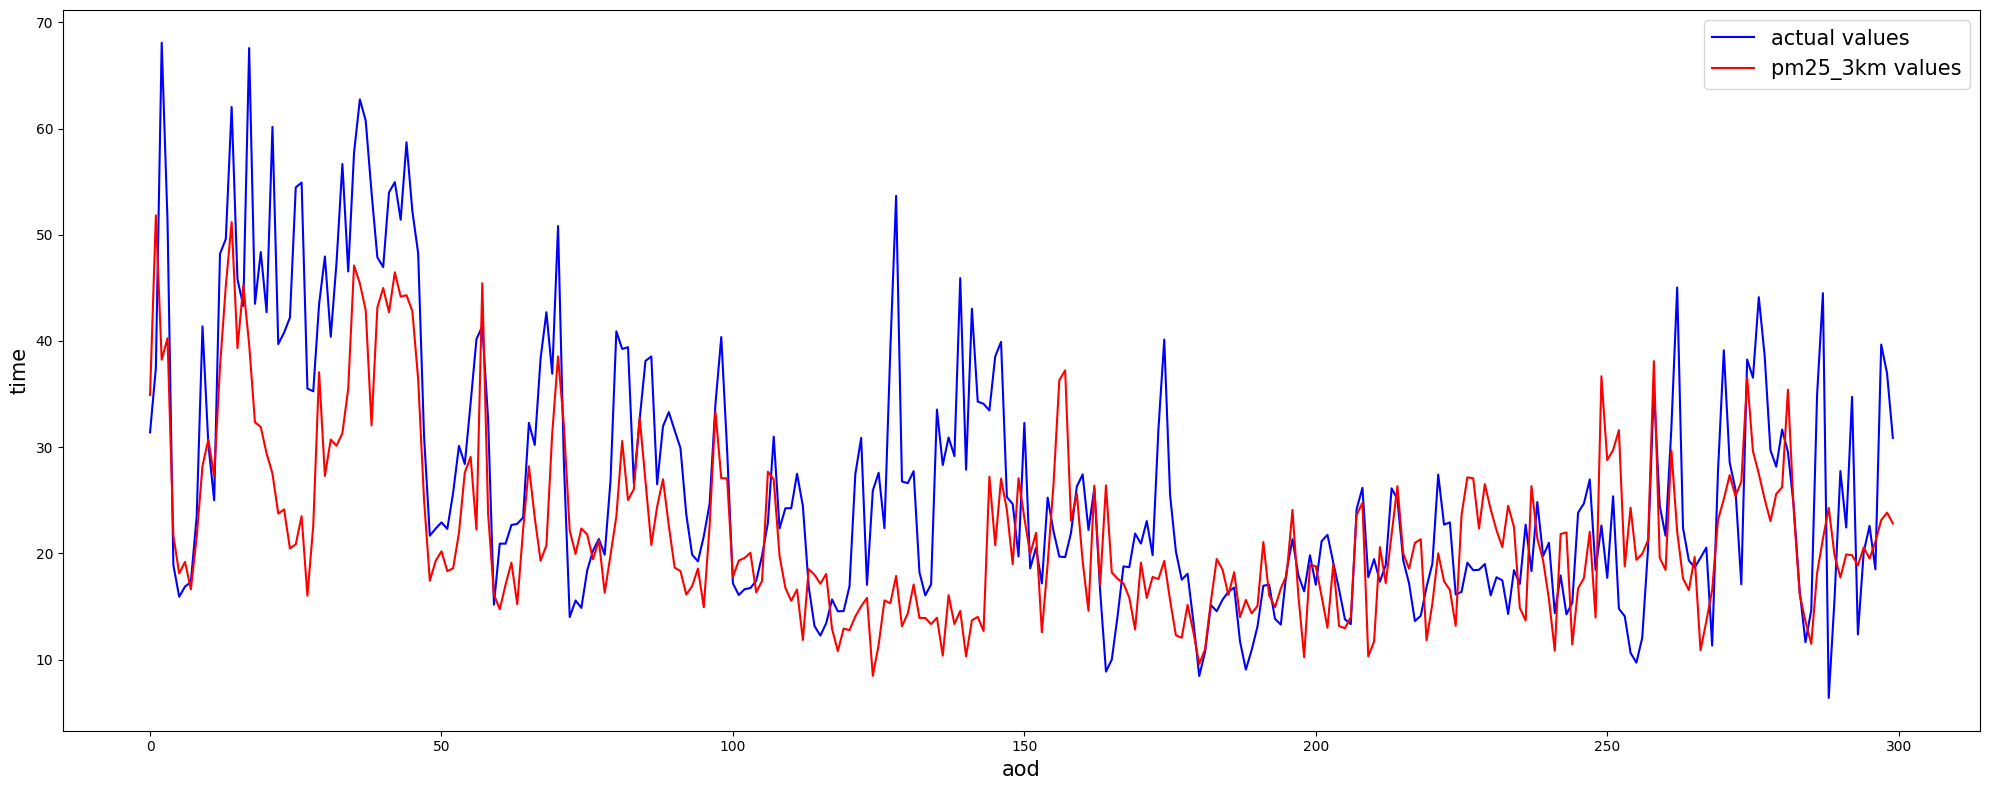

In [121]:
# Compare test set only
all_days_inv_y_pred, all_days_inv_y_test = best_evaluation_data
y_pred = all_days_inv_y_pred.reshape(-1, 1)
y_test = all_days_inv_y_test.reshape(-1, 1)
test_len = y_test.shape[0]
aod_pm25_3km_column_test = aod_pm25_3km_column.tail(test_len)
print("On test data:")
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_test, aod_pm25_3km_column_test)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE between actual and pm25_3km: {mean_squared_error(y_test, aod_pm25_3km_column_test)}")
print(f"MSE between actual and predicted pm25: {mean_squared_error(y_test, y_pred)}")
plot_3_data(data1=y_test,
           datalabel1="actual values",
           data2=y_pred,
           datalabel2="predicted values",
           data3=aod_pm25_3km_column_test,
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")

# Compare entire dataset
print("On entire data:")
y_pred_all = df_cnnlstms2s_reduced_augmented["hiep_predicted_pm25"]
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_aod, aod_pm25_3km_column)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_aod, y_pred_all)}")
plot_3_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=y_pred_all.head(300),
           datalabel2="predicted values",
           data3=aod_pm25_3km_column.head(300),
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=y_pred_all.head(300),
           datalabel2="predicted values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=aod_pm25_3km_column.head(300),
           datalabel2="pm25_3km values",
           ylabel="time",
           xlabel="aod")